# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [ ]:
%%capture
!pip install rusenttokenize

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from rusenttokenize import ru_sent_tokenize
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders
from tqdm.autonotebook import tqdm

### Разделение на предложения

In [ ]:
data = pd.read_csv("https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip")

sentences = []
for text in tqdm(data.text.values):
    sentences.extend(ru_sent_tokenize(text))

f = open("corpus.txt", "w")
for sent in sentences:
    f.write(sent + "\n")
f.close()

In [4]:
sentences = open("corpus.txt").read().splitlines()

### Токенизация

In [5]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix="</w>")
tokenizer.train(files=["corpus.txt"], trainer=trainer)
tokenizer.save("tokenizer")

In [6]:
tokenizer = Tokenizer.from_file("tokenizer")
tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()

### Датасет

In [7]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id("[BOS]")] + tokenizer.encode(text).ids + [tokenizer.token_to_id("[EOS]")]

In [8]:
def fix_token_display(tokens):
    for i, token in enumerate(tokens):
        if token.endswith("</w>"):
            tokens[i] = token[:-4]
        elif not token.endswith("]"):
            tokens[i] = token + "%%"
    return tokens

In [9]:
PAD_IDX = tokenizer.token_to_id("[PAD]")
MAX_LEN = 64

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

In [11]:
n = int(0.9 * len(sentences))
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [12]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [13]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True)
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

### Обучение

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
block_size = MAX_LEN
learning_rate = 1e-3
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [15]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float("-inf"))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs = []
        attn_weights = []
        for h in self.heads:
            head_out, wei = h(x, mask)
            head_outputs.append(head_out)
            attn_weights.append(wei)

        out = torch.cat(head_outputs, dim=-1)
        out = self.dropout(self.proj(out))
        return out, attn_weights

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        x, mask, all_attn_outputs = inp
        attn_outputs = self.sa(self.ln1(x), mask)
        x = x + attn_outputs[0]
        x = x + self.ffwd(self.ln2(x))
        # attn_outputs[1] is the weights
        all_attn_outputs.extend(attn_outputs[1])
        return (x, mask, all_attn_outputs)

In [16]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.last_attentions = None

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, self.last_attentions = self.blocks((x, mask, [])) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [17]:
model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [18]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

In [19]:
def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.inference_mode():
        for xs, ys, mask in iterator:
            logits, loss = model(xs.to(device), ys.to(device), mask.to(device))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [20]:
def get_tokens(input):
    xs, ys, mask = input
    tokens = fix_token_display([
        tokenizer.id_to_token(id)
        for i, id in enumerate(xs.tolist())
        if mask[i]
    ])
    return tokens

In [21]:
def get_attns_on_sentence(model, input):
    xs, ys, mask = input
    model.eval()
    with torch.inference_mode():
        logits, loss = model(
            xs.unsqueeze(0).to(device),
            ys.unsqueeze(0).to(device),
            mask.unsqueeze(0).to(device)
        )
    sent_len = mask.sum()
    attns = [
        attn[:, :sent_len, :sent_len].squeeze().detach().cpu().numpy()
        for attn in model.last_attentions
    ]
    return attns

In [22]:
def visualize_attns(attns, tokens):
    fig, axes = plt.subplots(
        n_layer, n_head,
        figsize=(n_layer * 5, n_head * 5)
    )
    for i in range(n_layer):
        for j in range(n_head):
            ax = axes[i, j]
            sns.heatmap(
                attns[i * n_head + j],
                ax=ax, cmap="viridis",
                xticklabels=tokens, yticklabels=tokens
            )
            ax.set_title(f"Layer {i + 1}, Head {j + 1}")
    plt.tight_layout()
    plt.show()

In [23]:
train_losses = []
eval_losses = []
all_attns = []
tokens = get_tokens(val_set[0])

for i in range(20):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print("Eval -", eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(
            torch.LongTensor([[tokenizer.token_to_id("[BOS]")]]).to("cuda"),
            200, tokenizer.token_to_id("[EOS]")
        )
        print(
            tokenizer.decoder.decode(
                [
                    tokenizer.id_to_token(i)
                    for i in pred.detach().cpu().numpy()[0]
                ][1:-1]
            )
        )
    all_attns.append(get_attns_on_sentence(model, val_set[0]))

0
Loss: 8.537758827209473
Loss: 8.137545585632324
Loss: 7.950080394744873
Loss: 7.817023754119873
Loss: 7.705367565155029
Loss: 7.608429431915283
Loss: 7.51698637008667
Loss: 7.431297779083252
Loss: 7.35007381439209
Loss: 7.274365425109863
Loss: 7.202133655548096
Loss: 7.134904861450195
Loss: 7.071775913238525
Loss: 7.012424468994141
Loss: 6.956286907196045
Loss: 6.904587268829346
Loss: 6.854733467102051
Loss: 6.807798862457275
Loss: 6.763222694396973
Loss: 6.720673084259033
Loss: 6.680405616760254
Loss: 6.6421403884887695
Eval - 5.762599945068359
В 2009 году большинство мятельного суда выдвигались на лете « морское апелмия к и положителей кризии другая » и Ирака
По неподтвержденным компании состоялась 101 до 31
Как сообщает официальный сайт милиции высказал реструктуризации бронетехники на паривесный в финансировании 1937 века защиты бечел с Хаджилем победил это придется получить гнать представительство меньше доверются
1
Loss: 5.739346981048584
Loss: 5.725992202758789
Loss: 5.7146191

### Визуализация

Epoch 0:


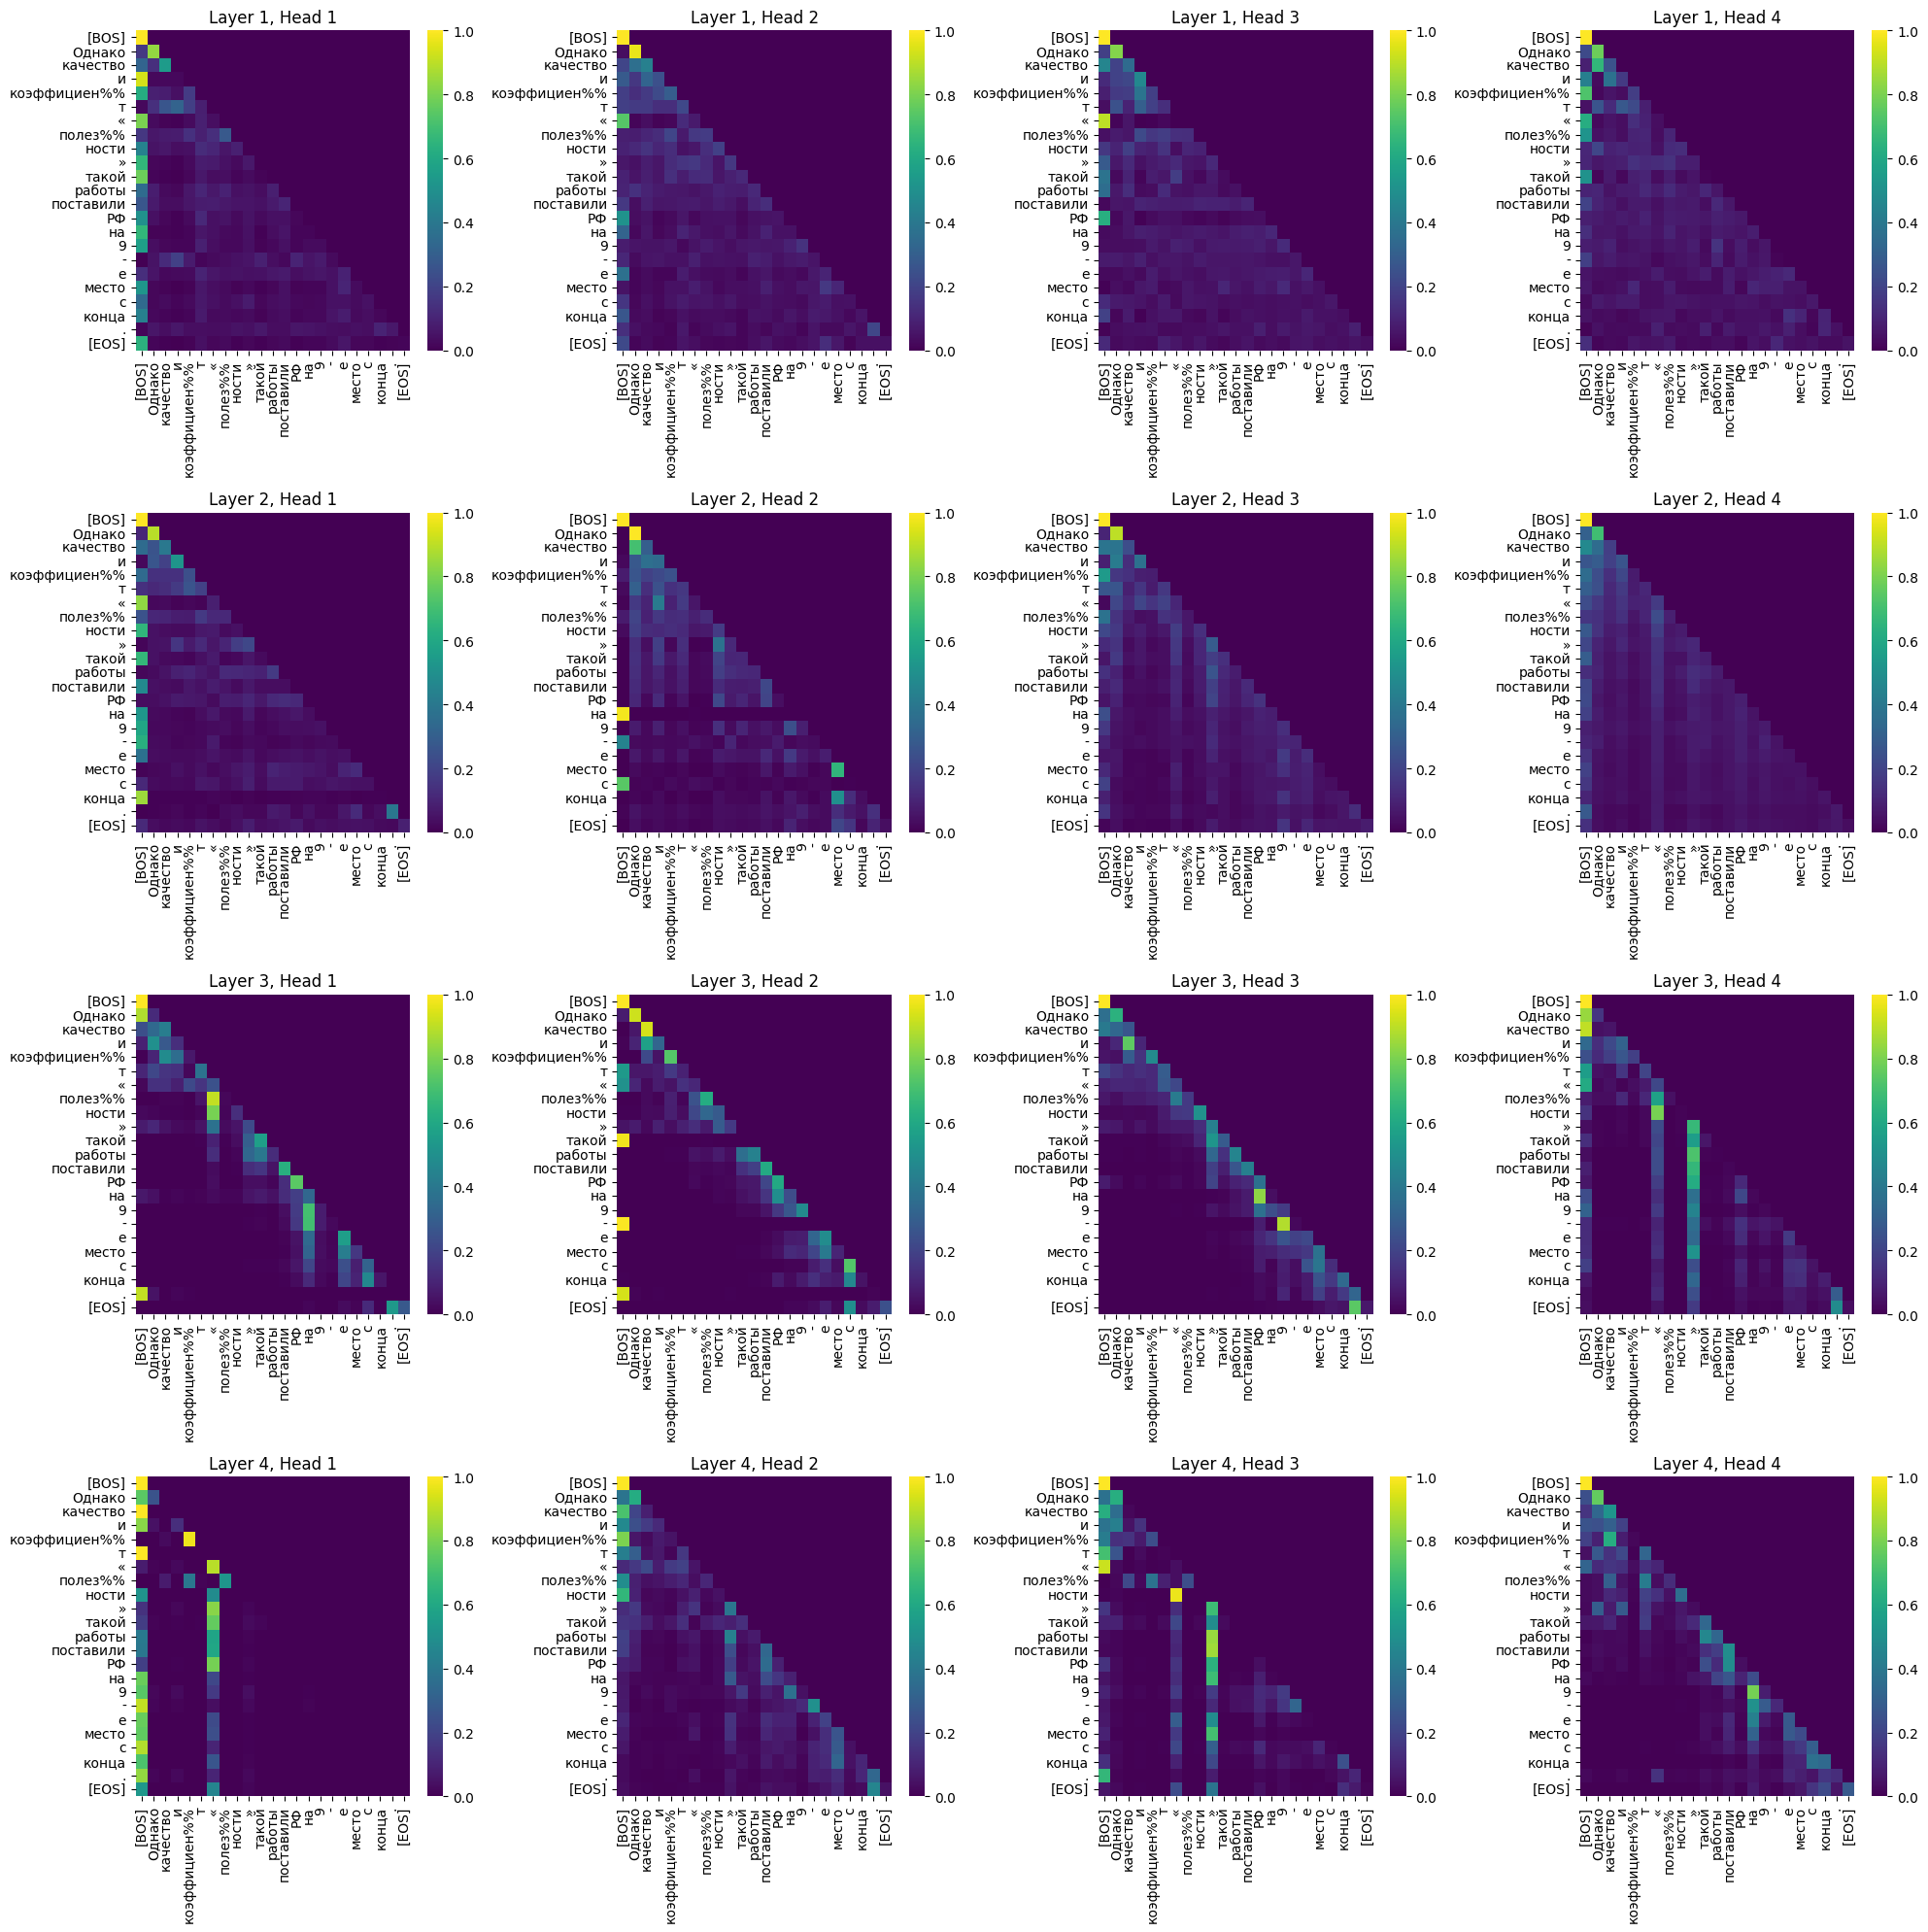

Epoch 1:


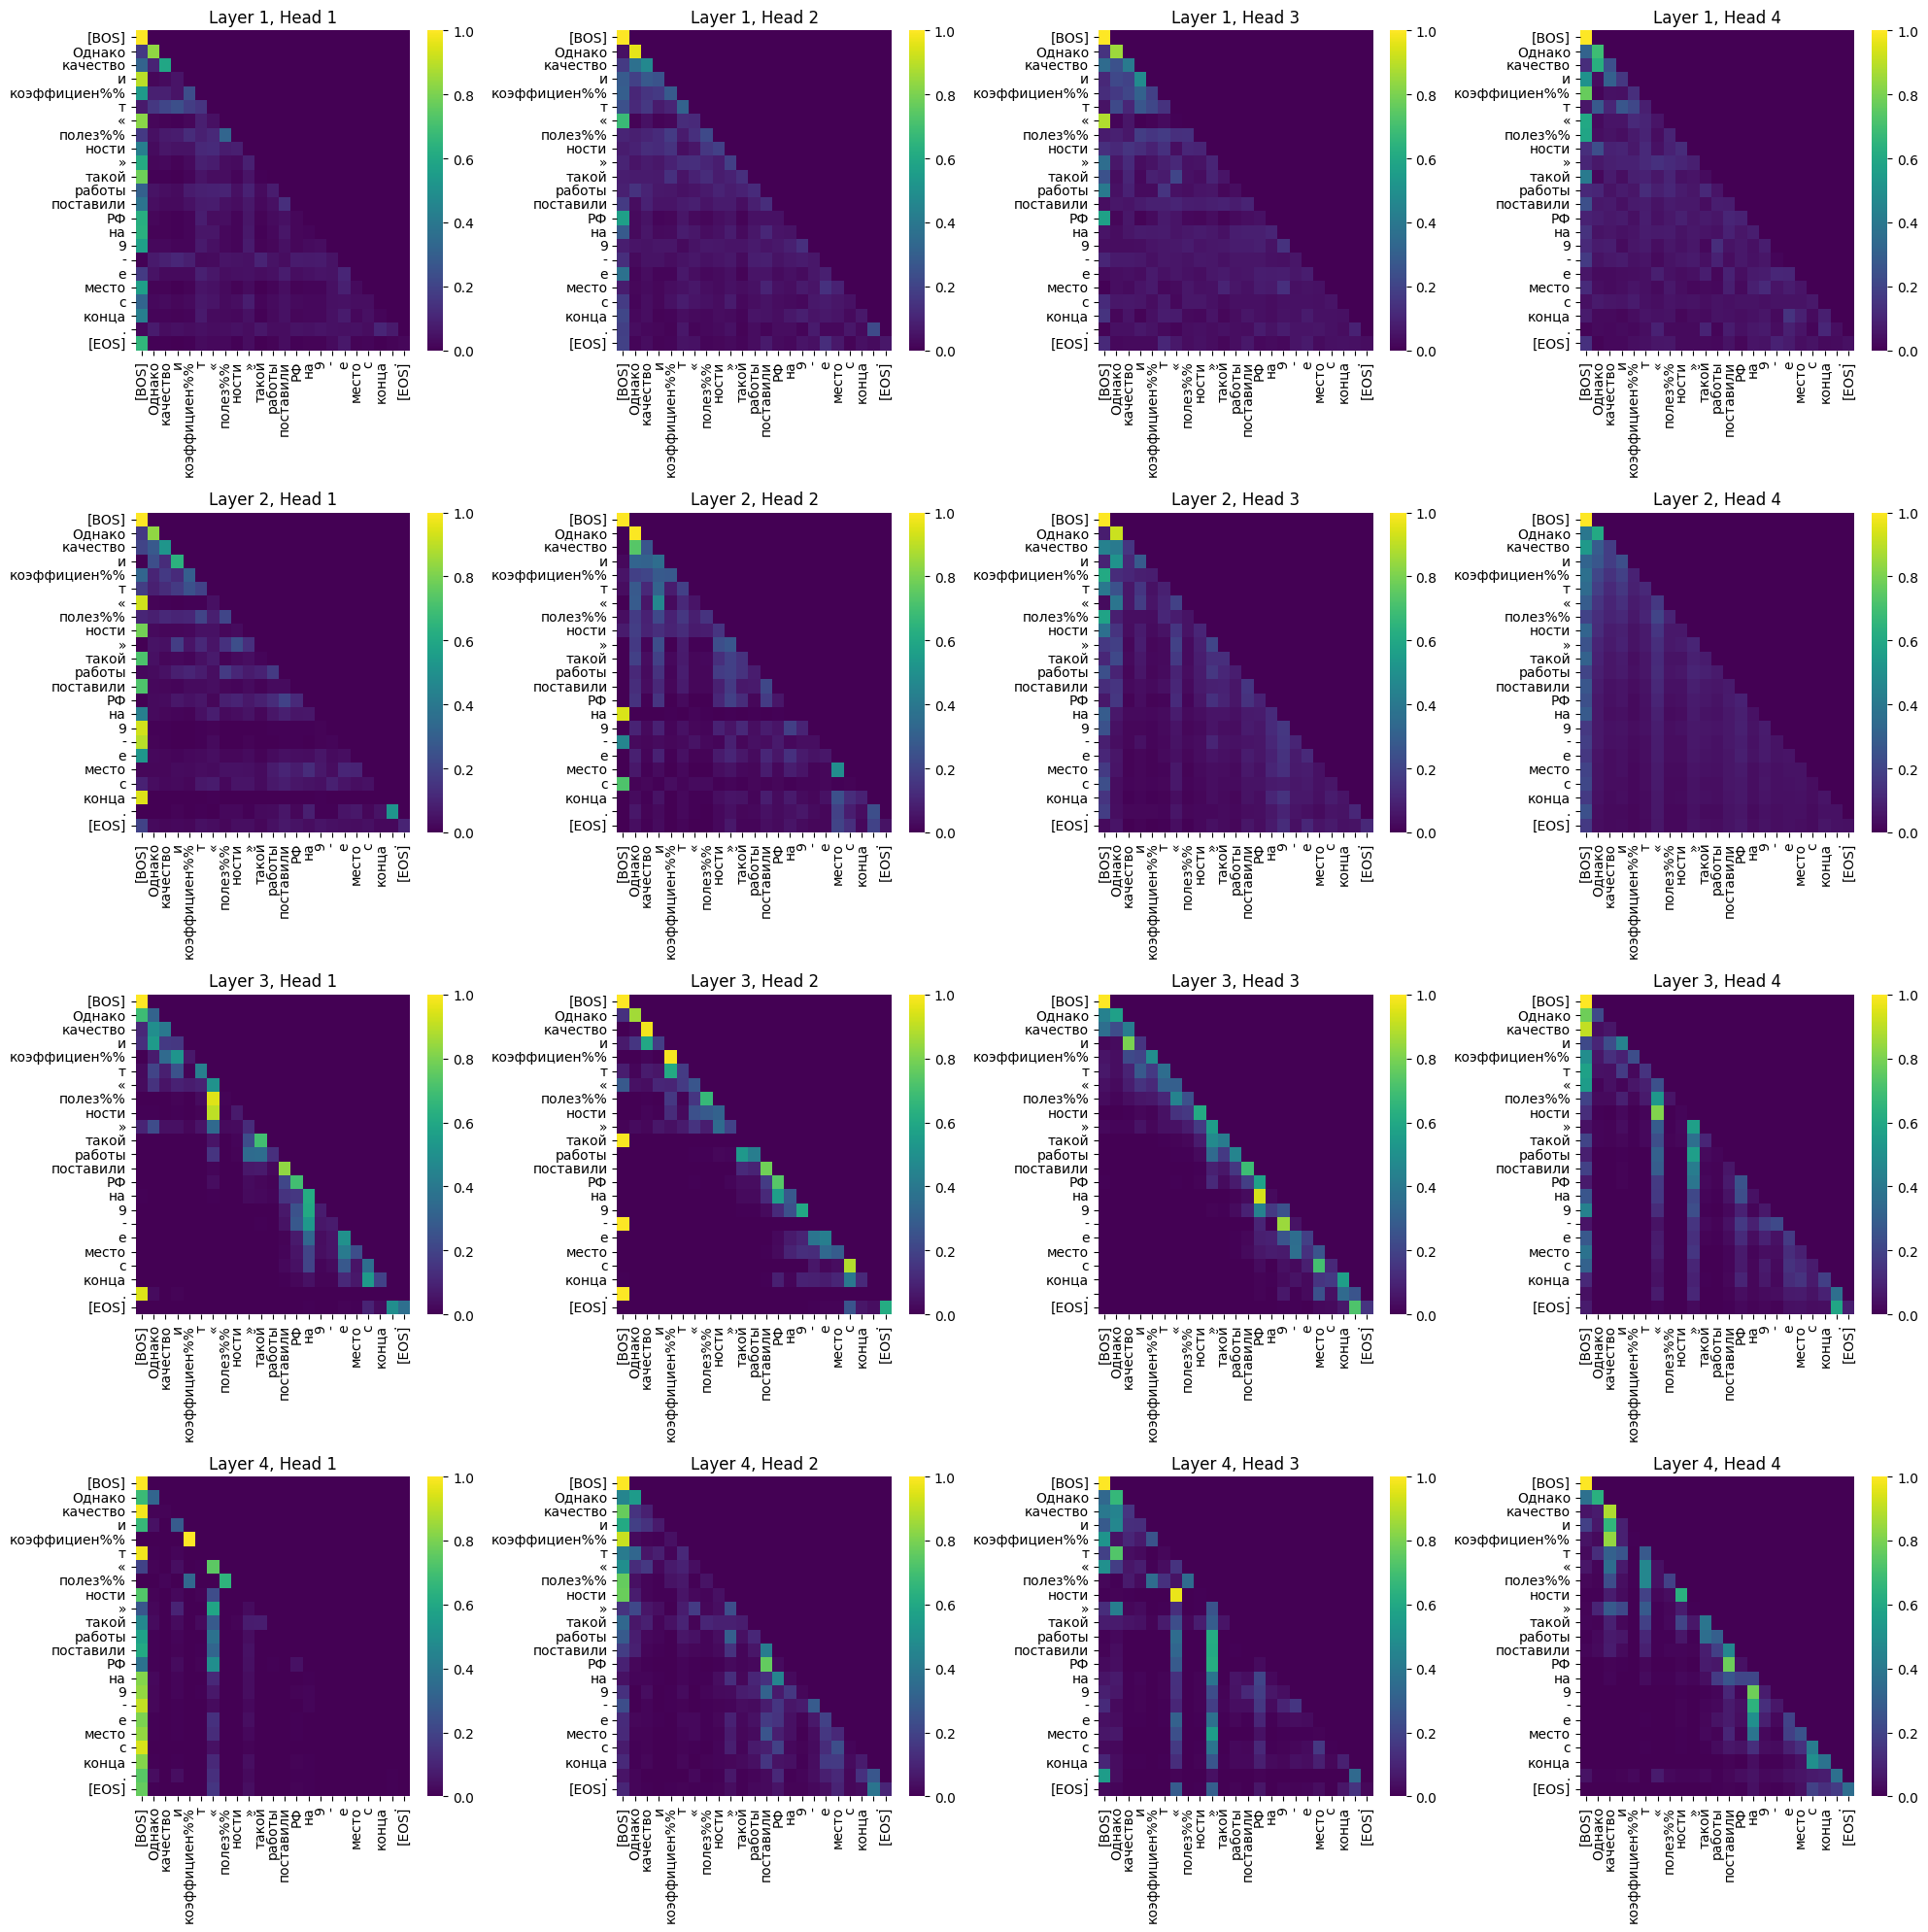

Epoch 2:


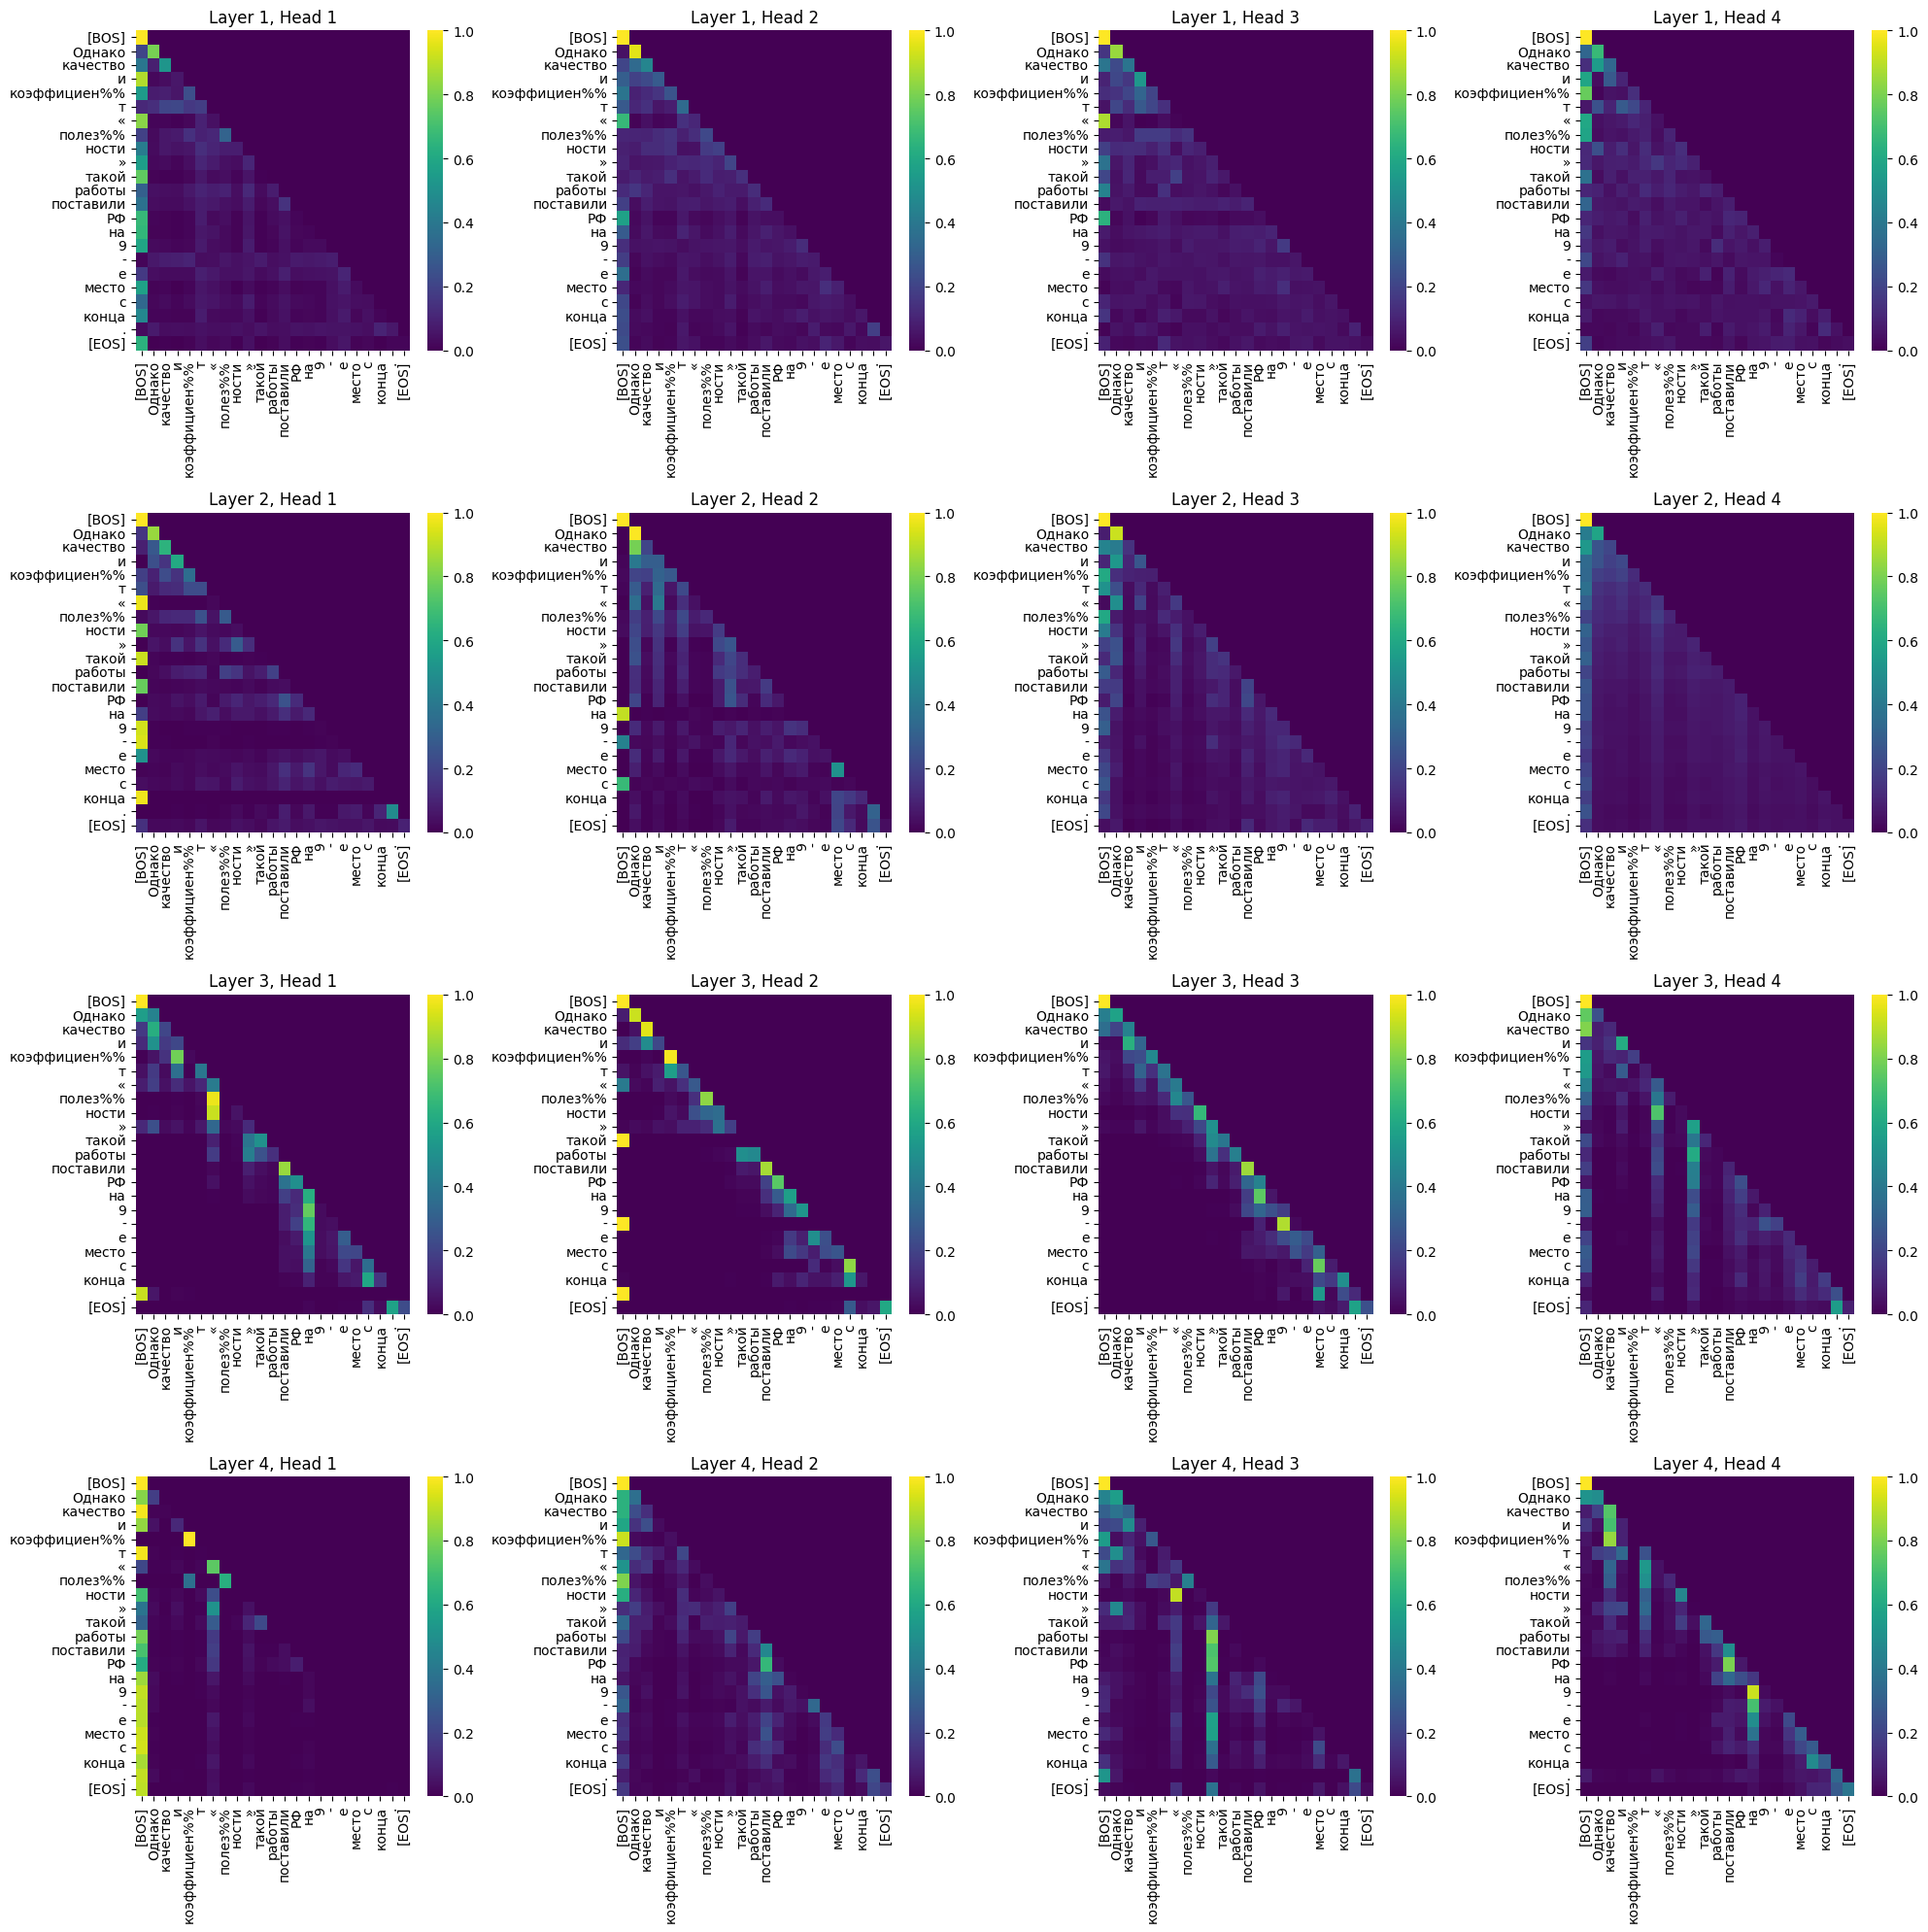

Epoch 3:


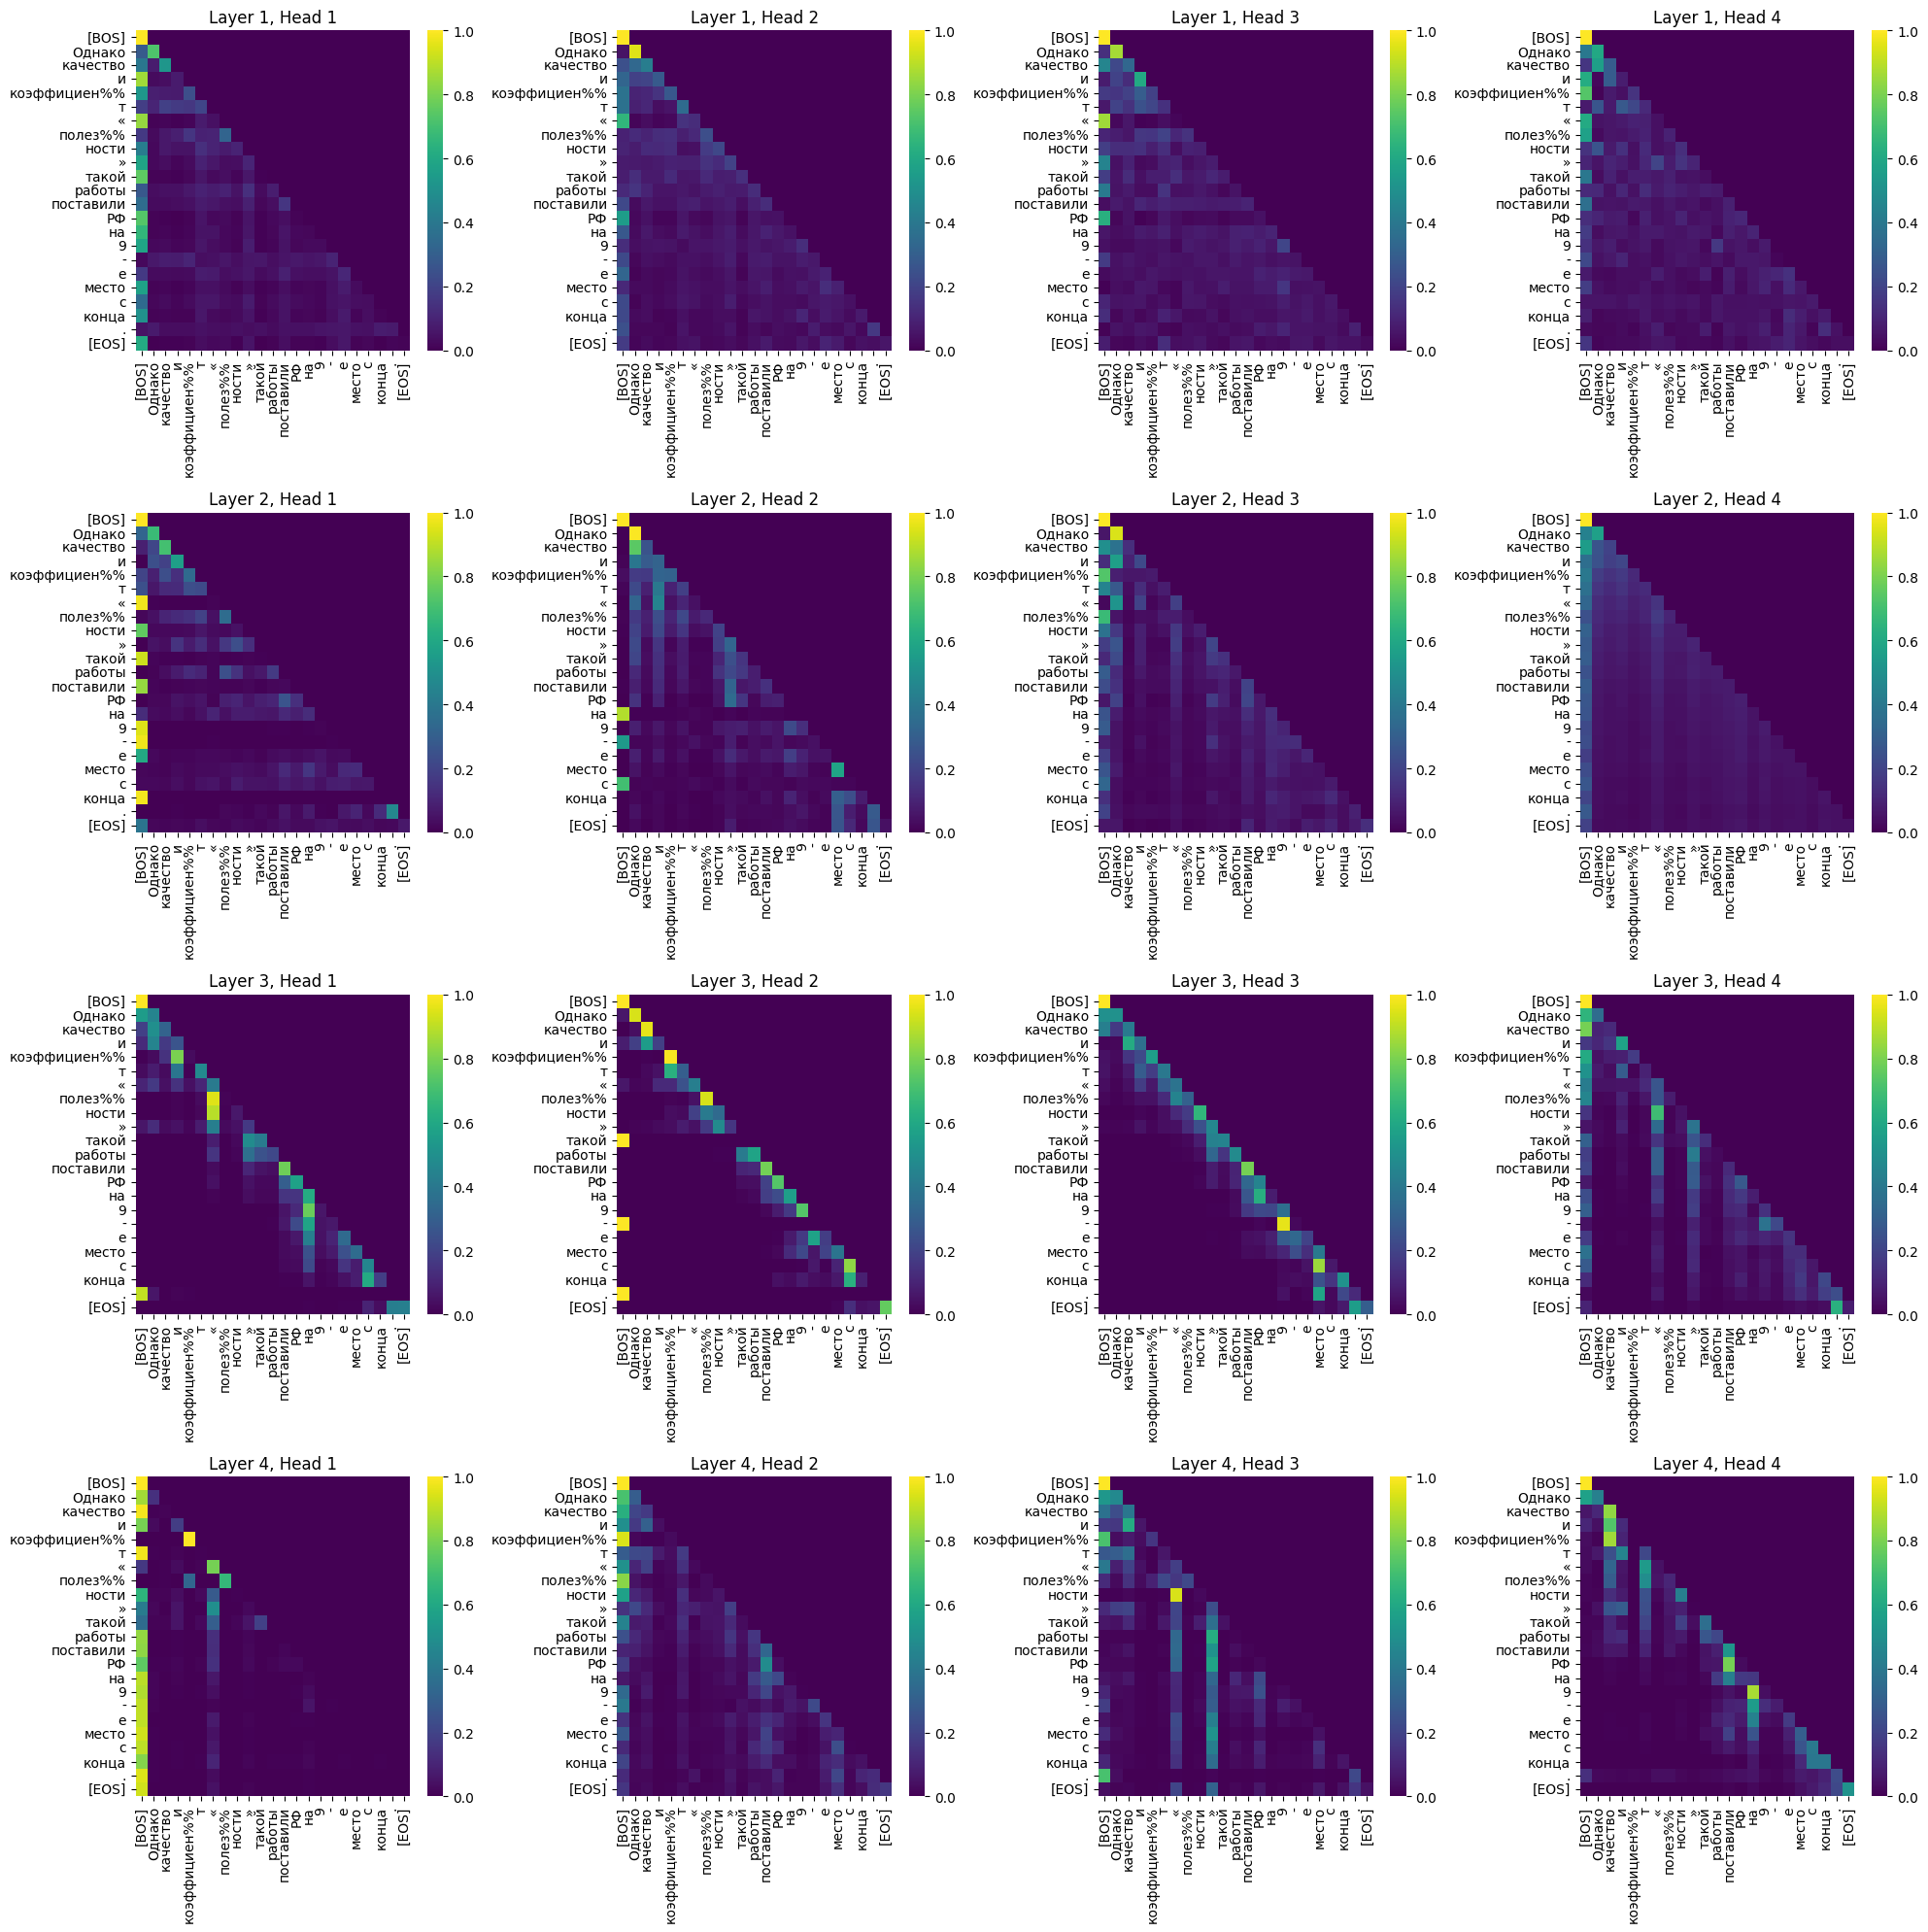

Epoch 4:


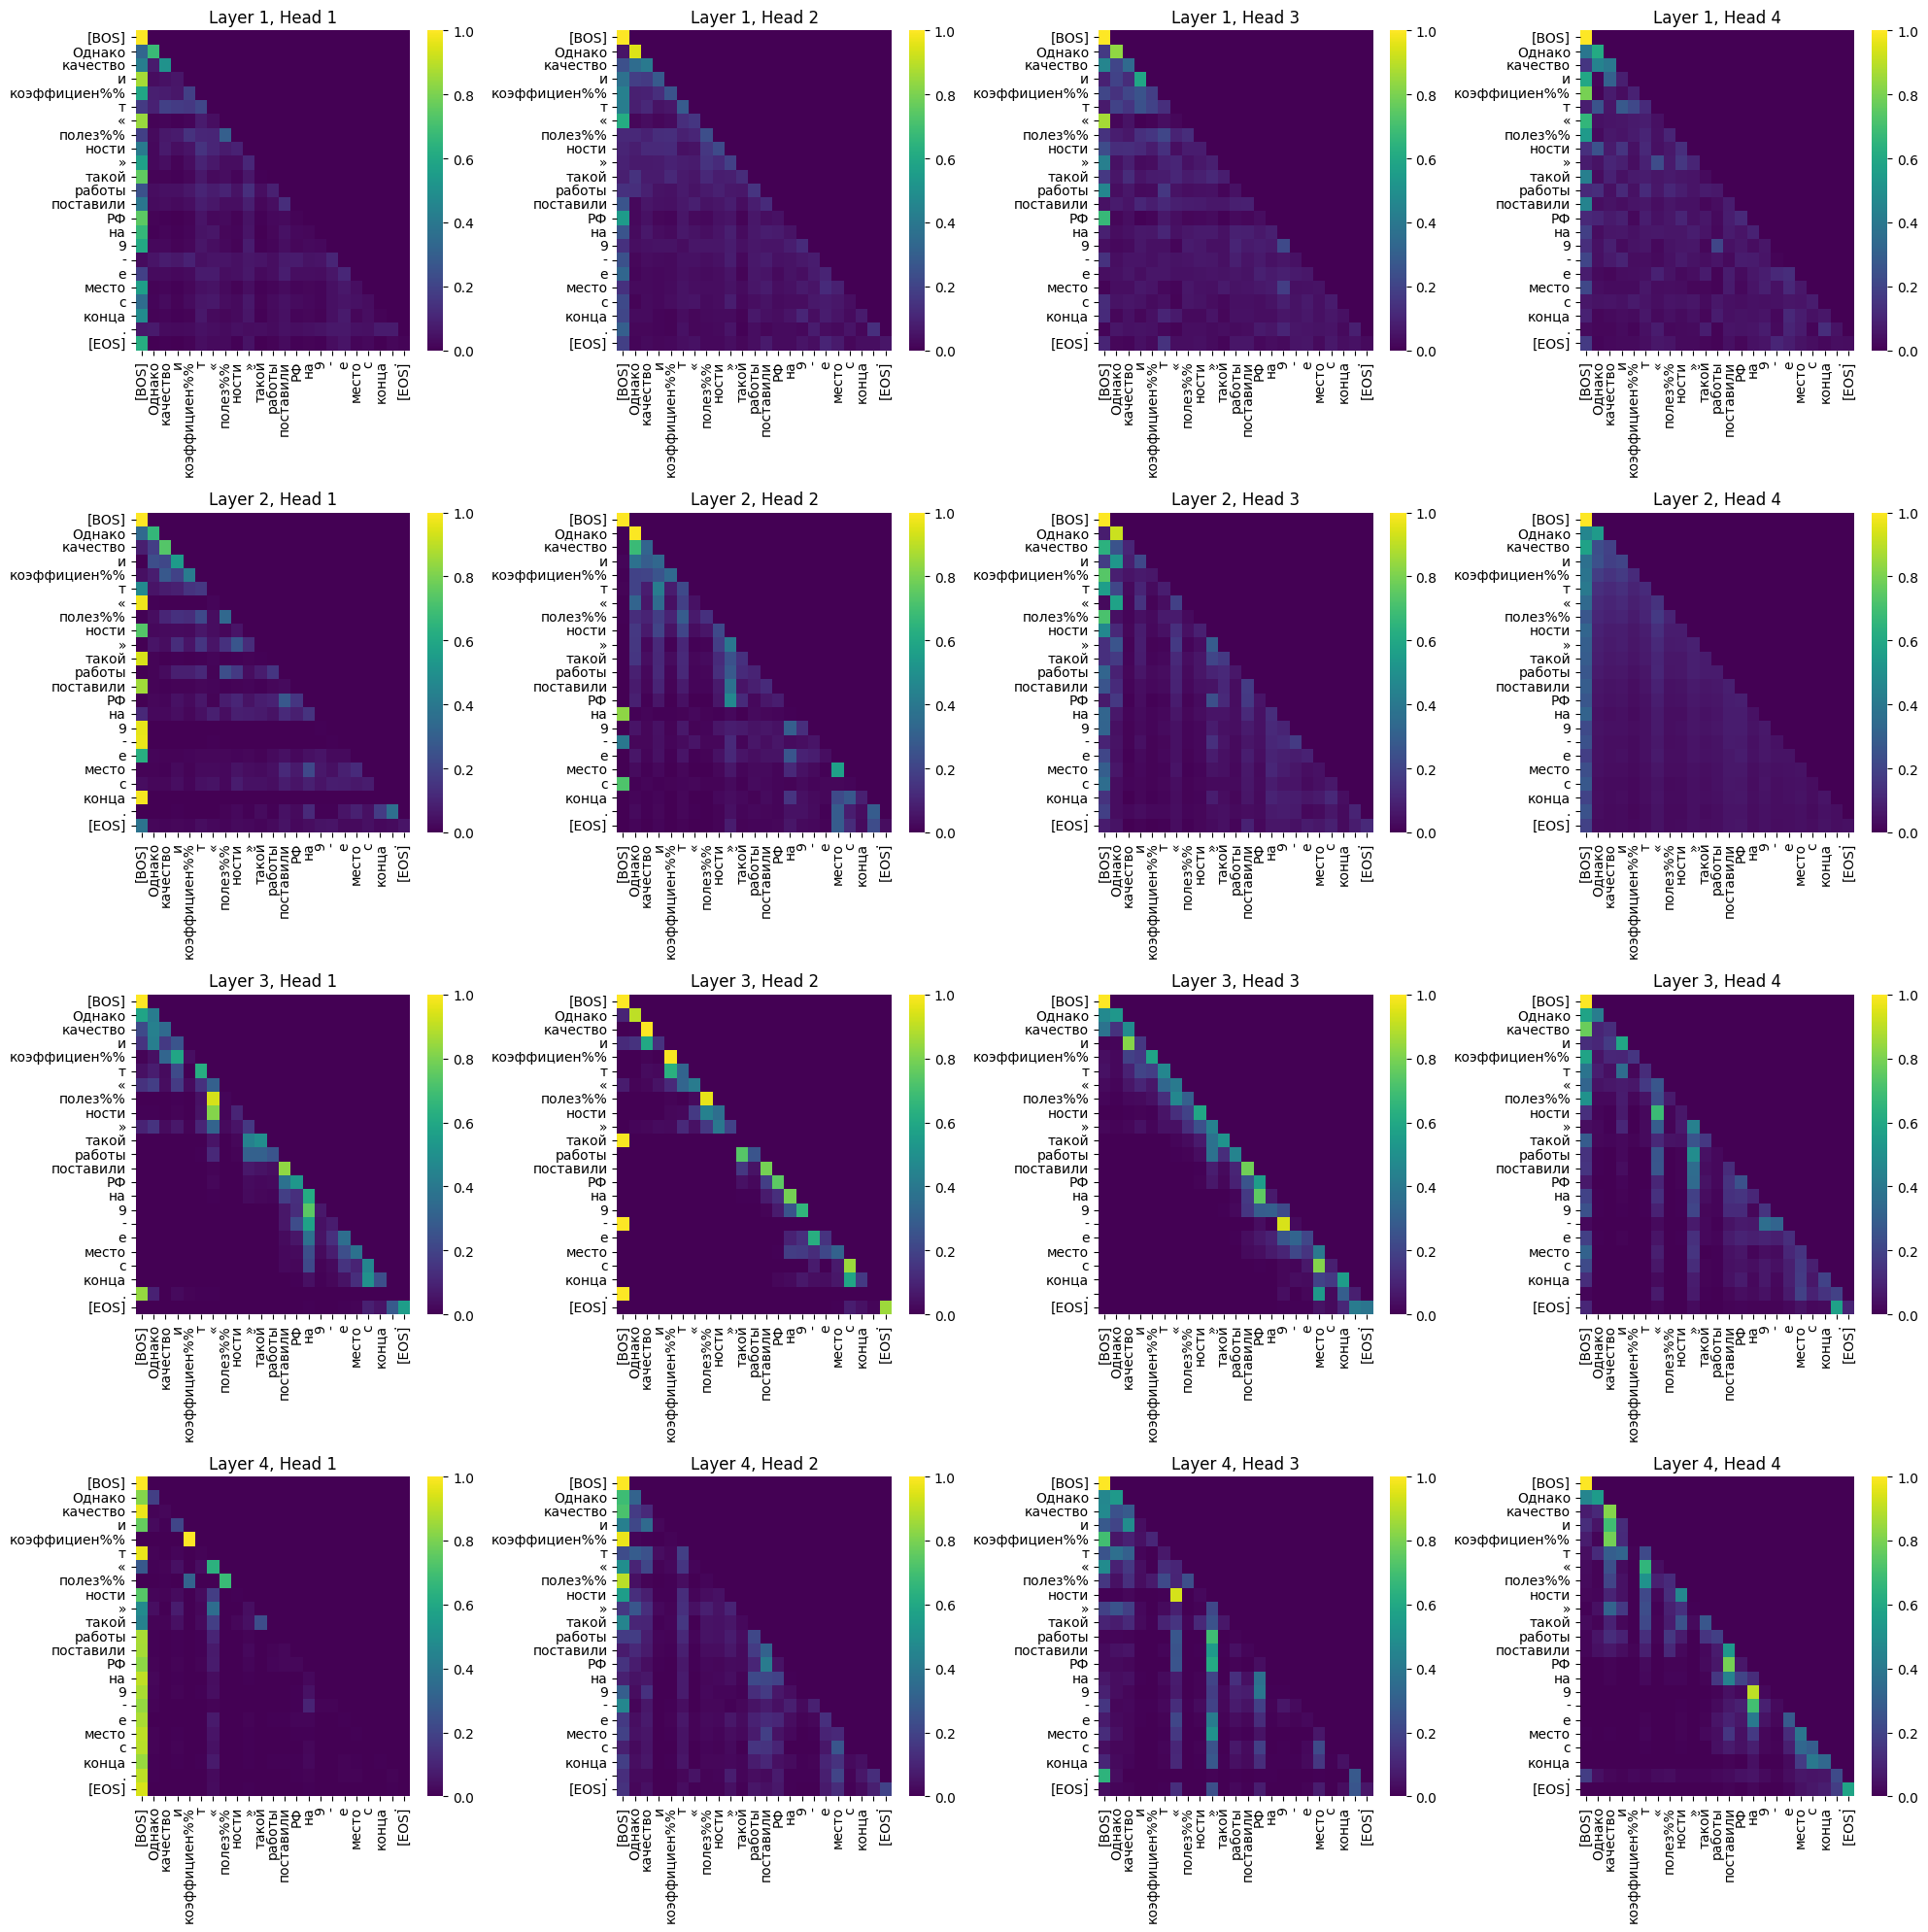

Epoch 5:


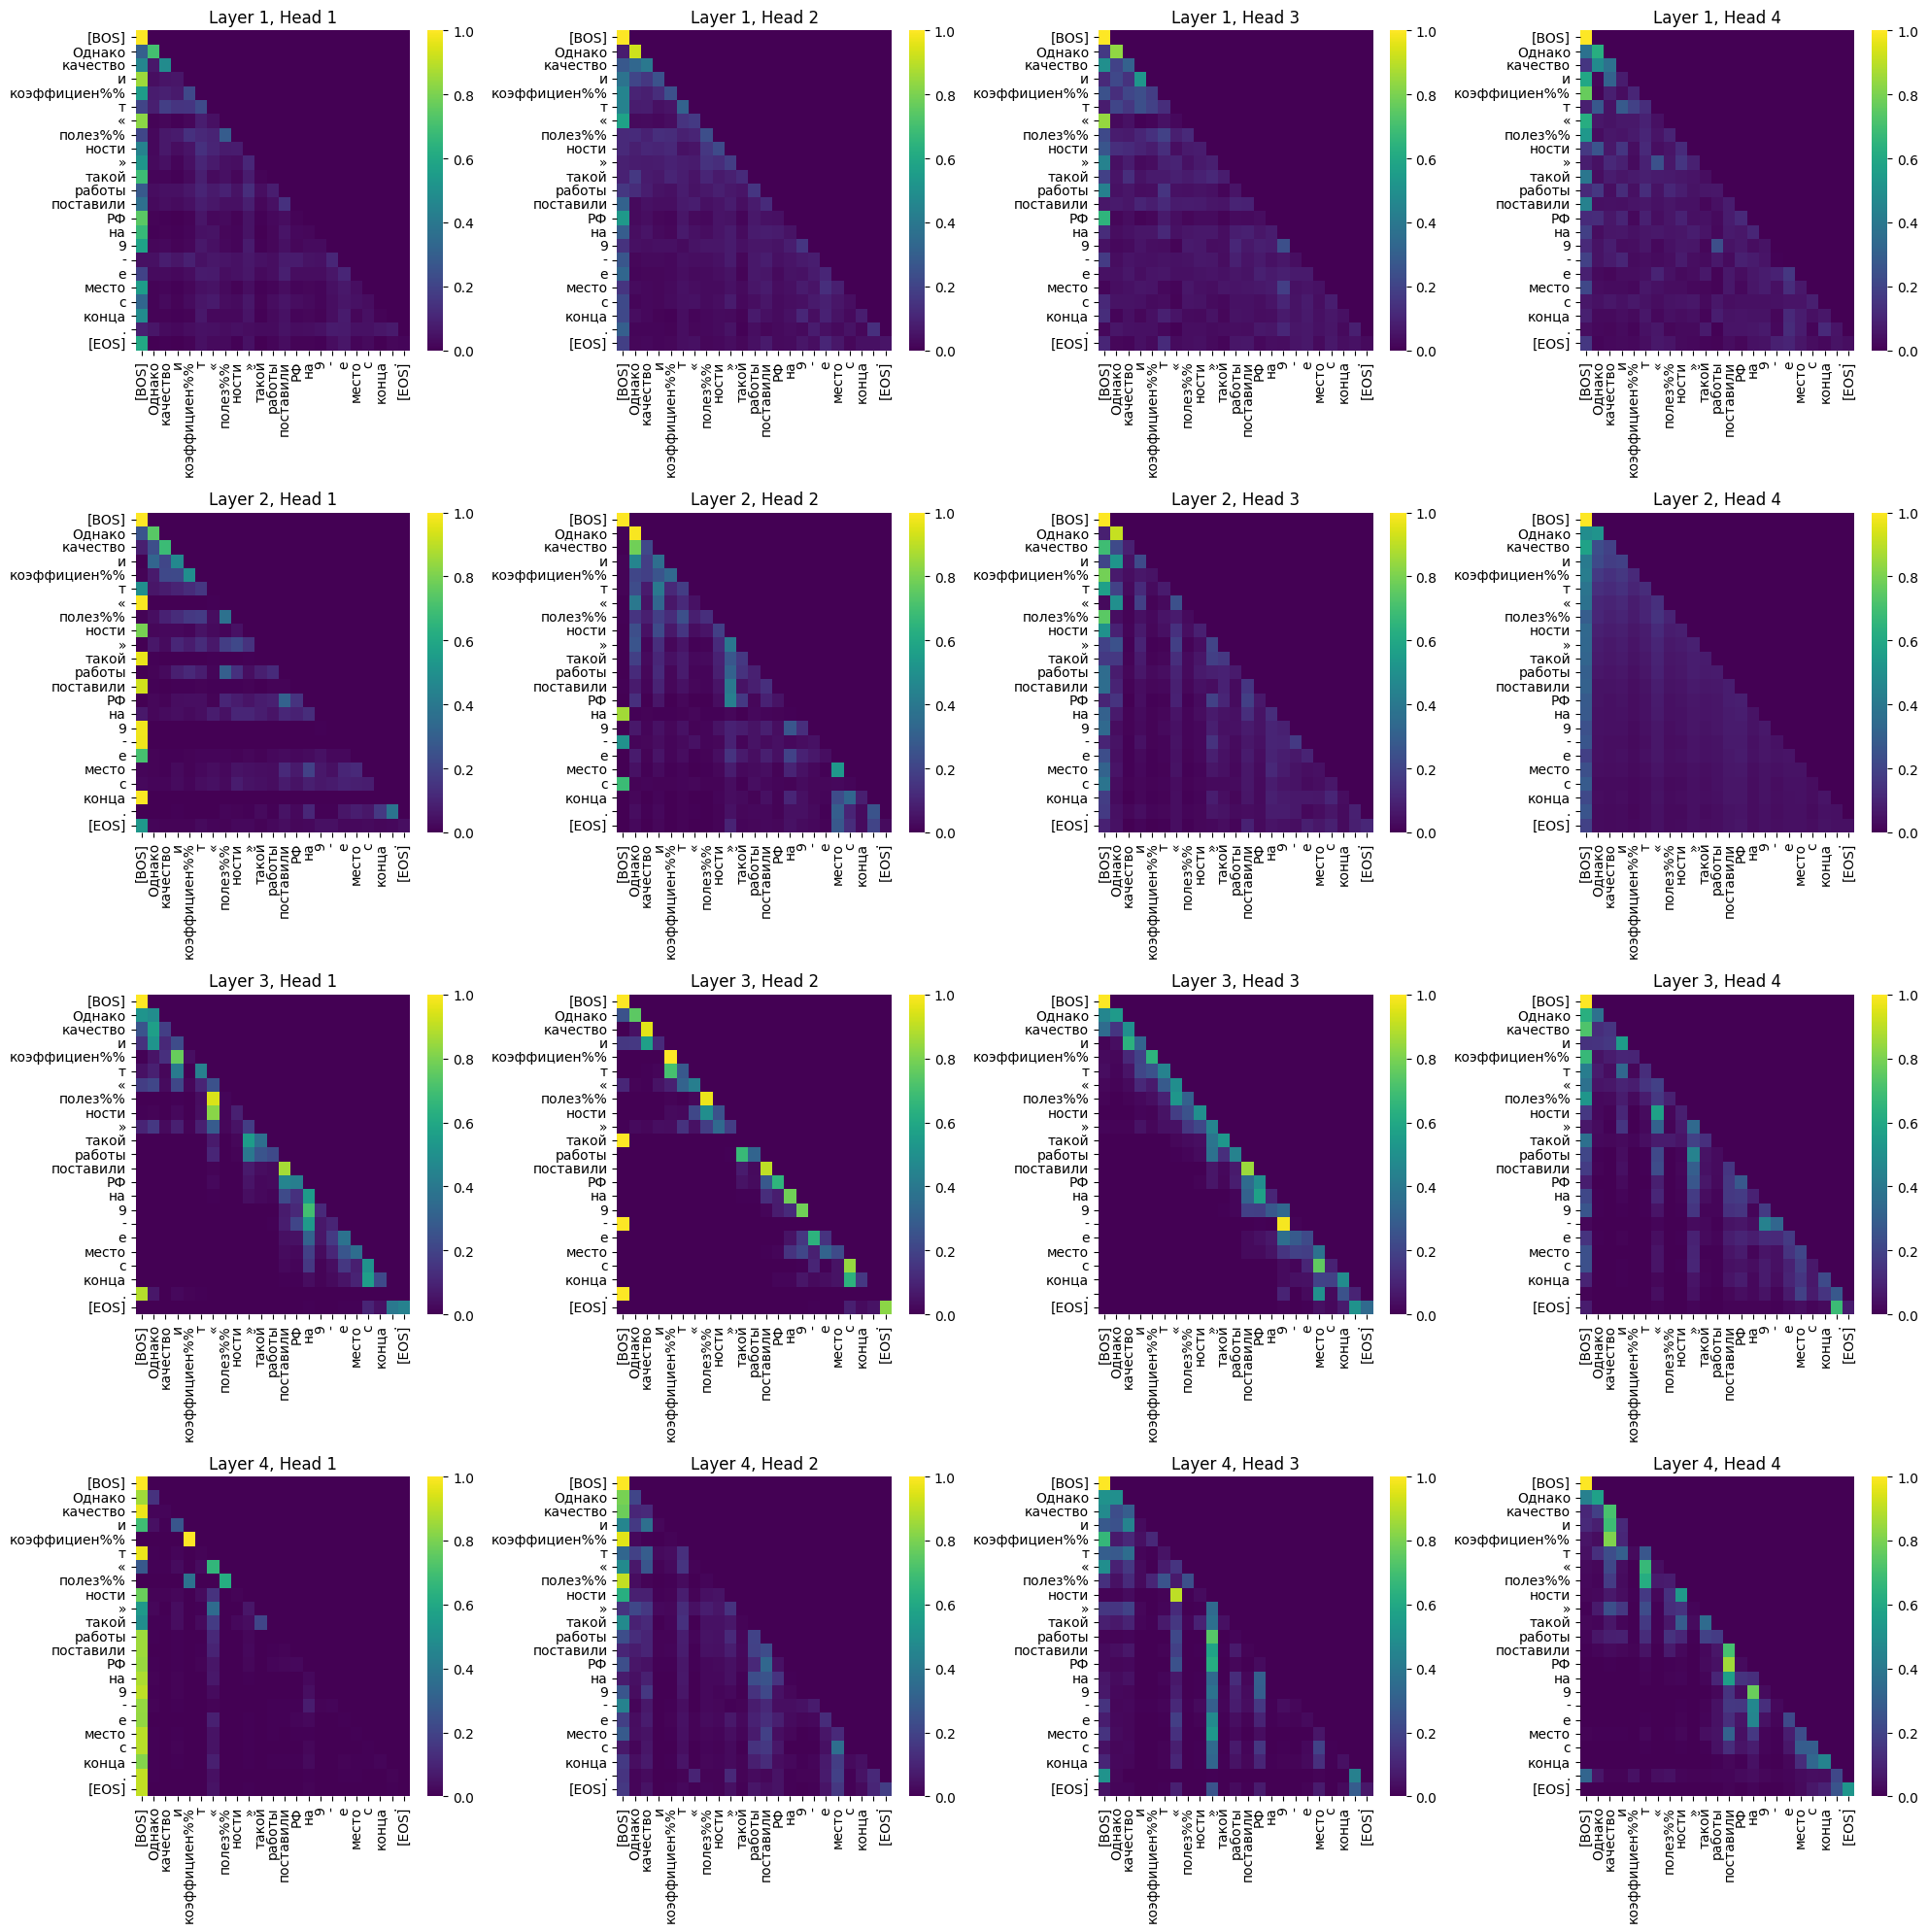

Epoch 6:


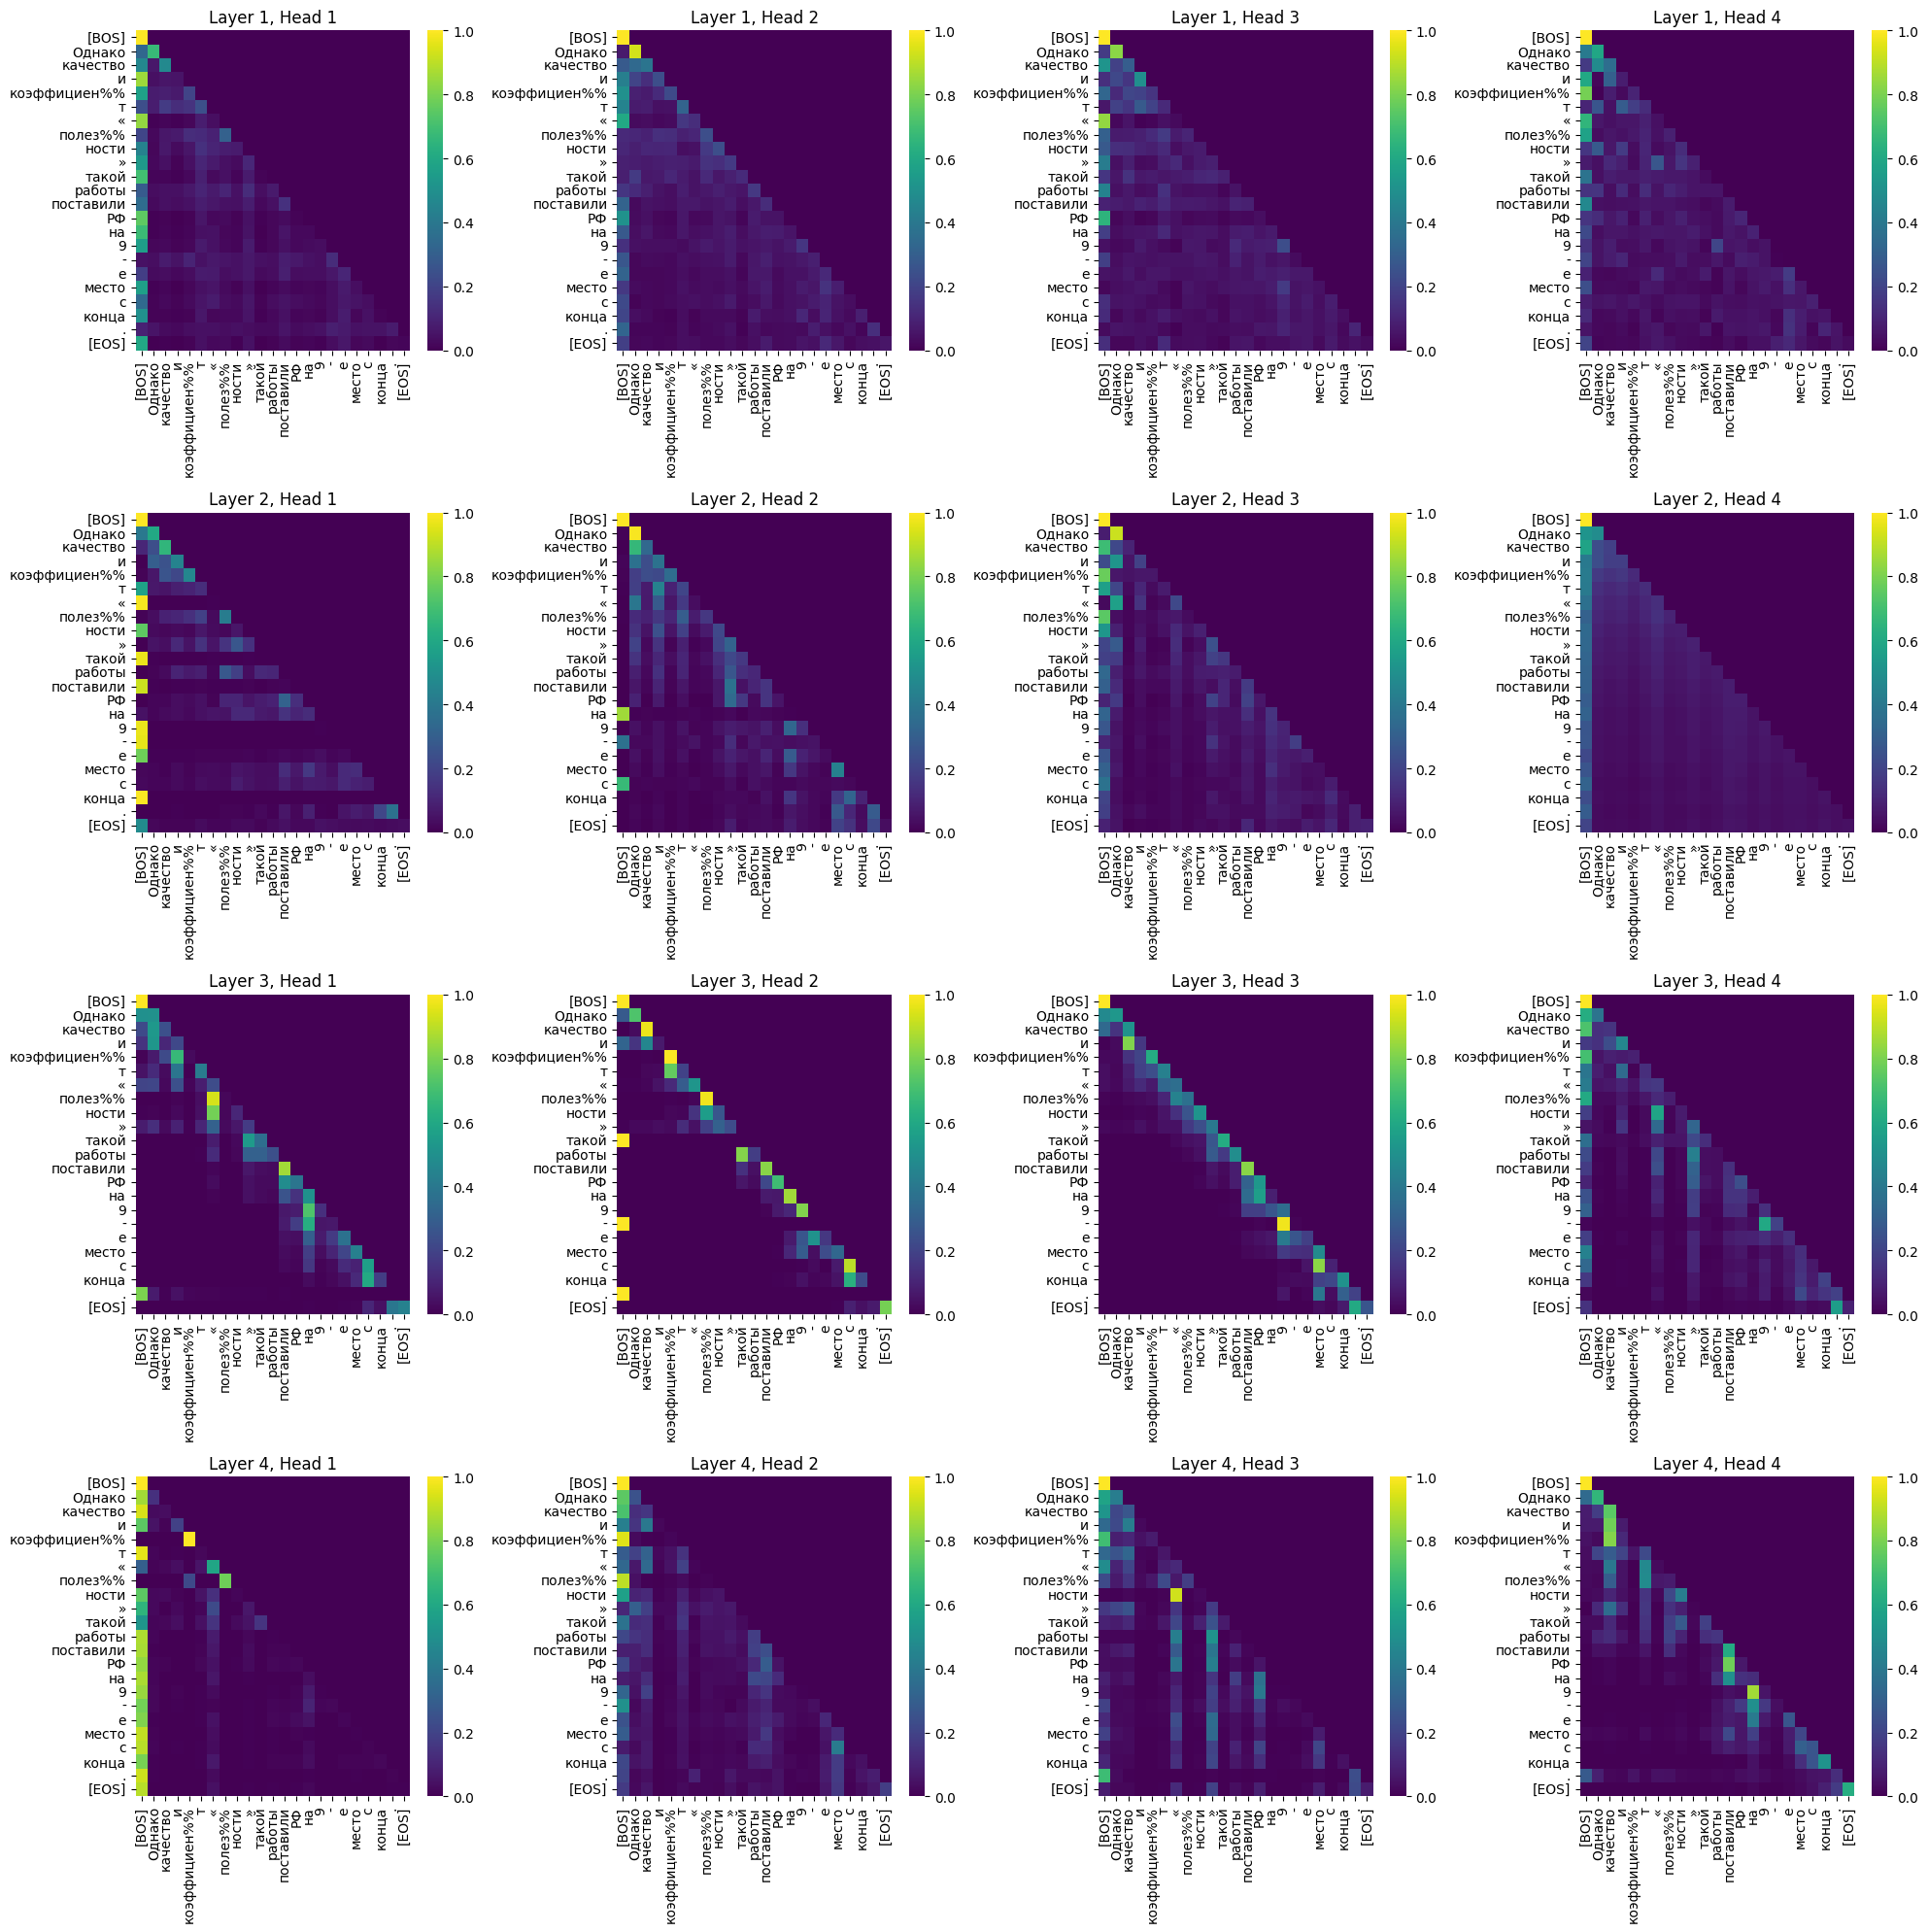

Epoch 7:


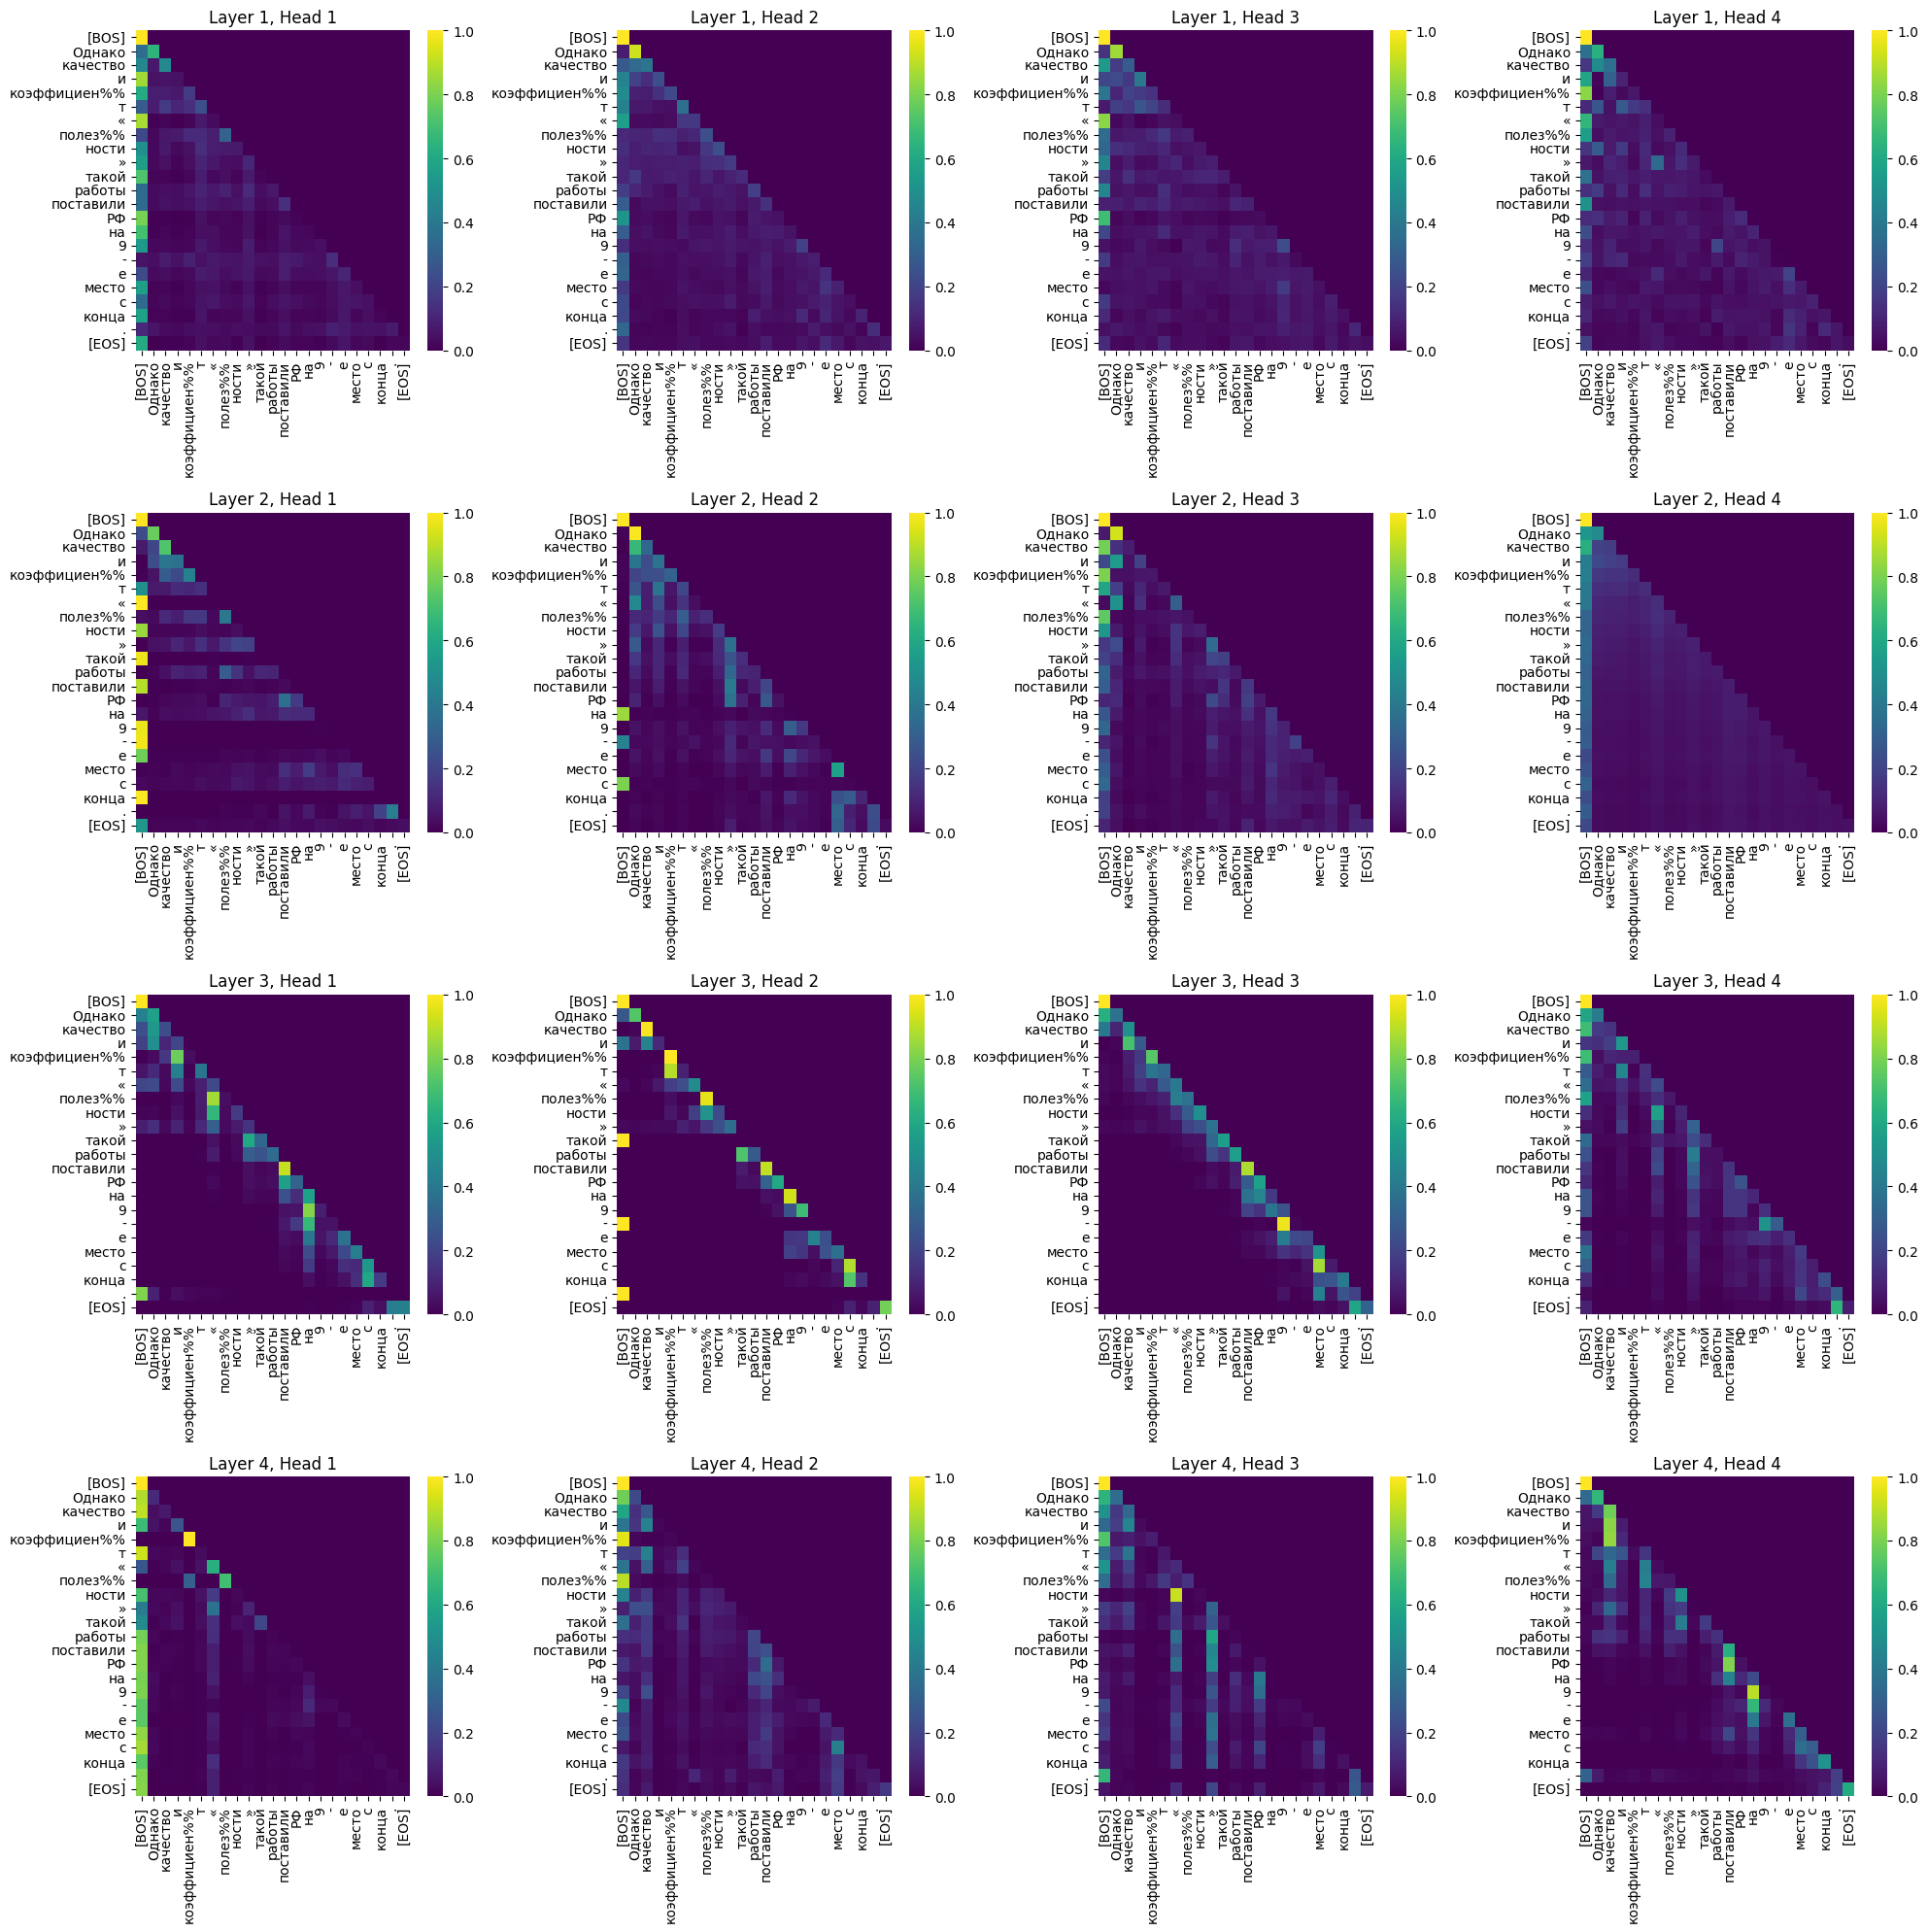

Epoch 8:


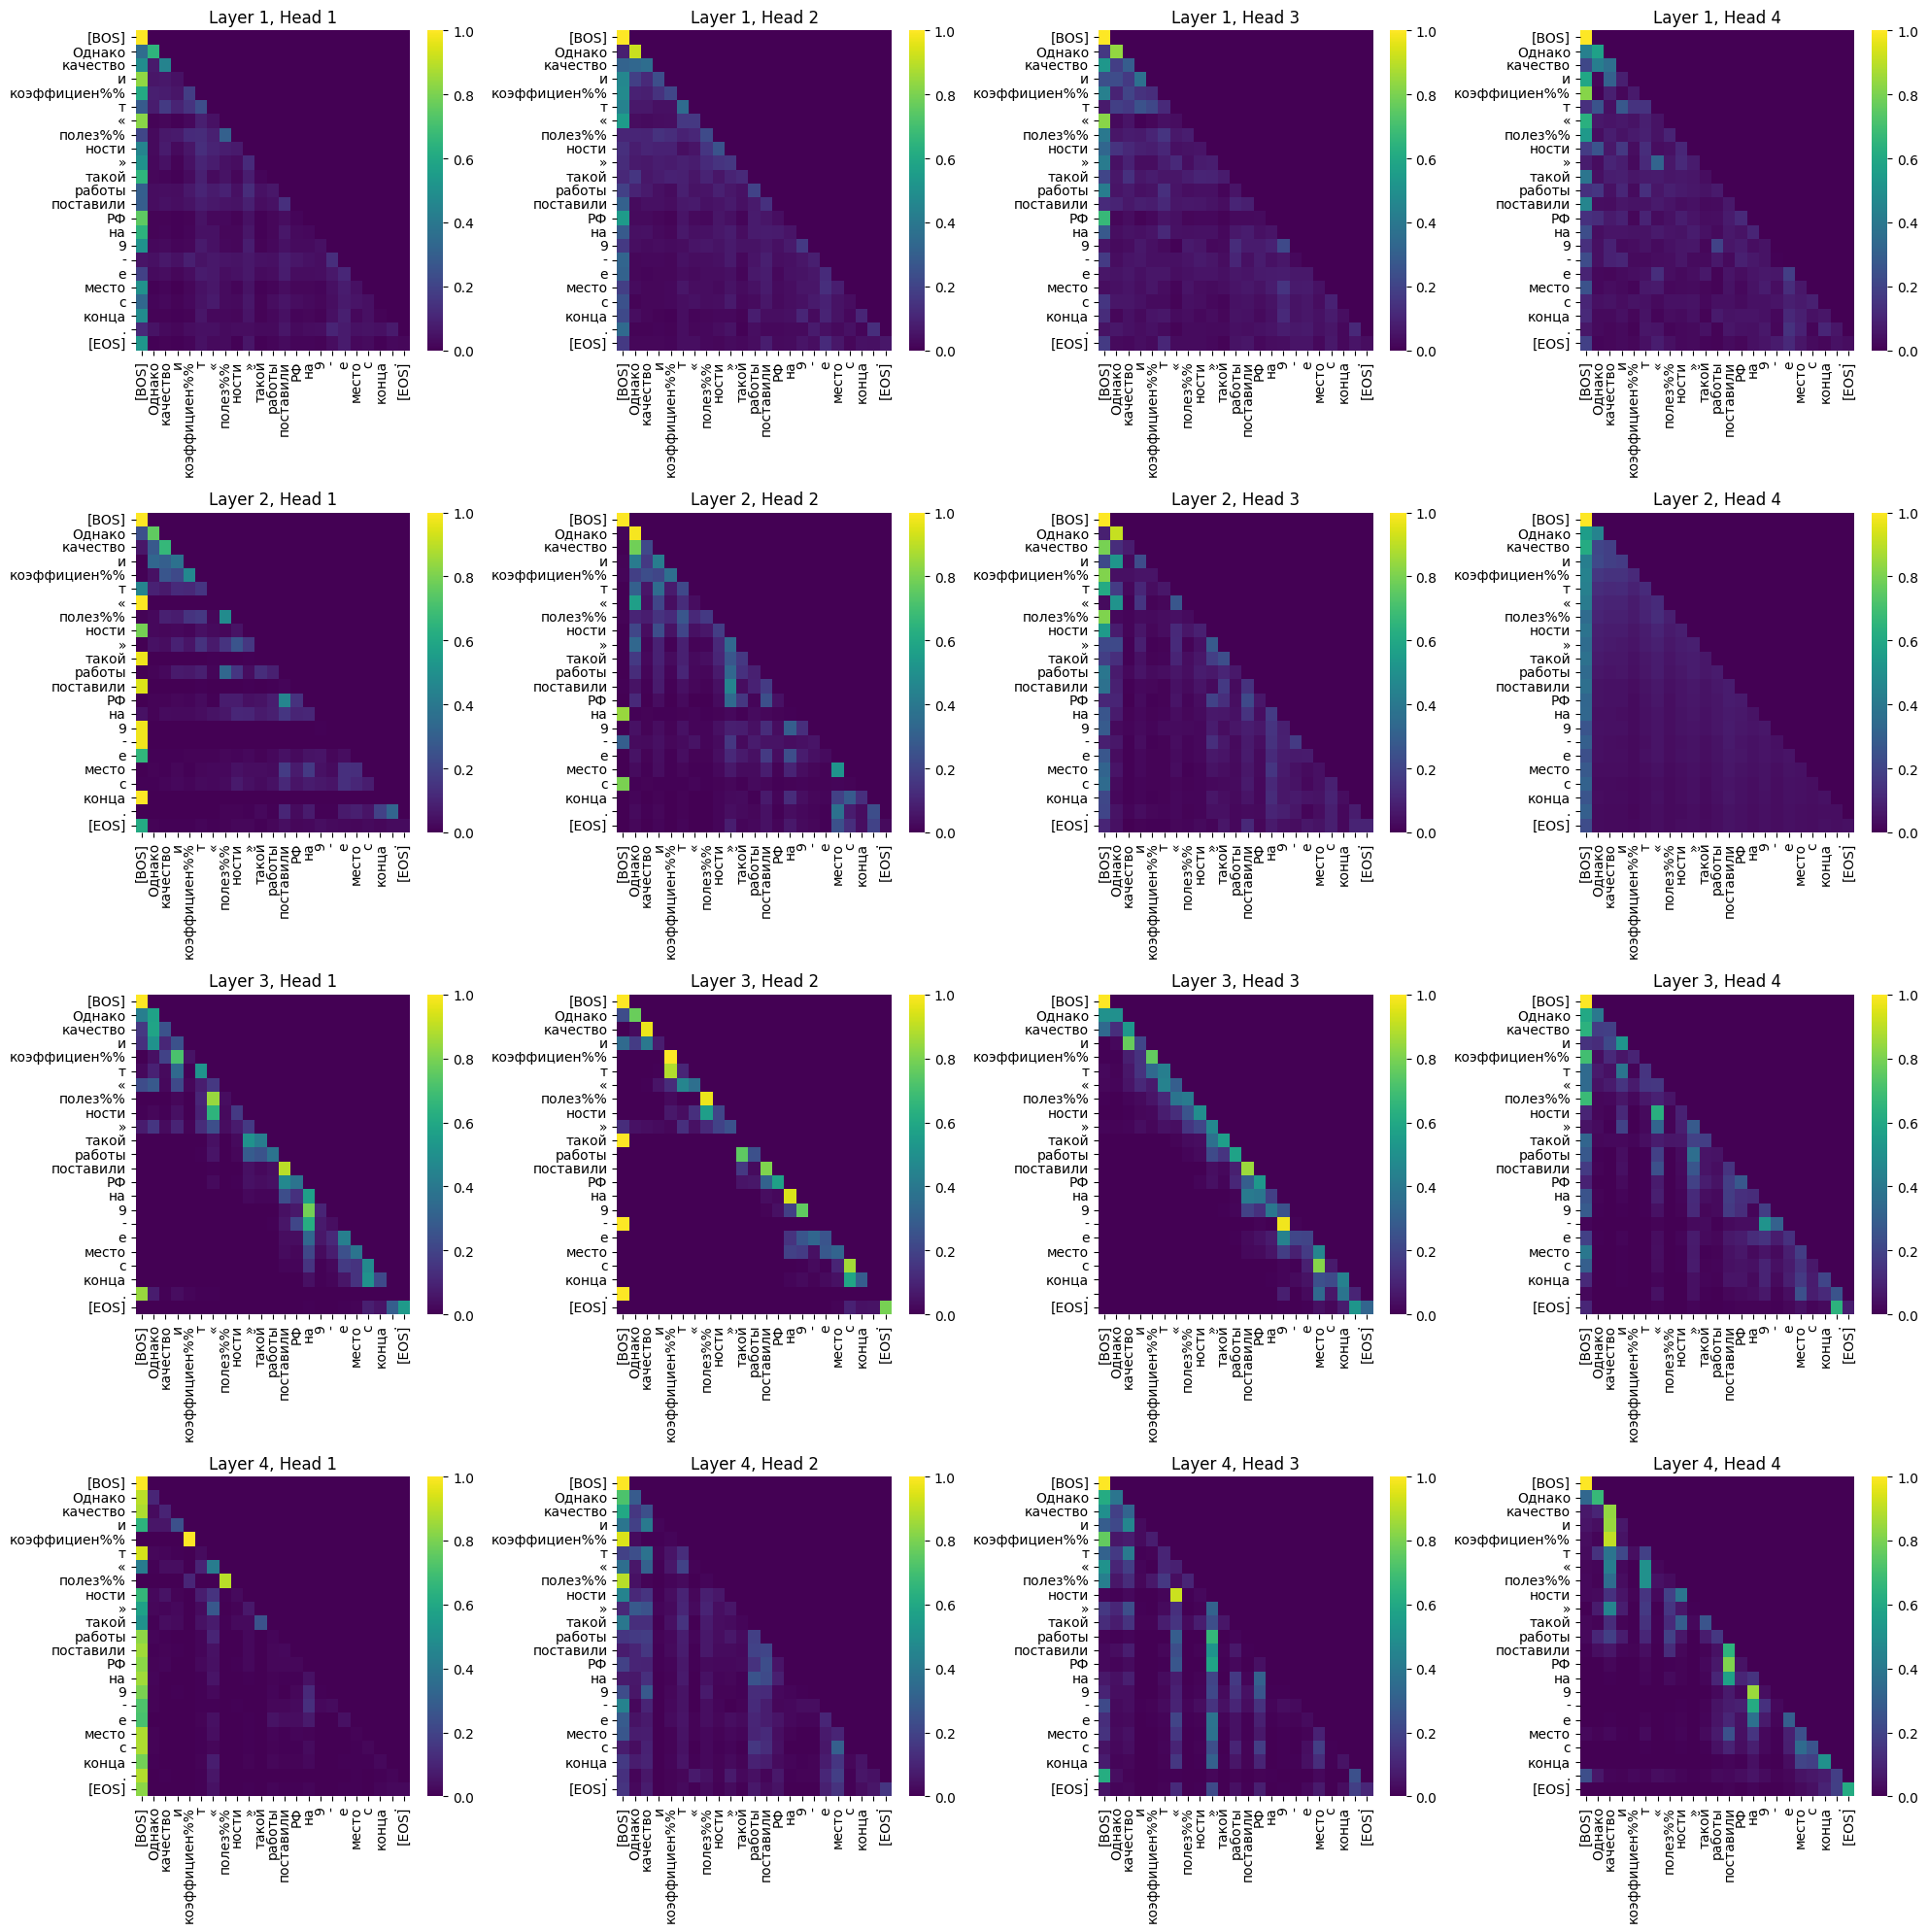

Epoch 9:


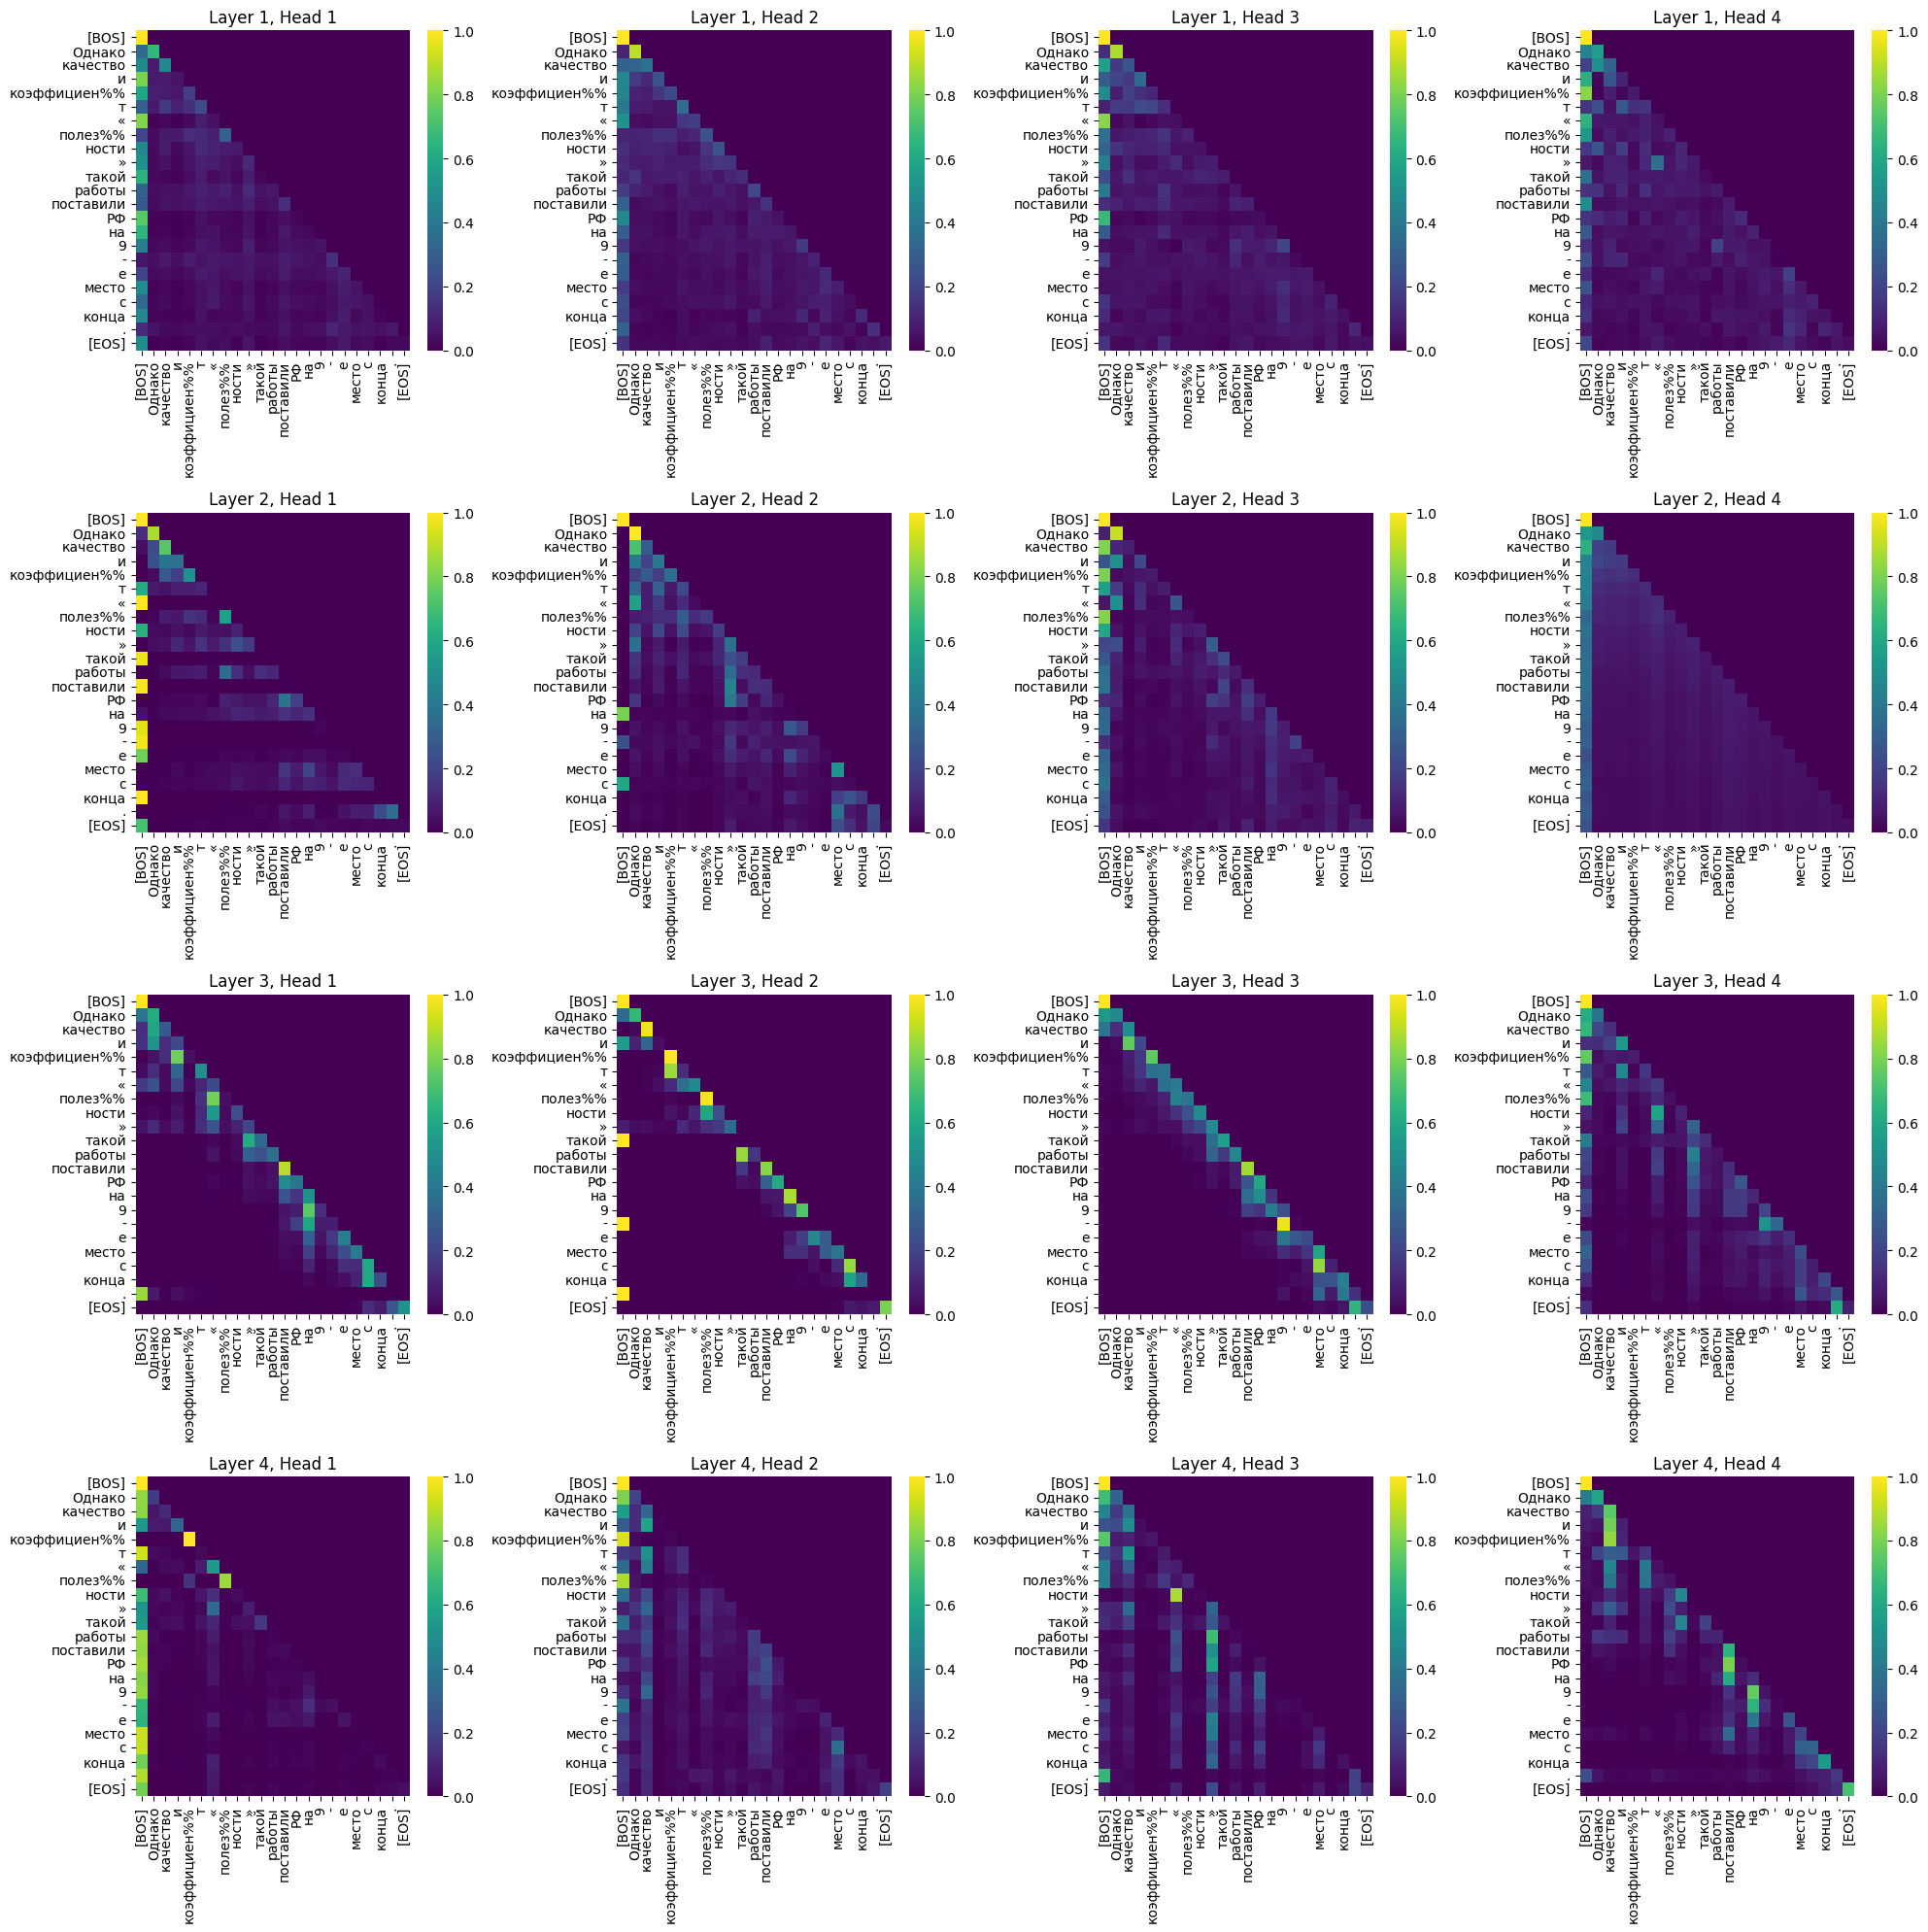

Epoch 10:


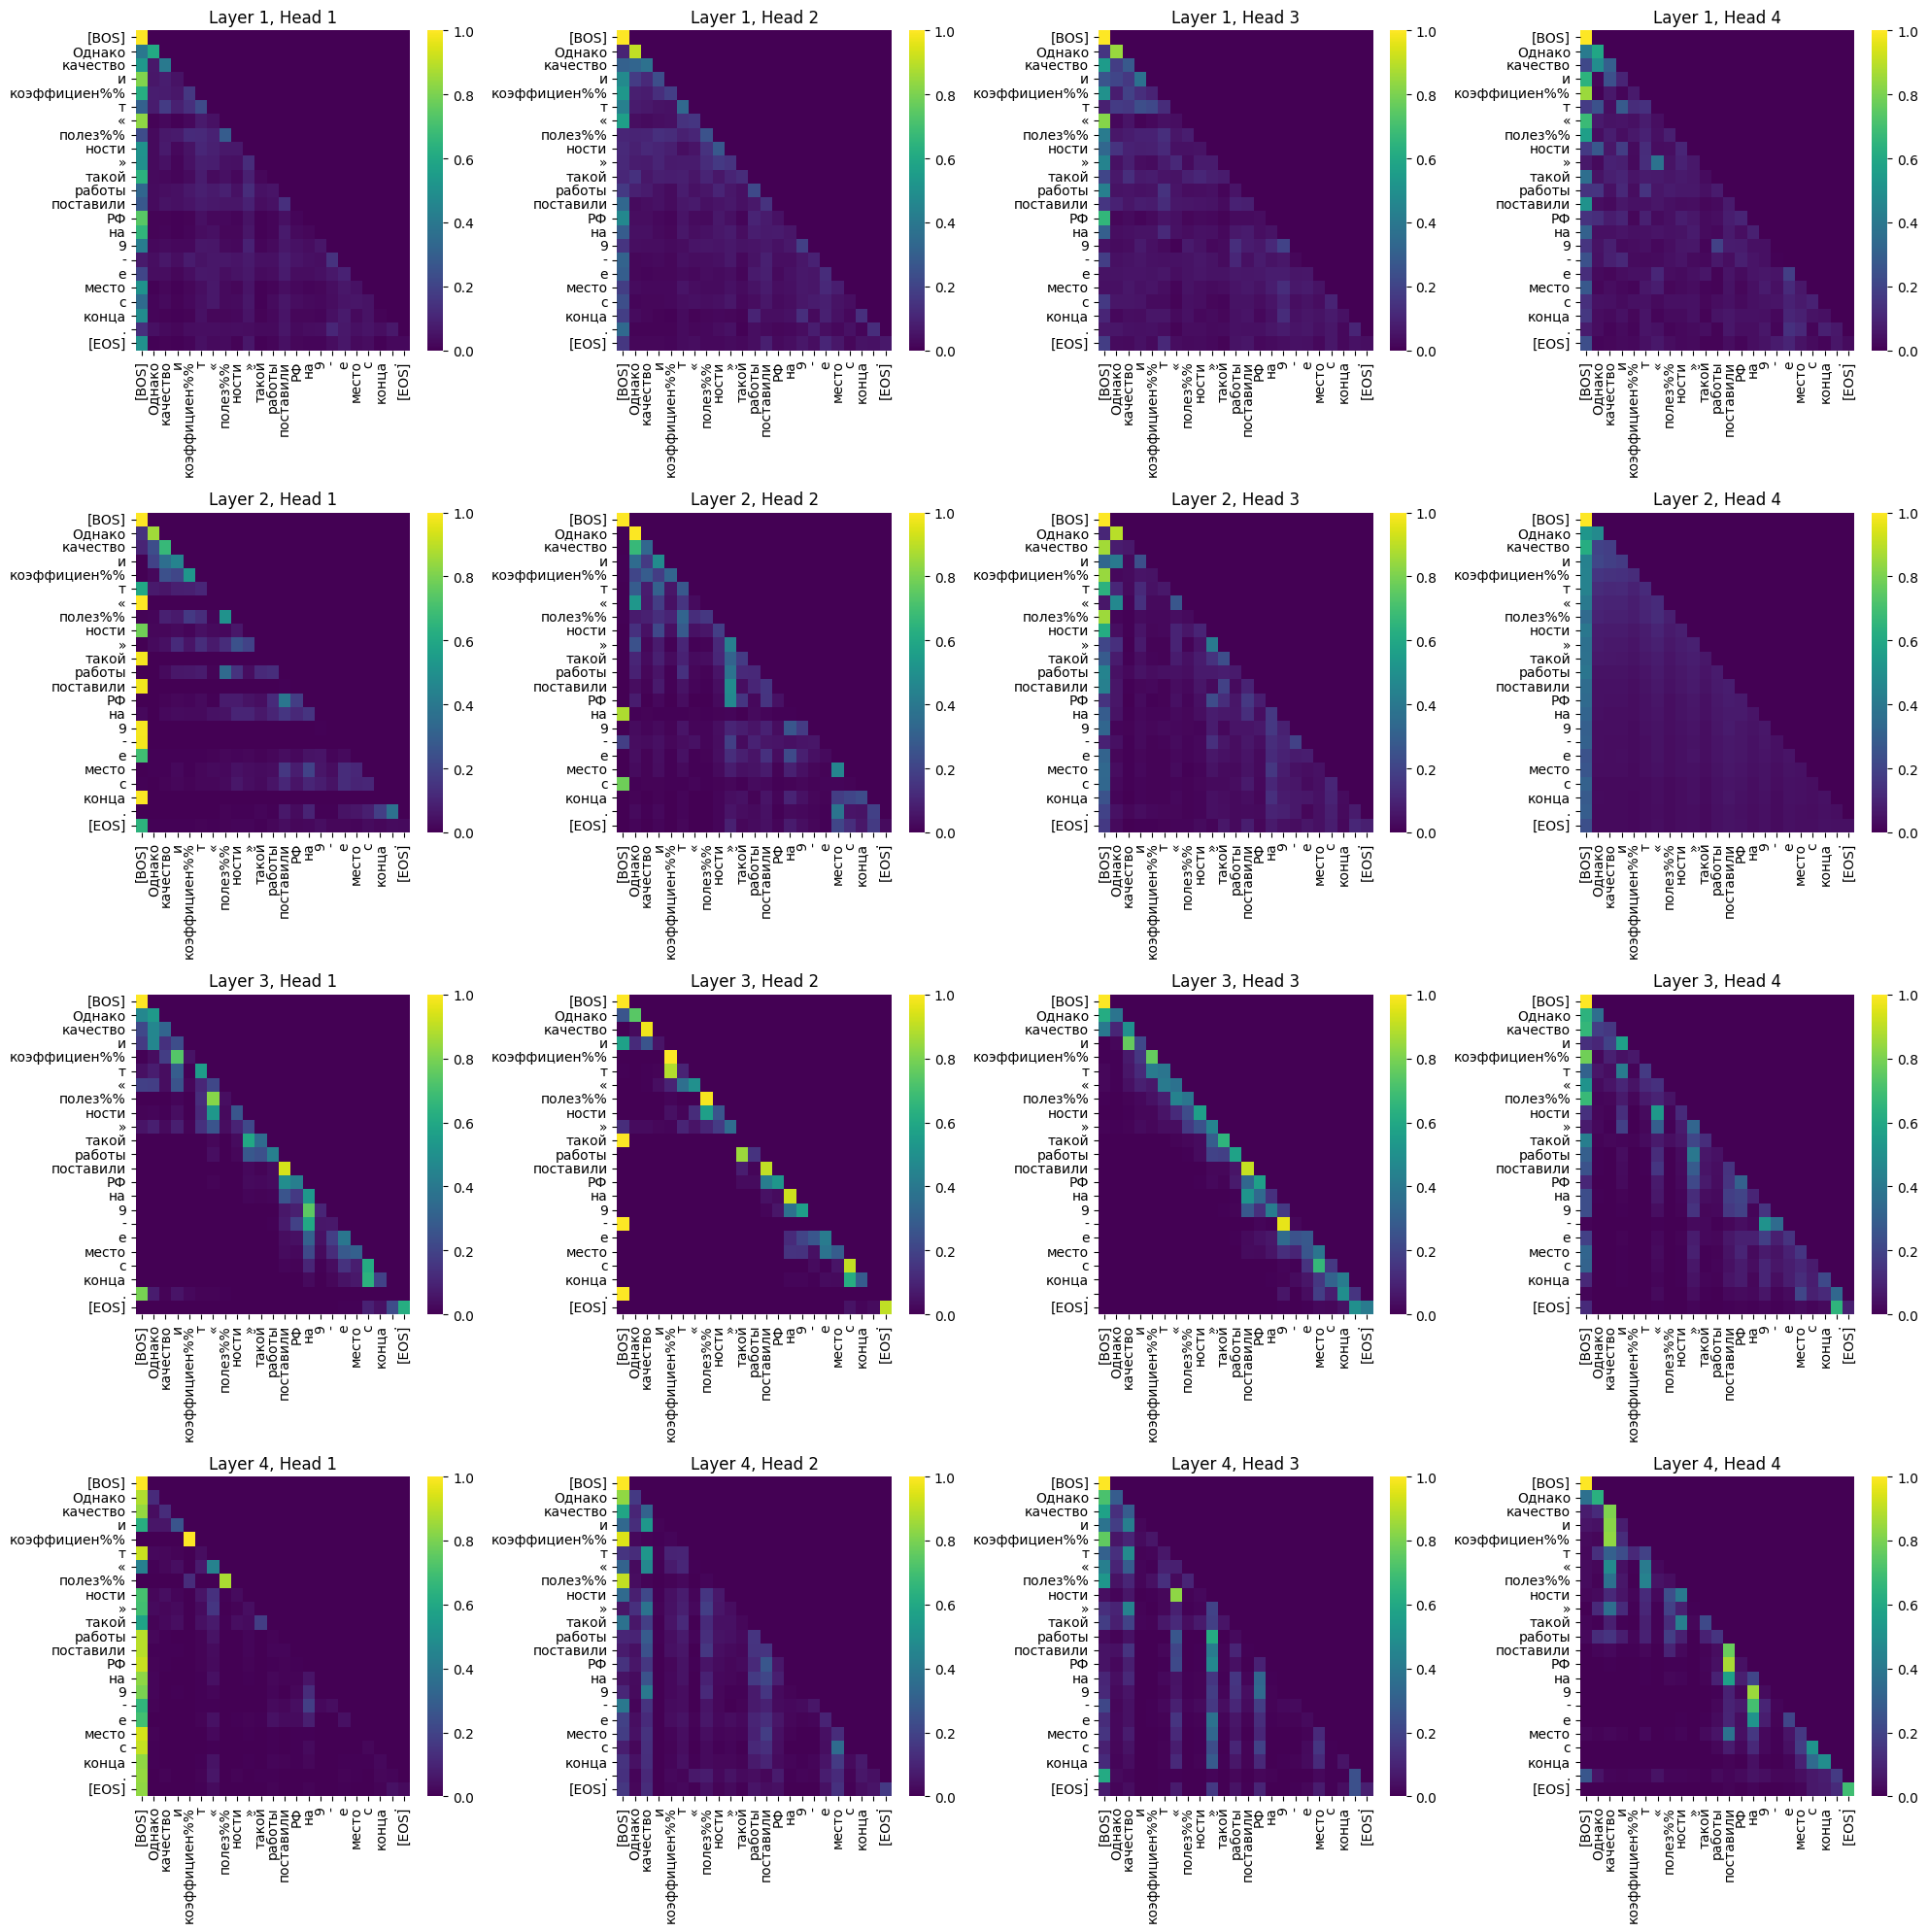

Epoch 11:


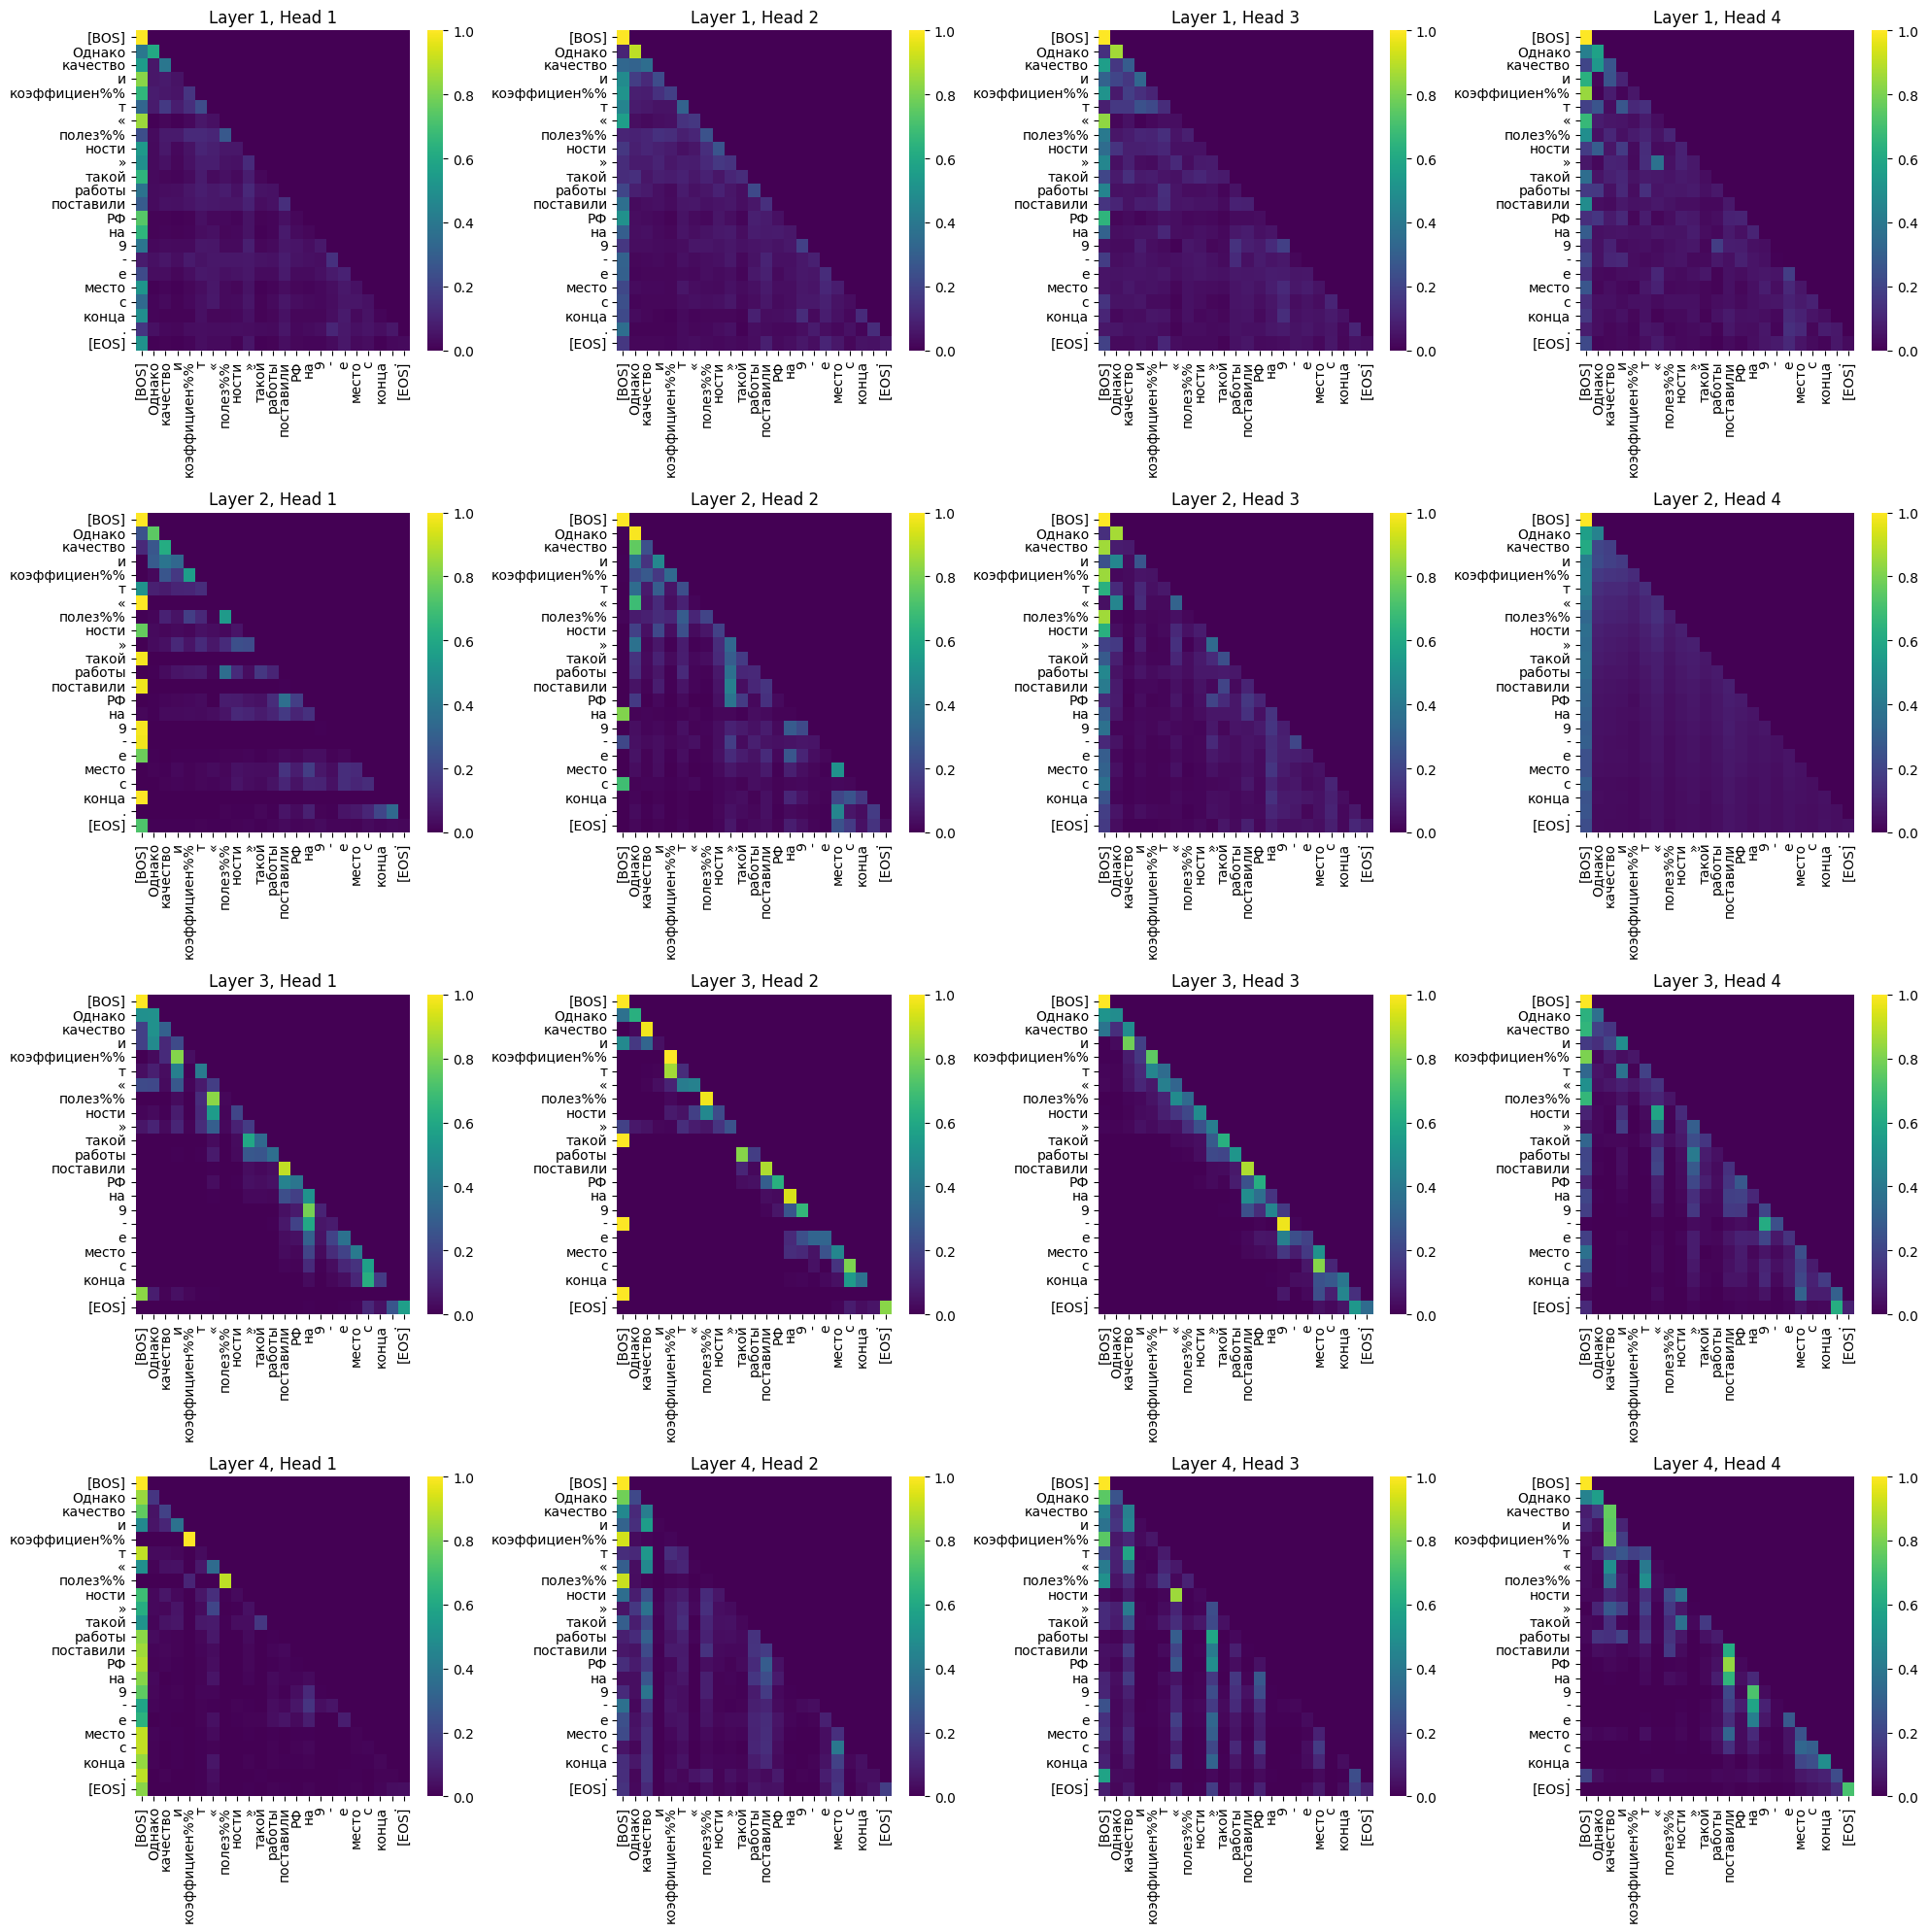

Epoch 12:


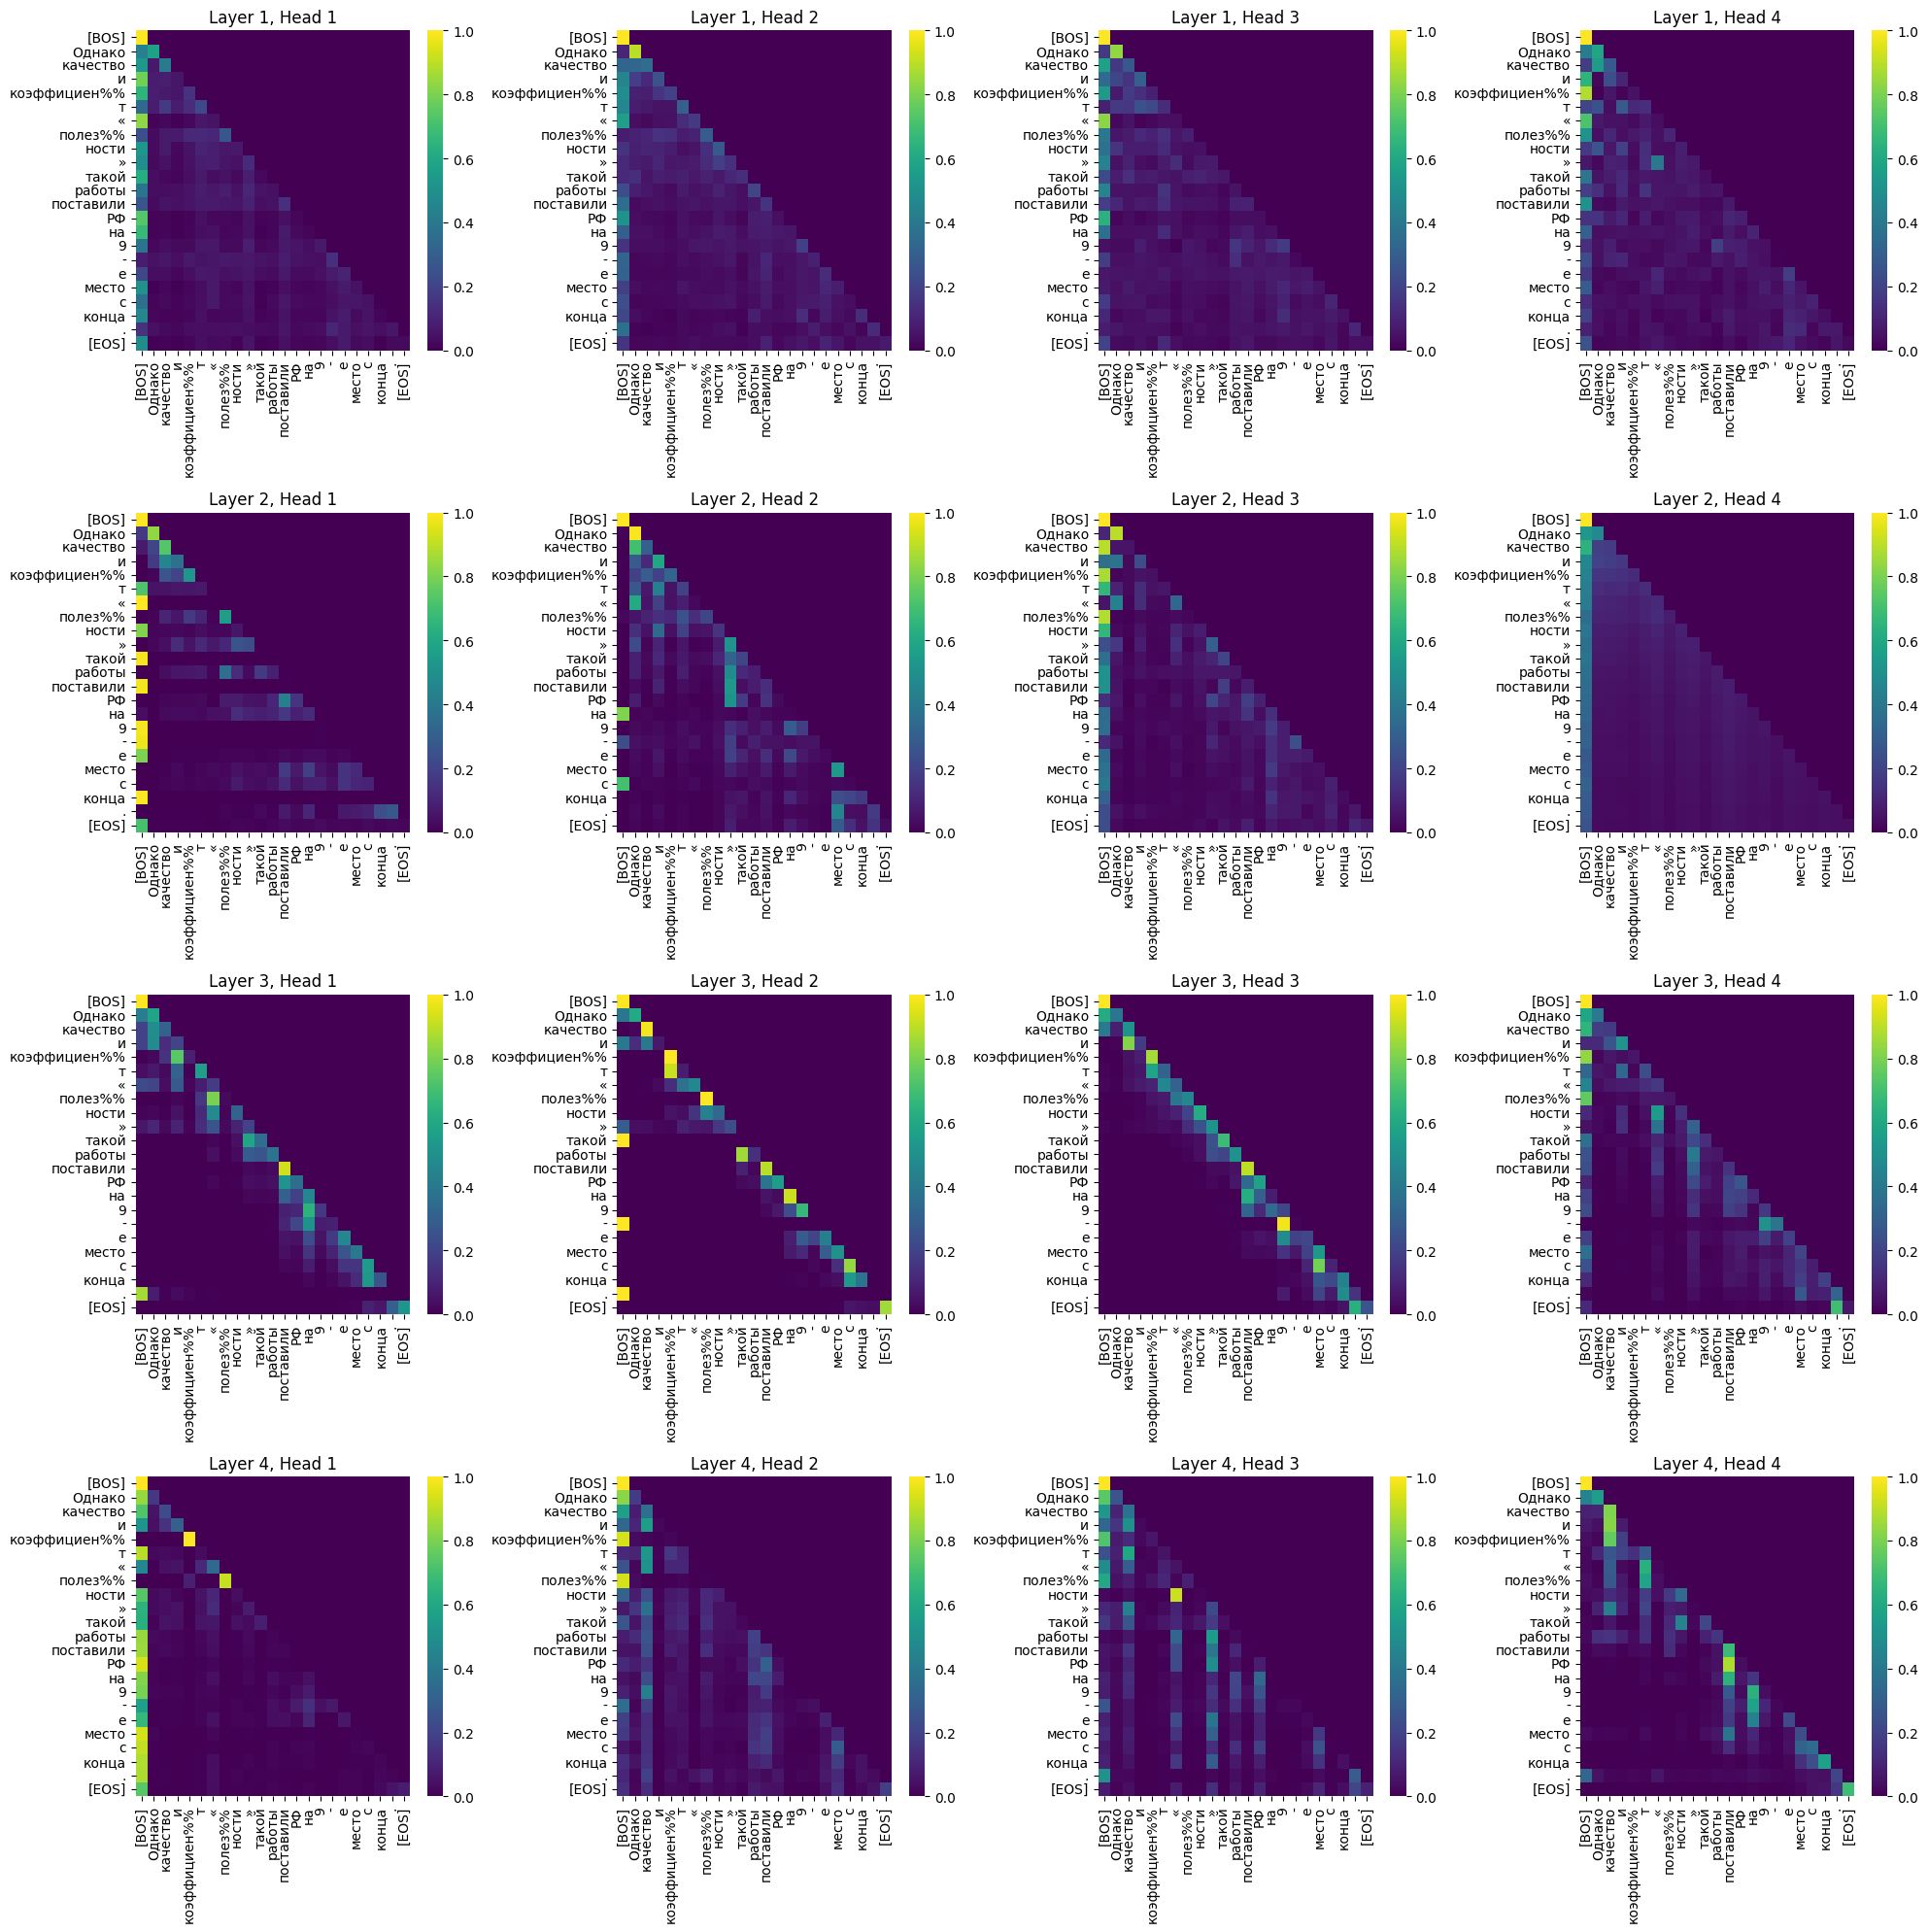

Epoch 13:


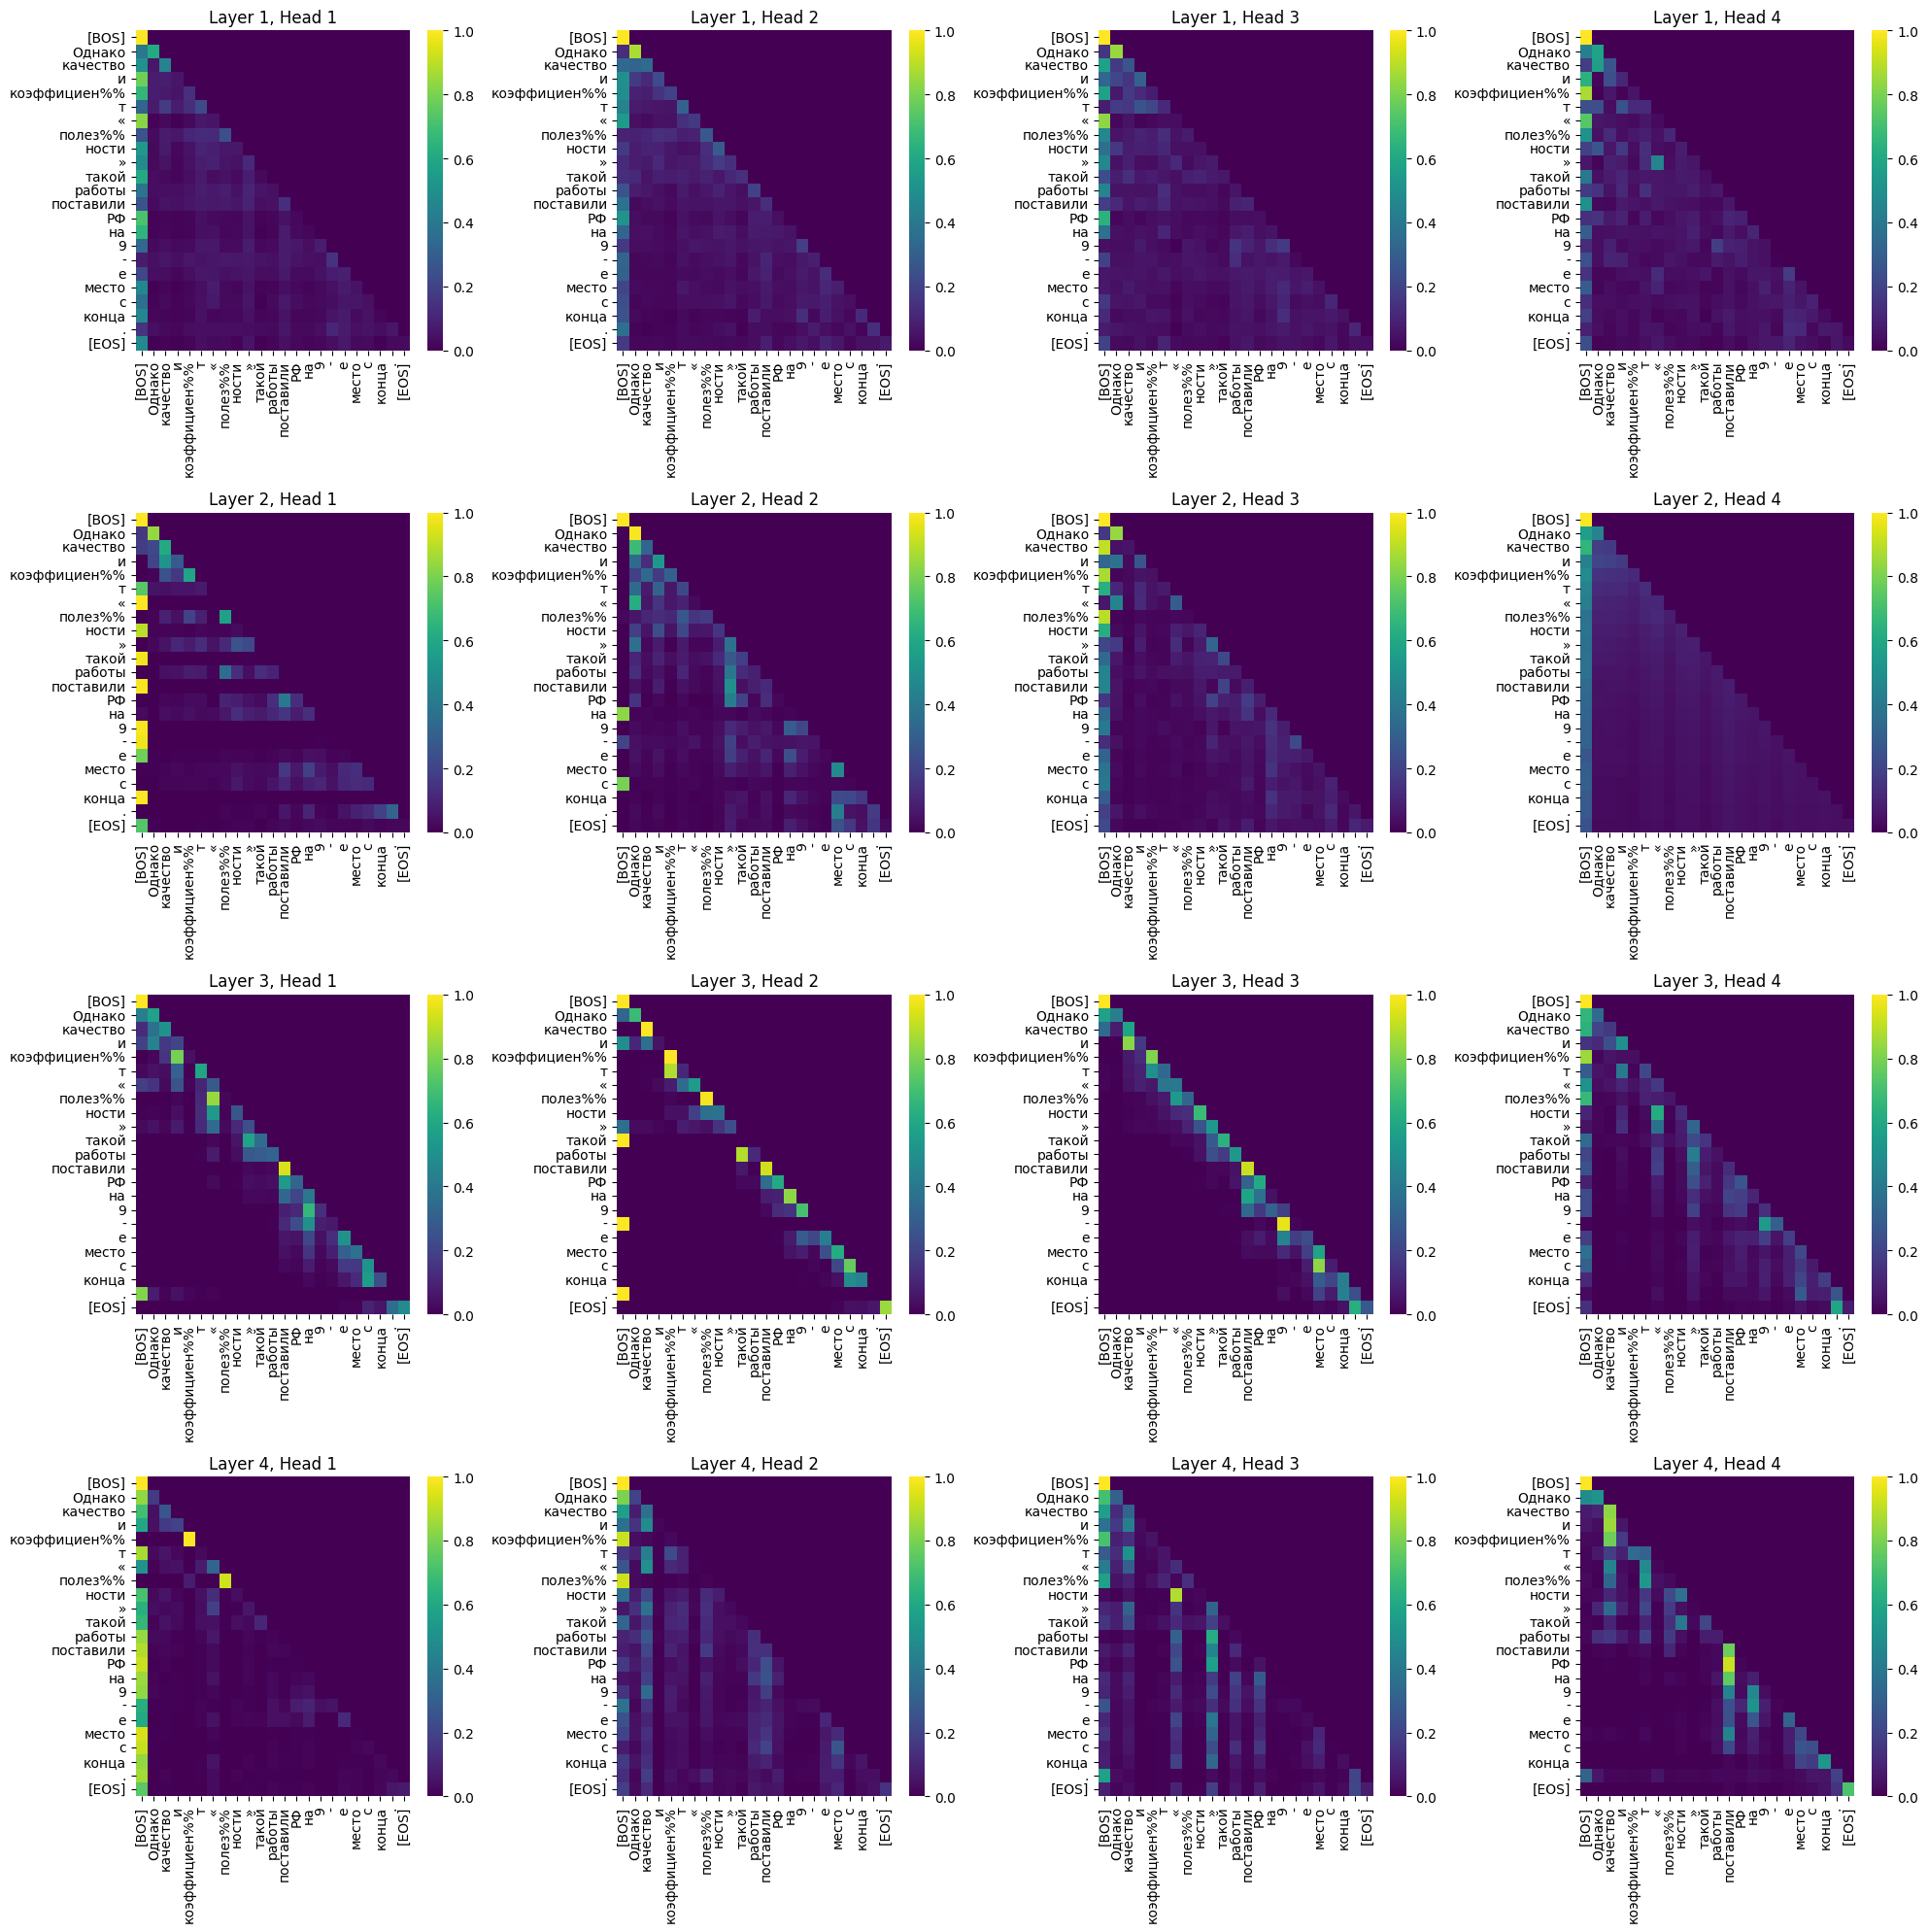

Epoch 14:


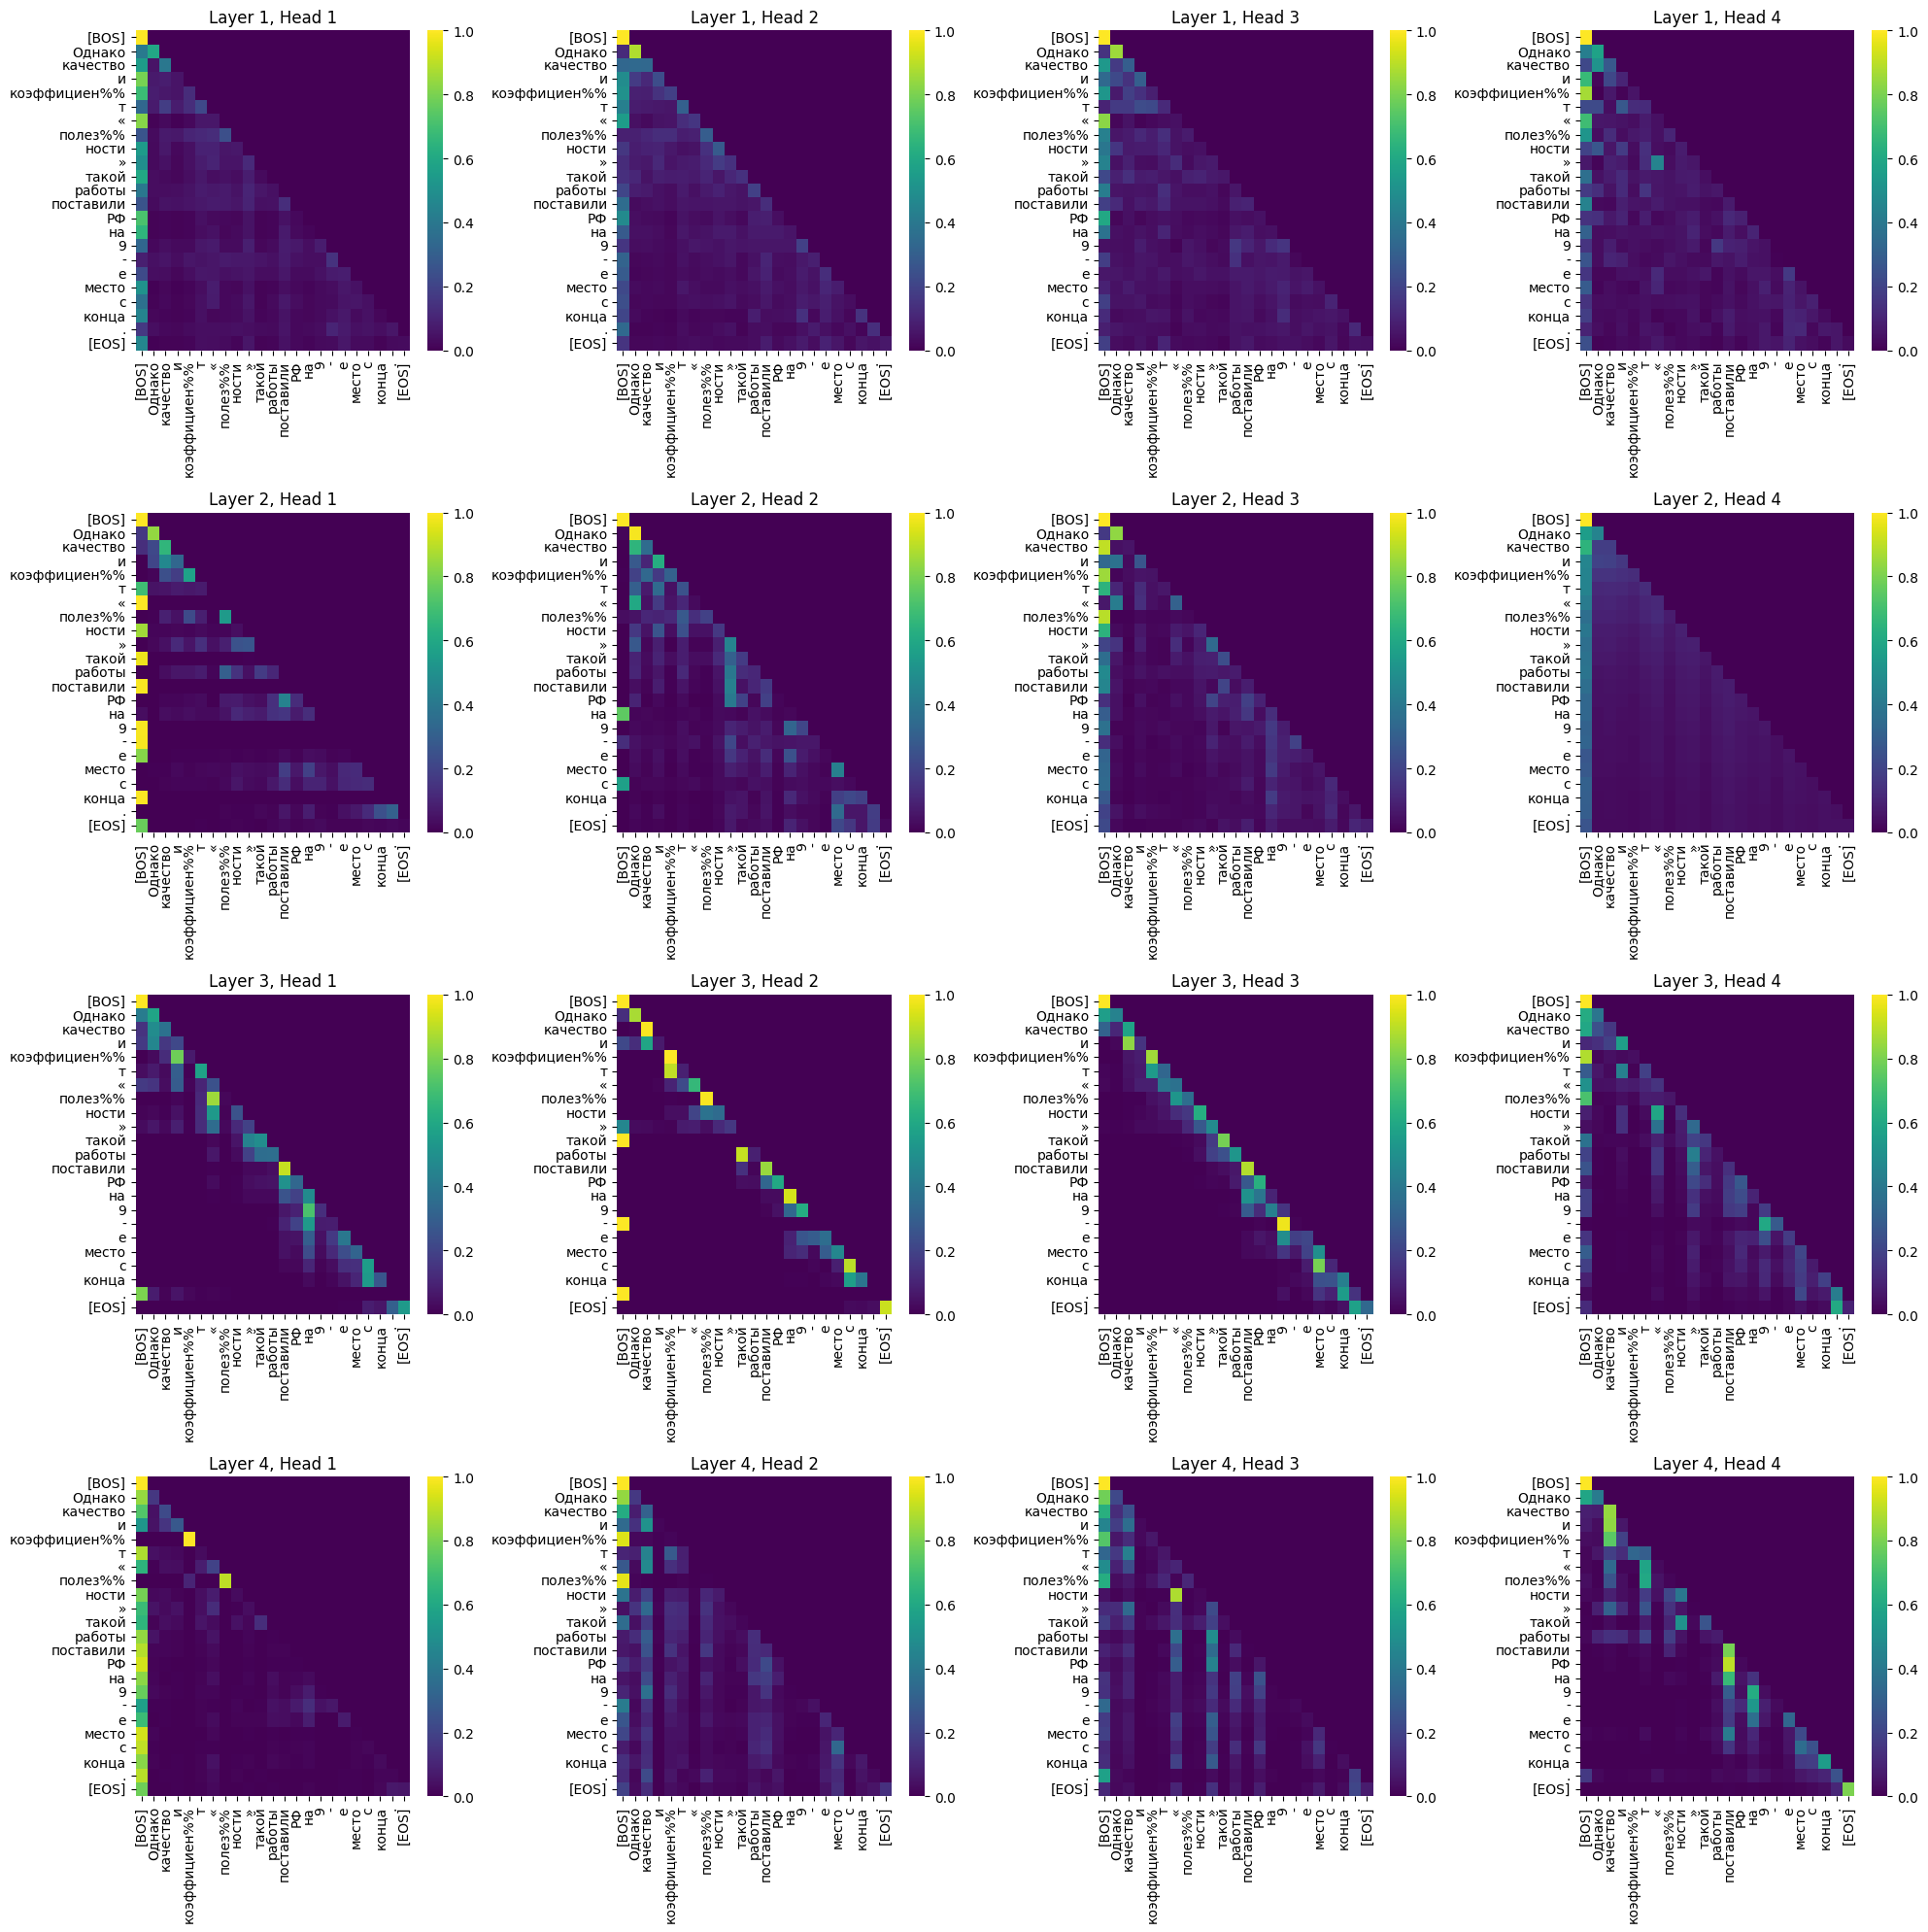

Epoch 15:


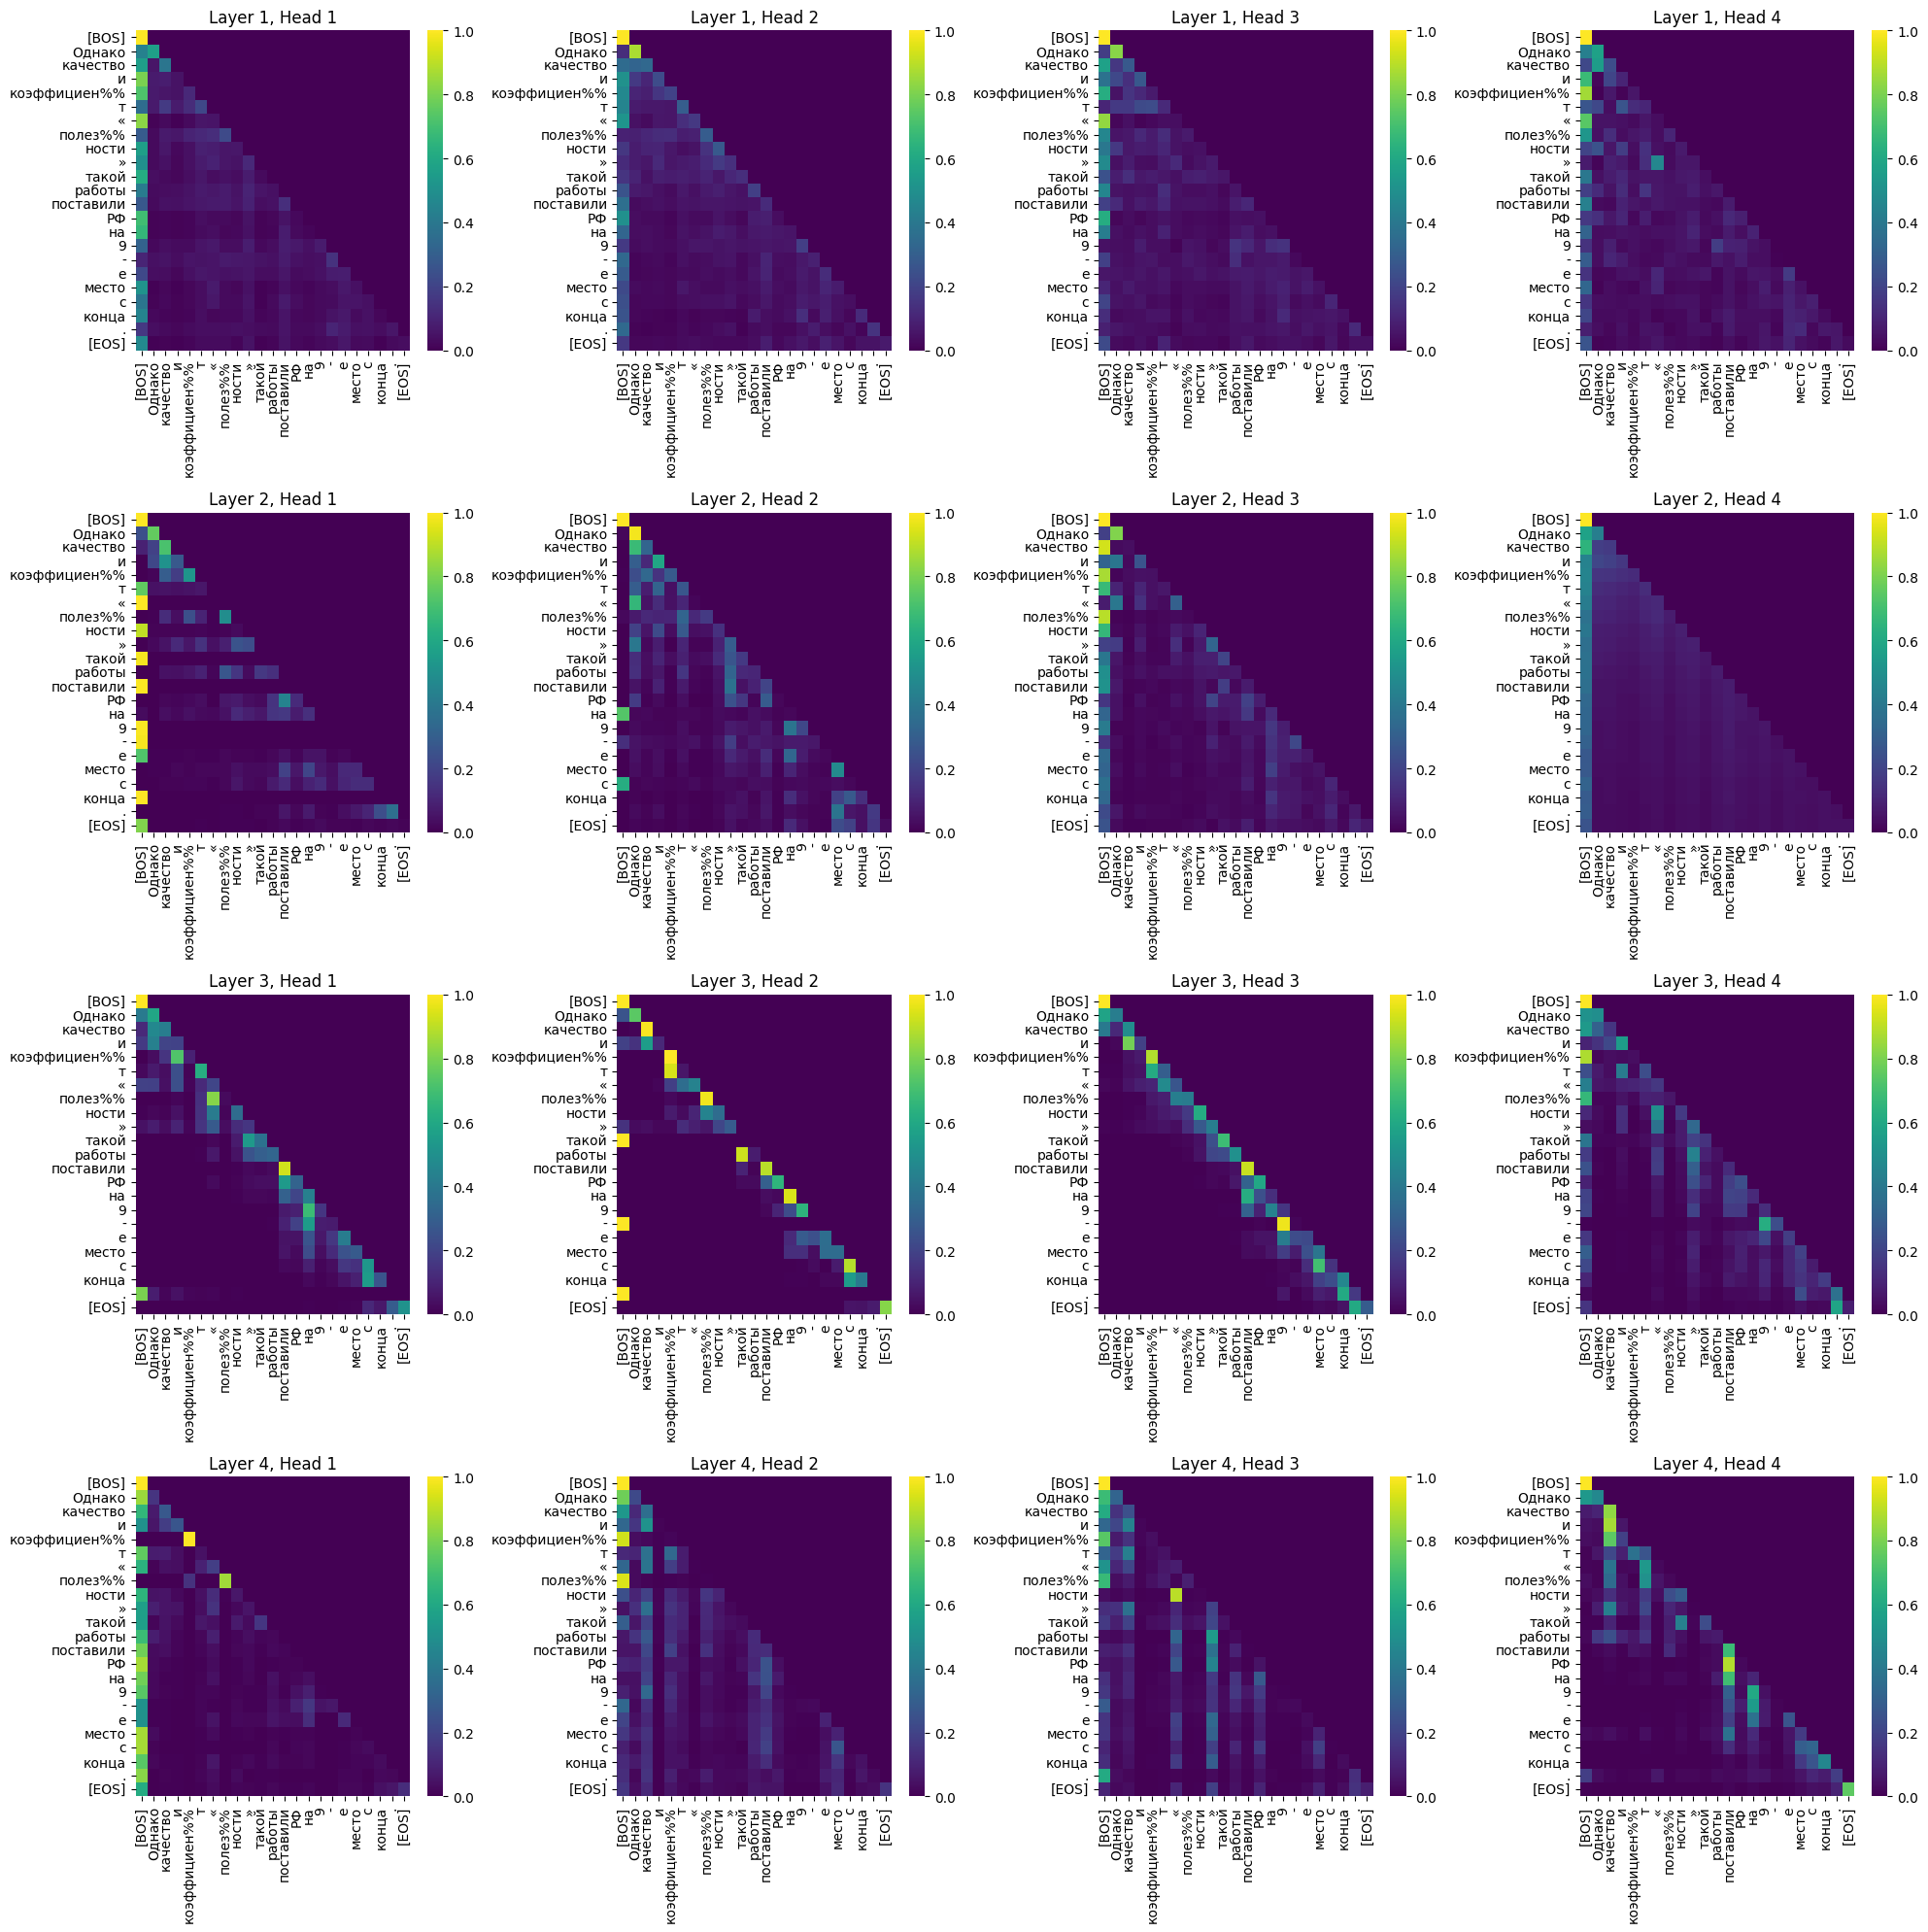

Epoch 16:


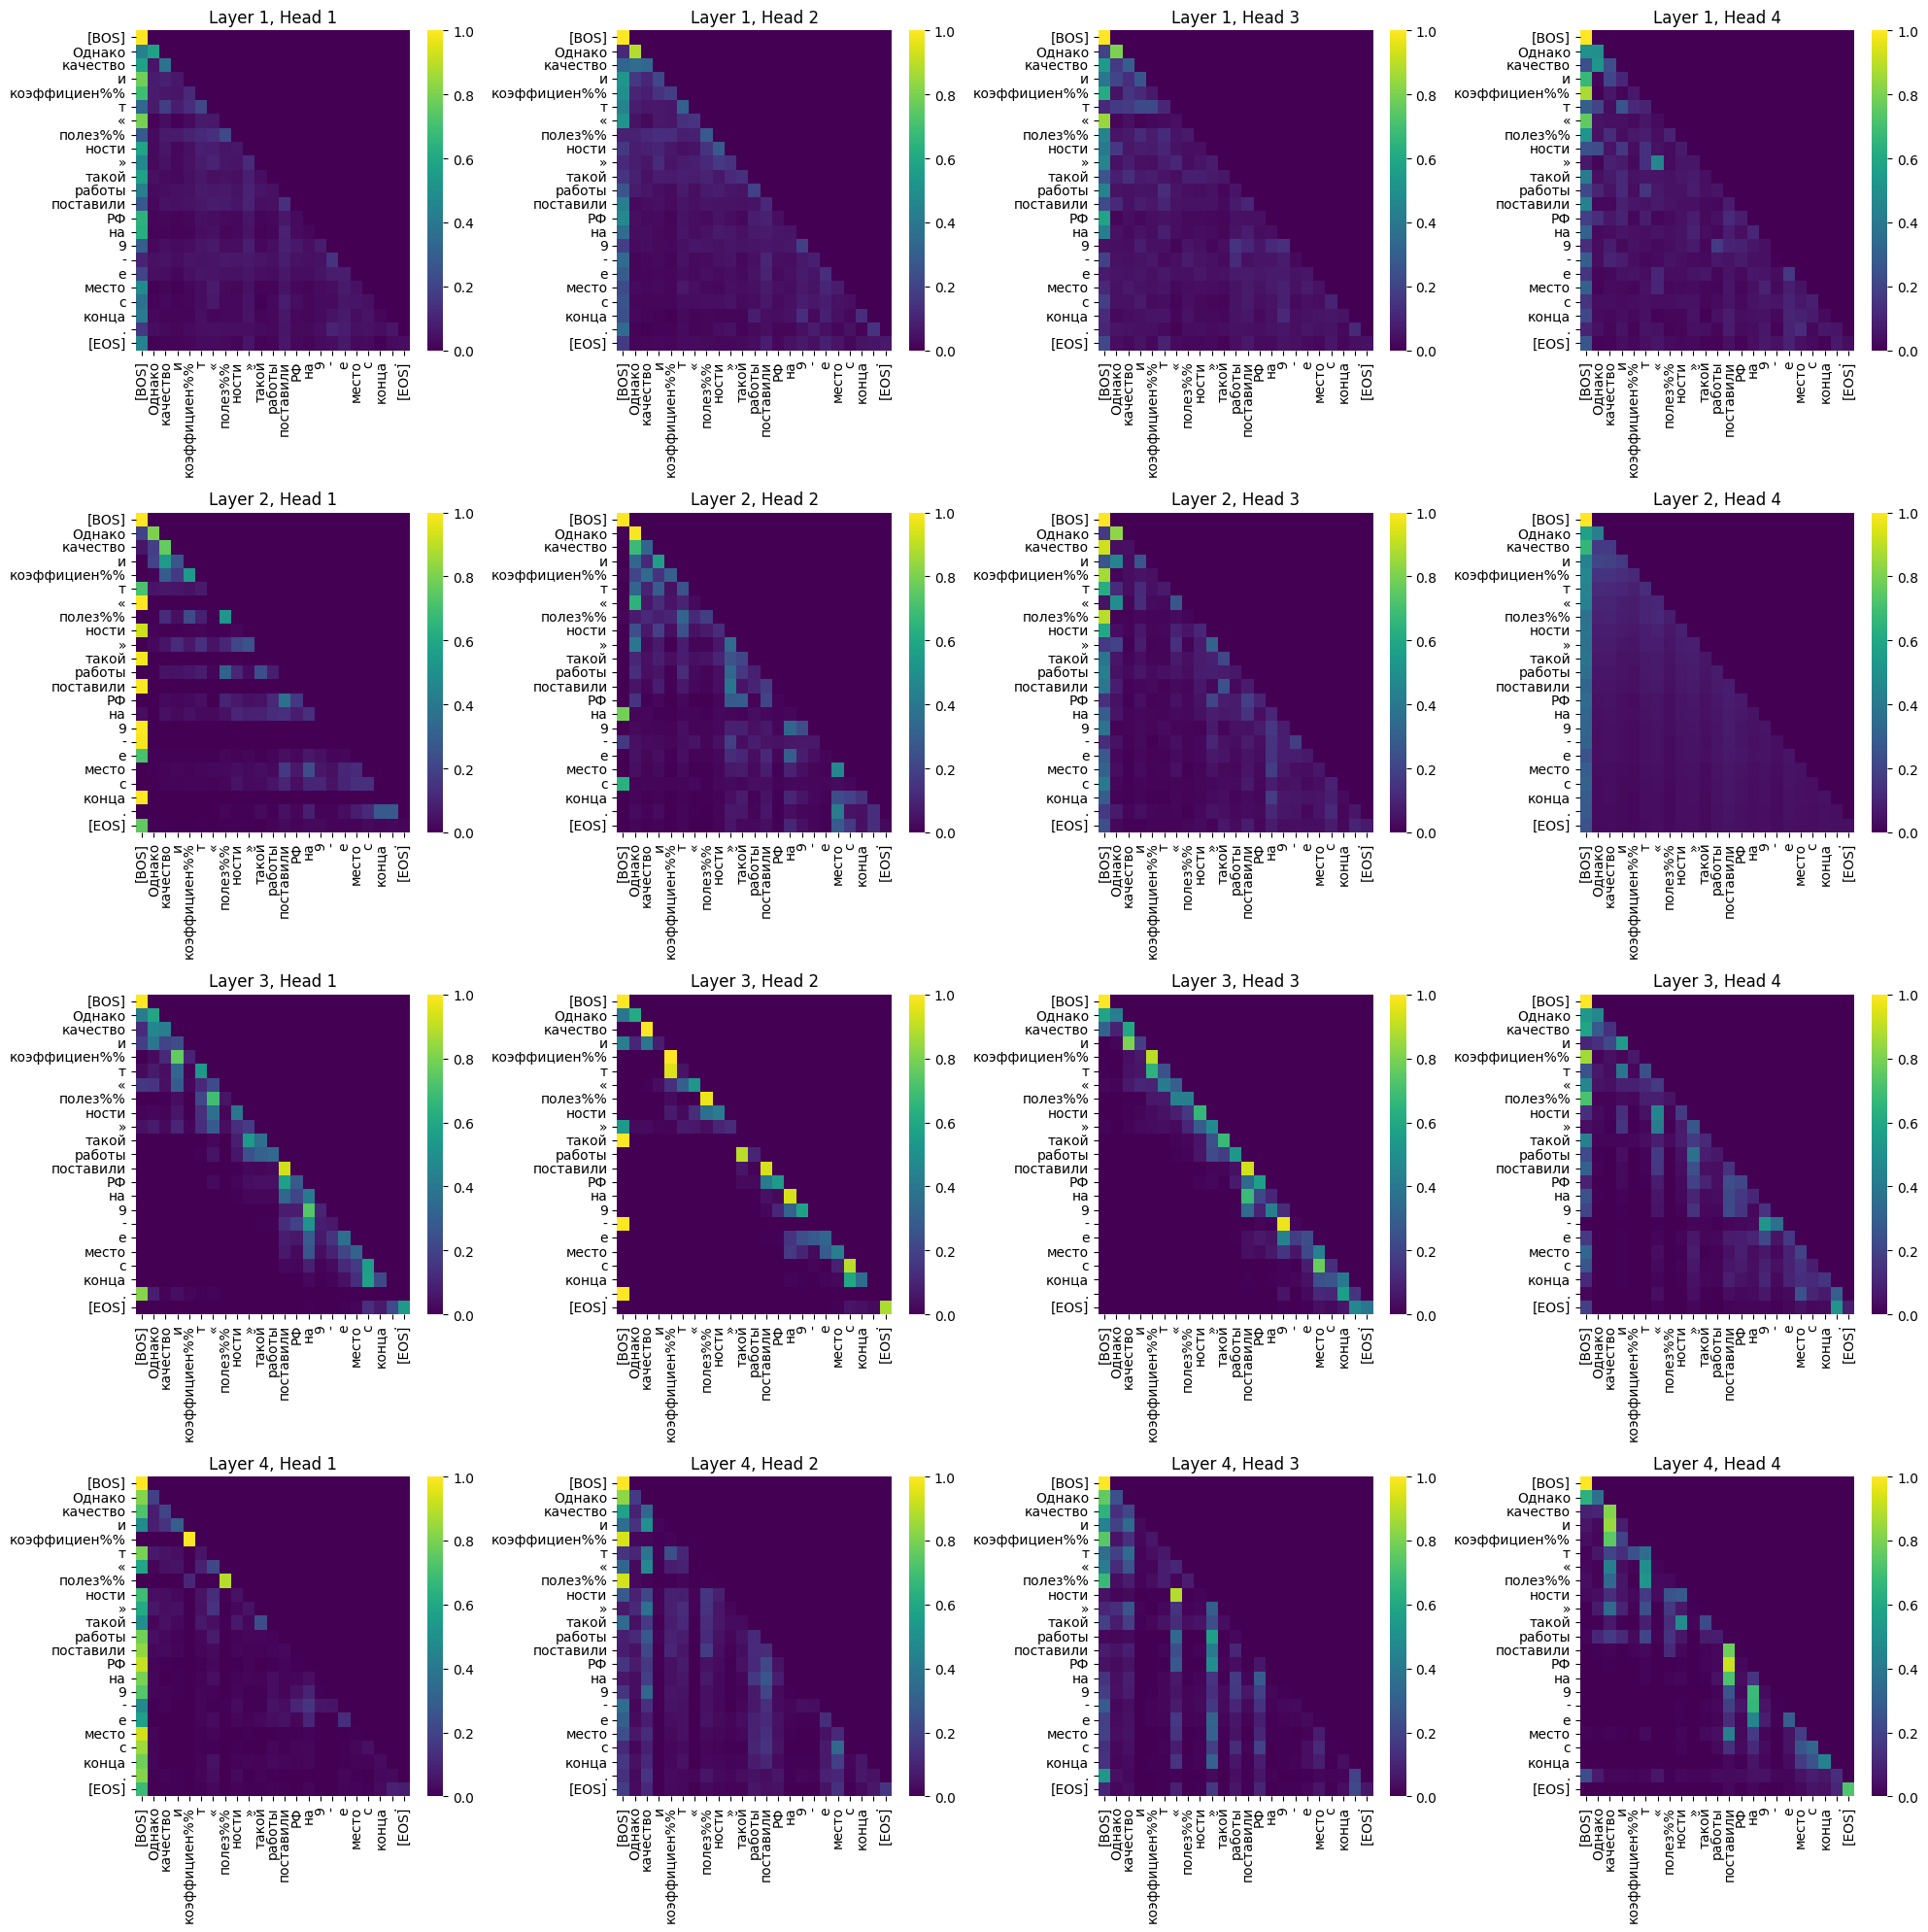

Epoch 17:


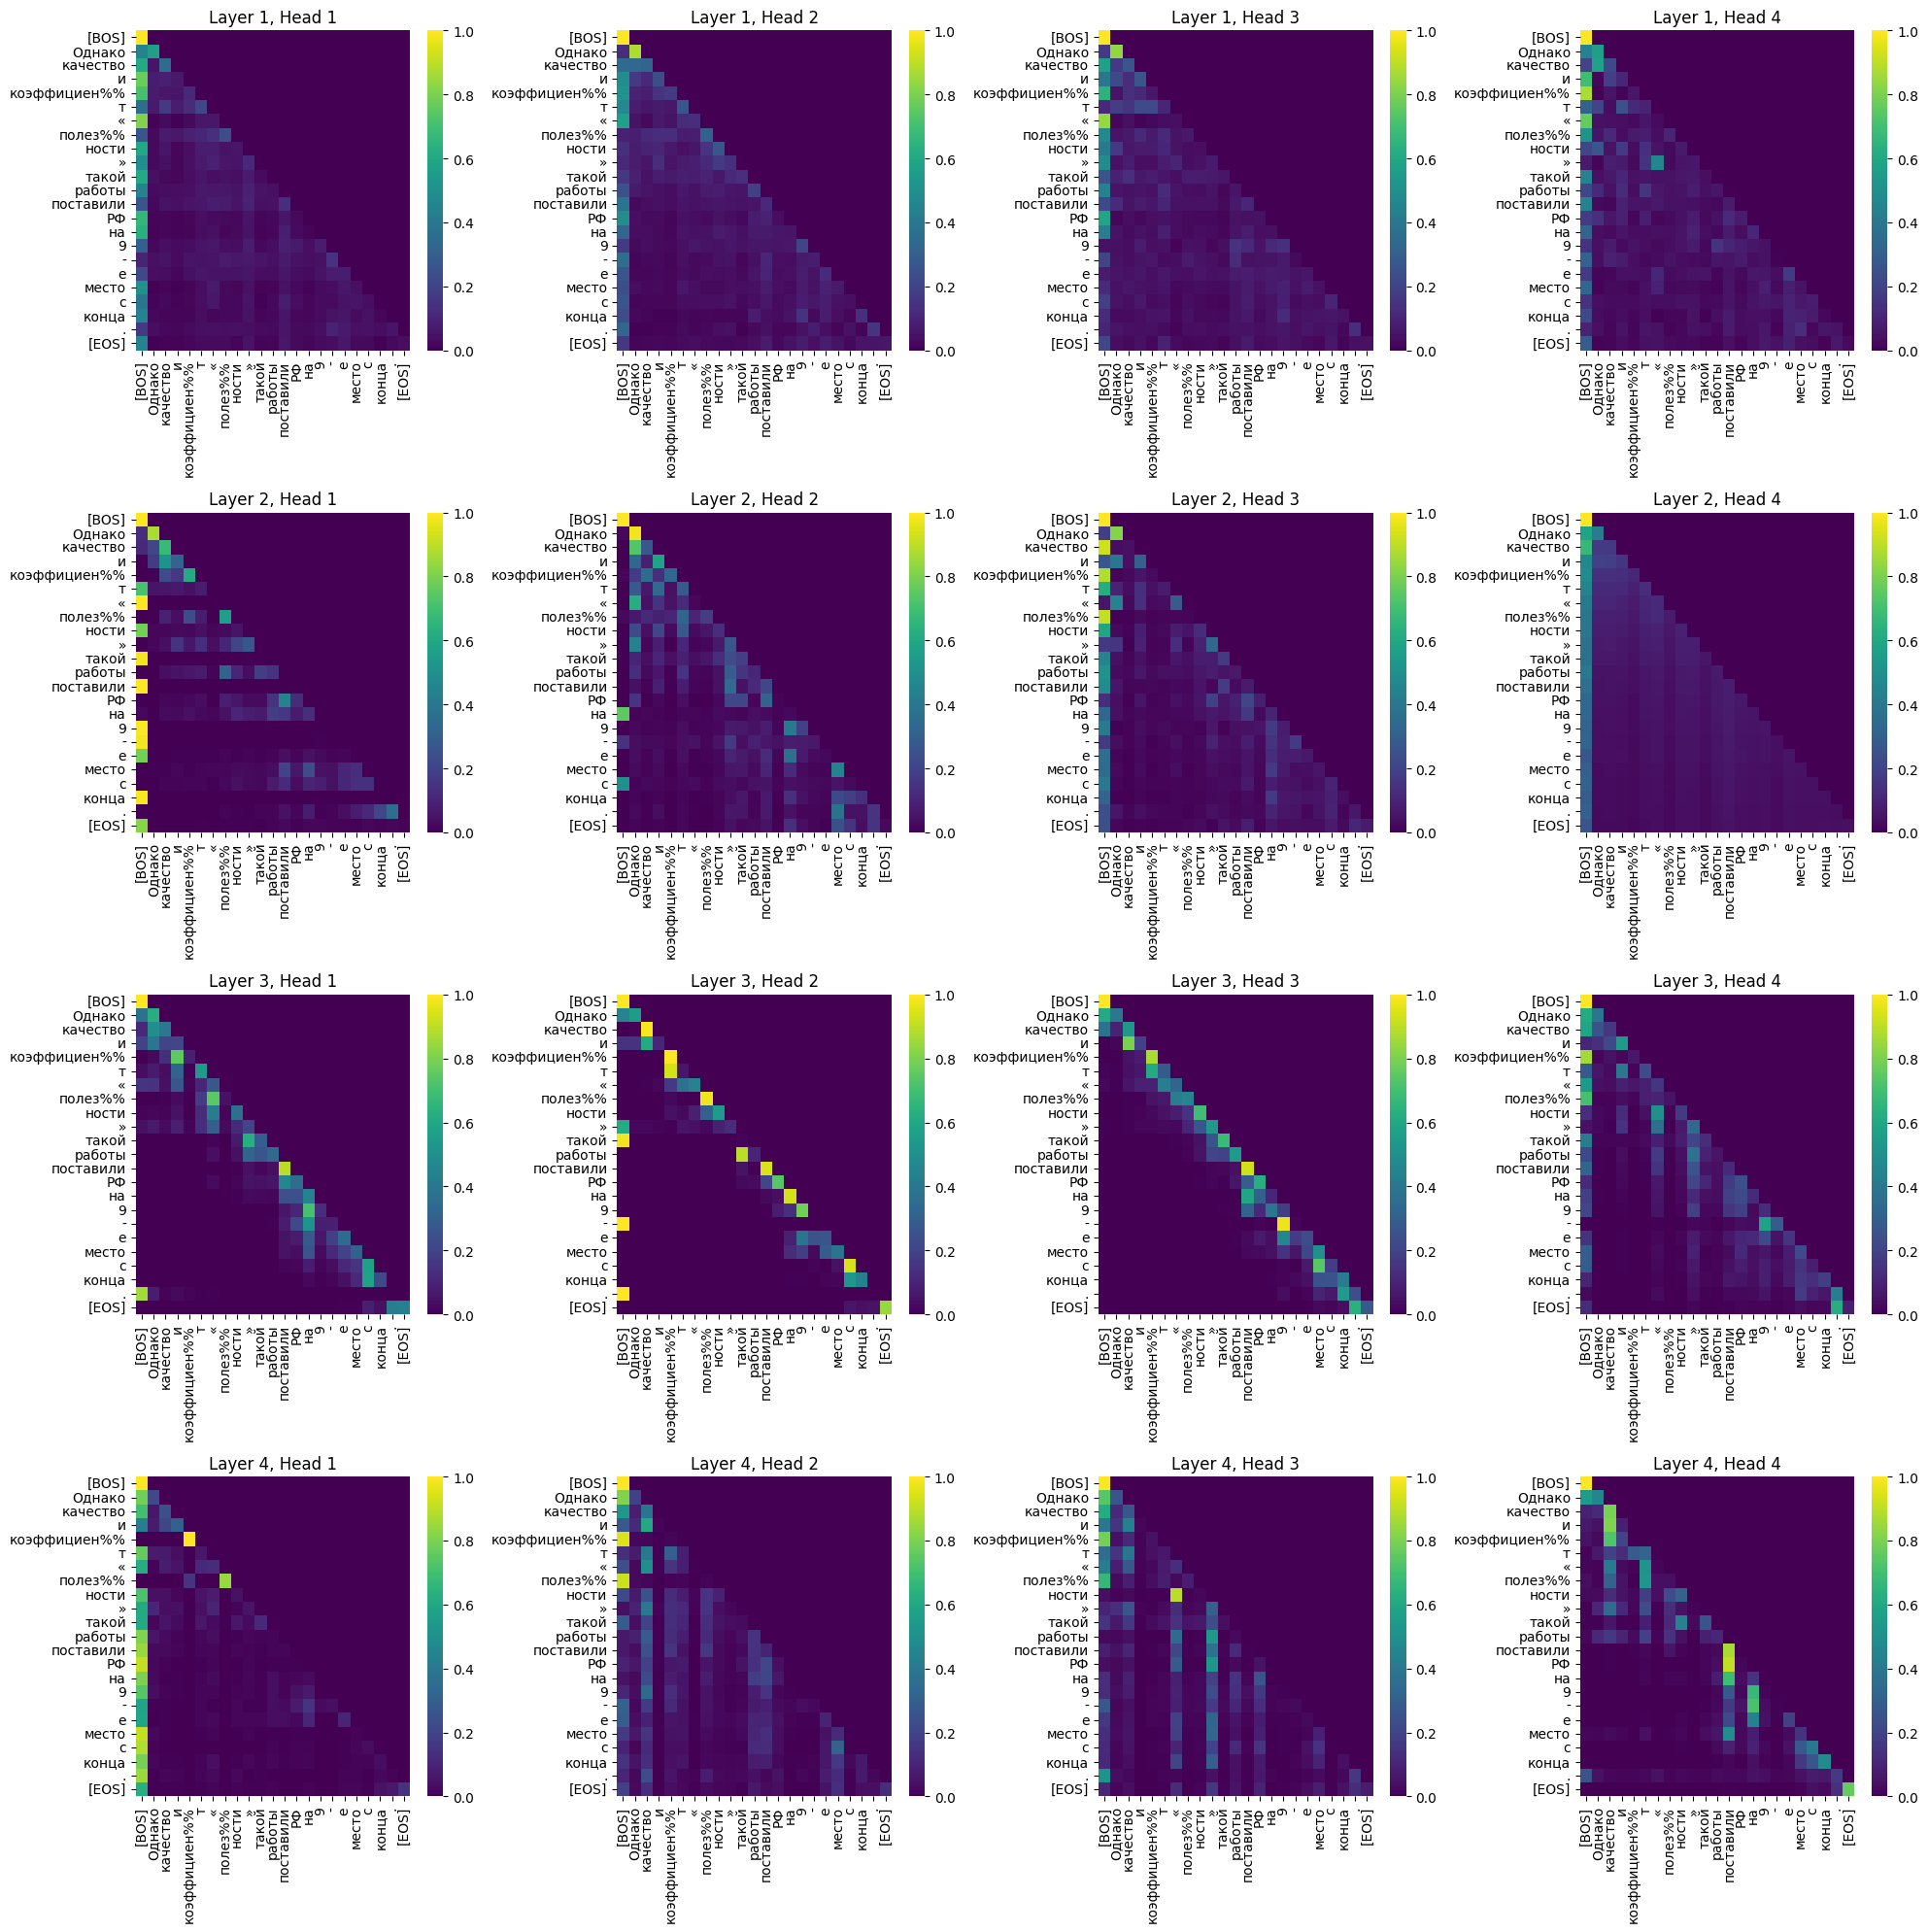

Epoch 18:


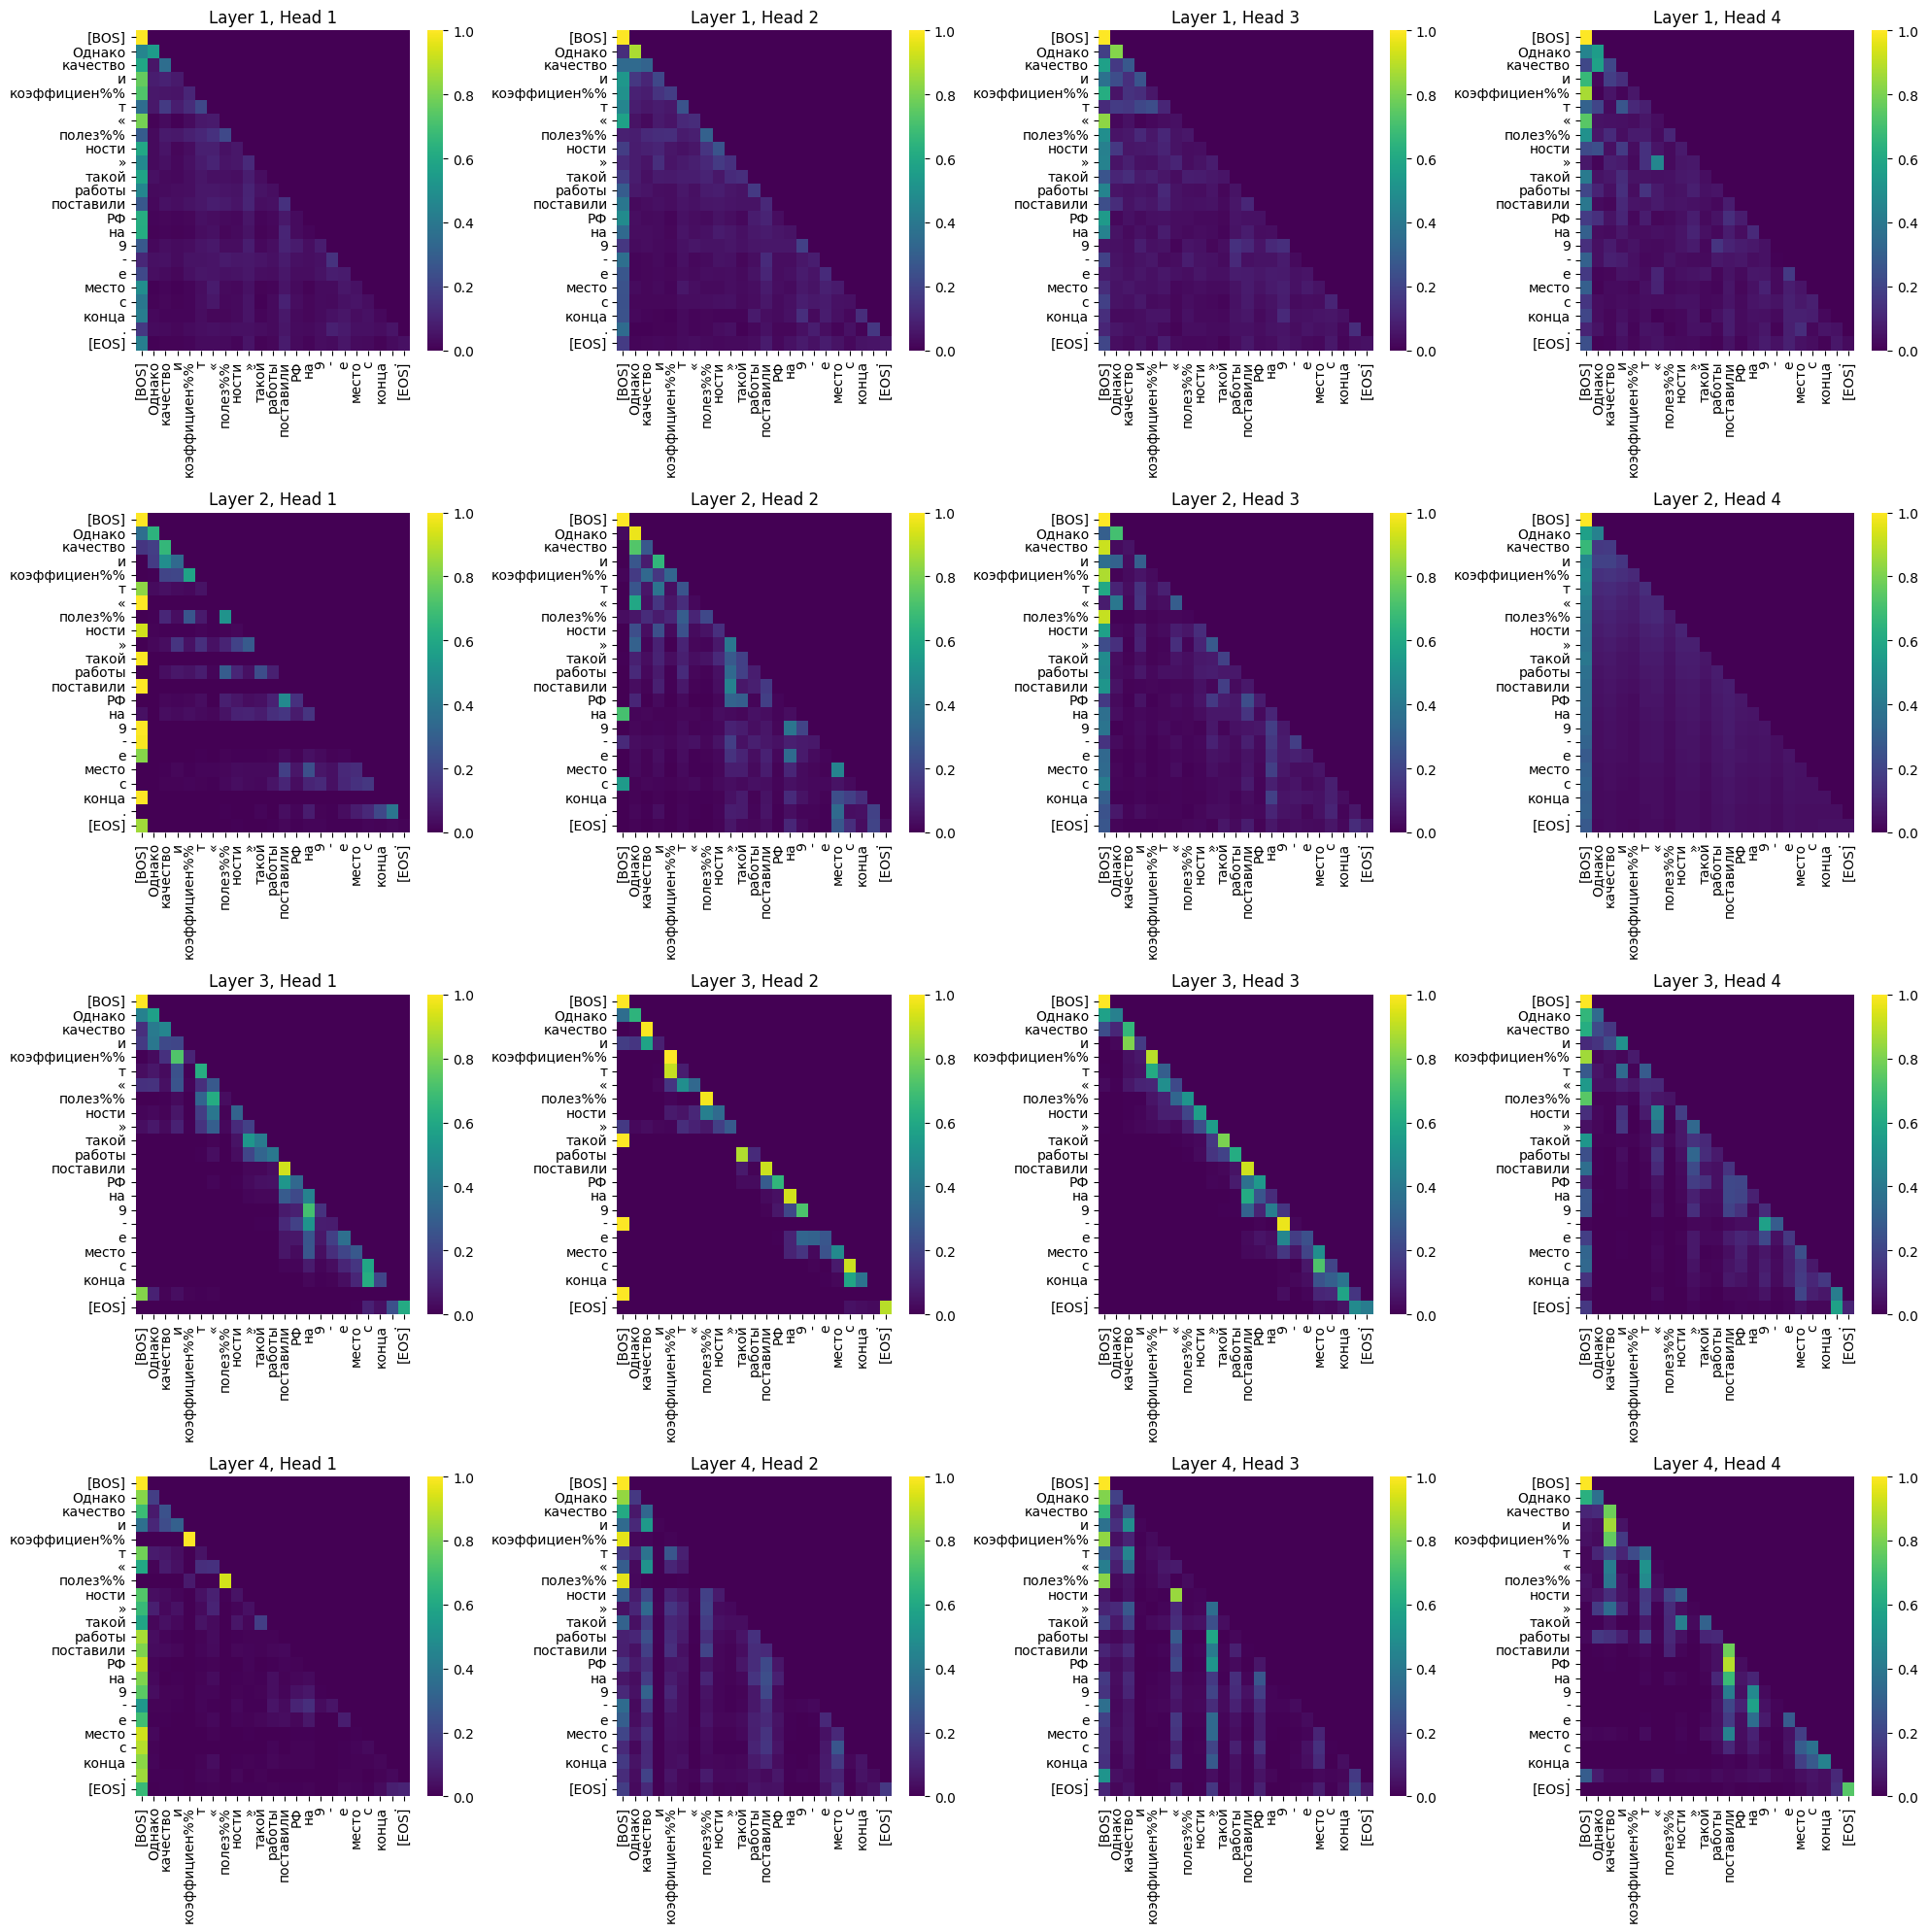

Epoch 19:


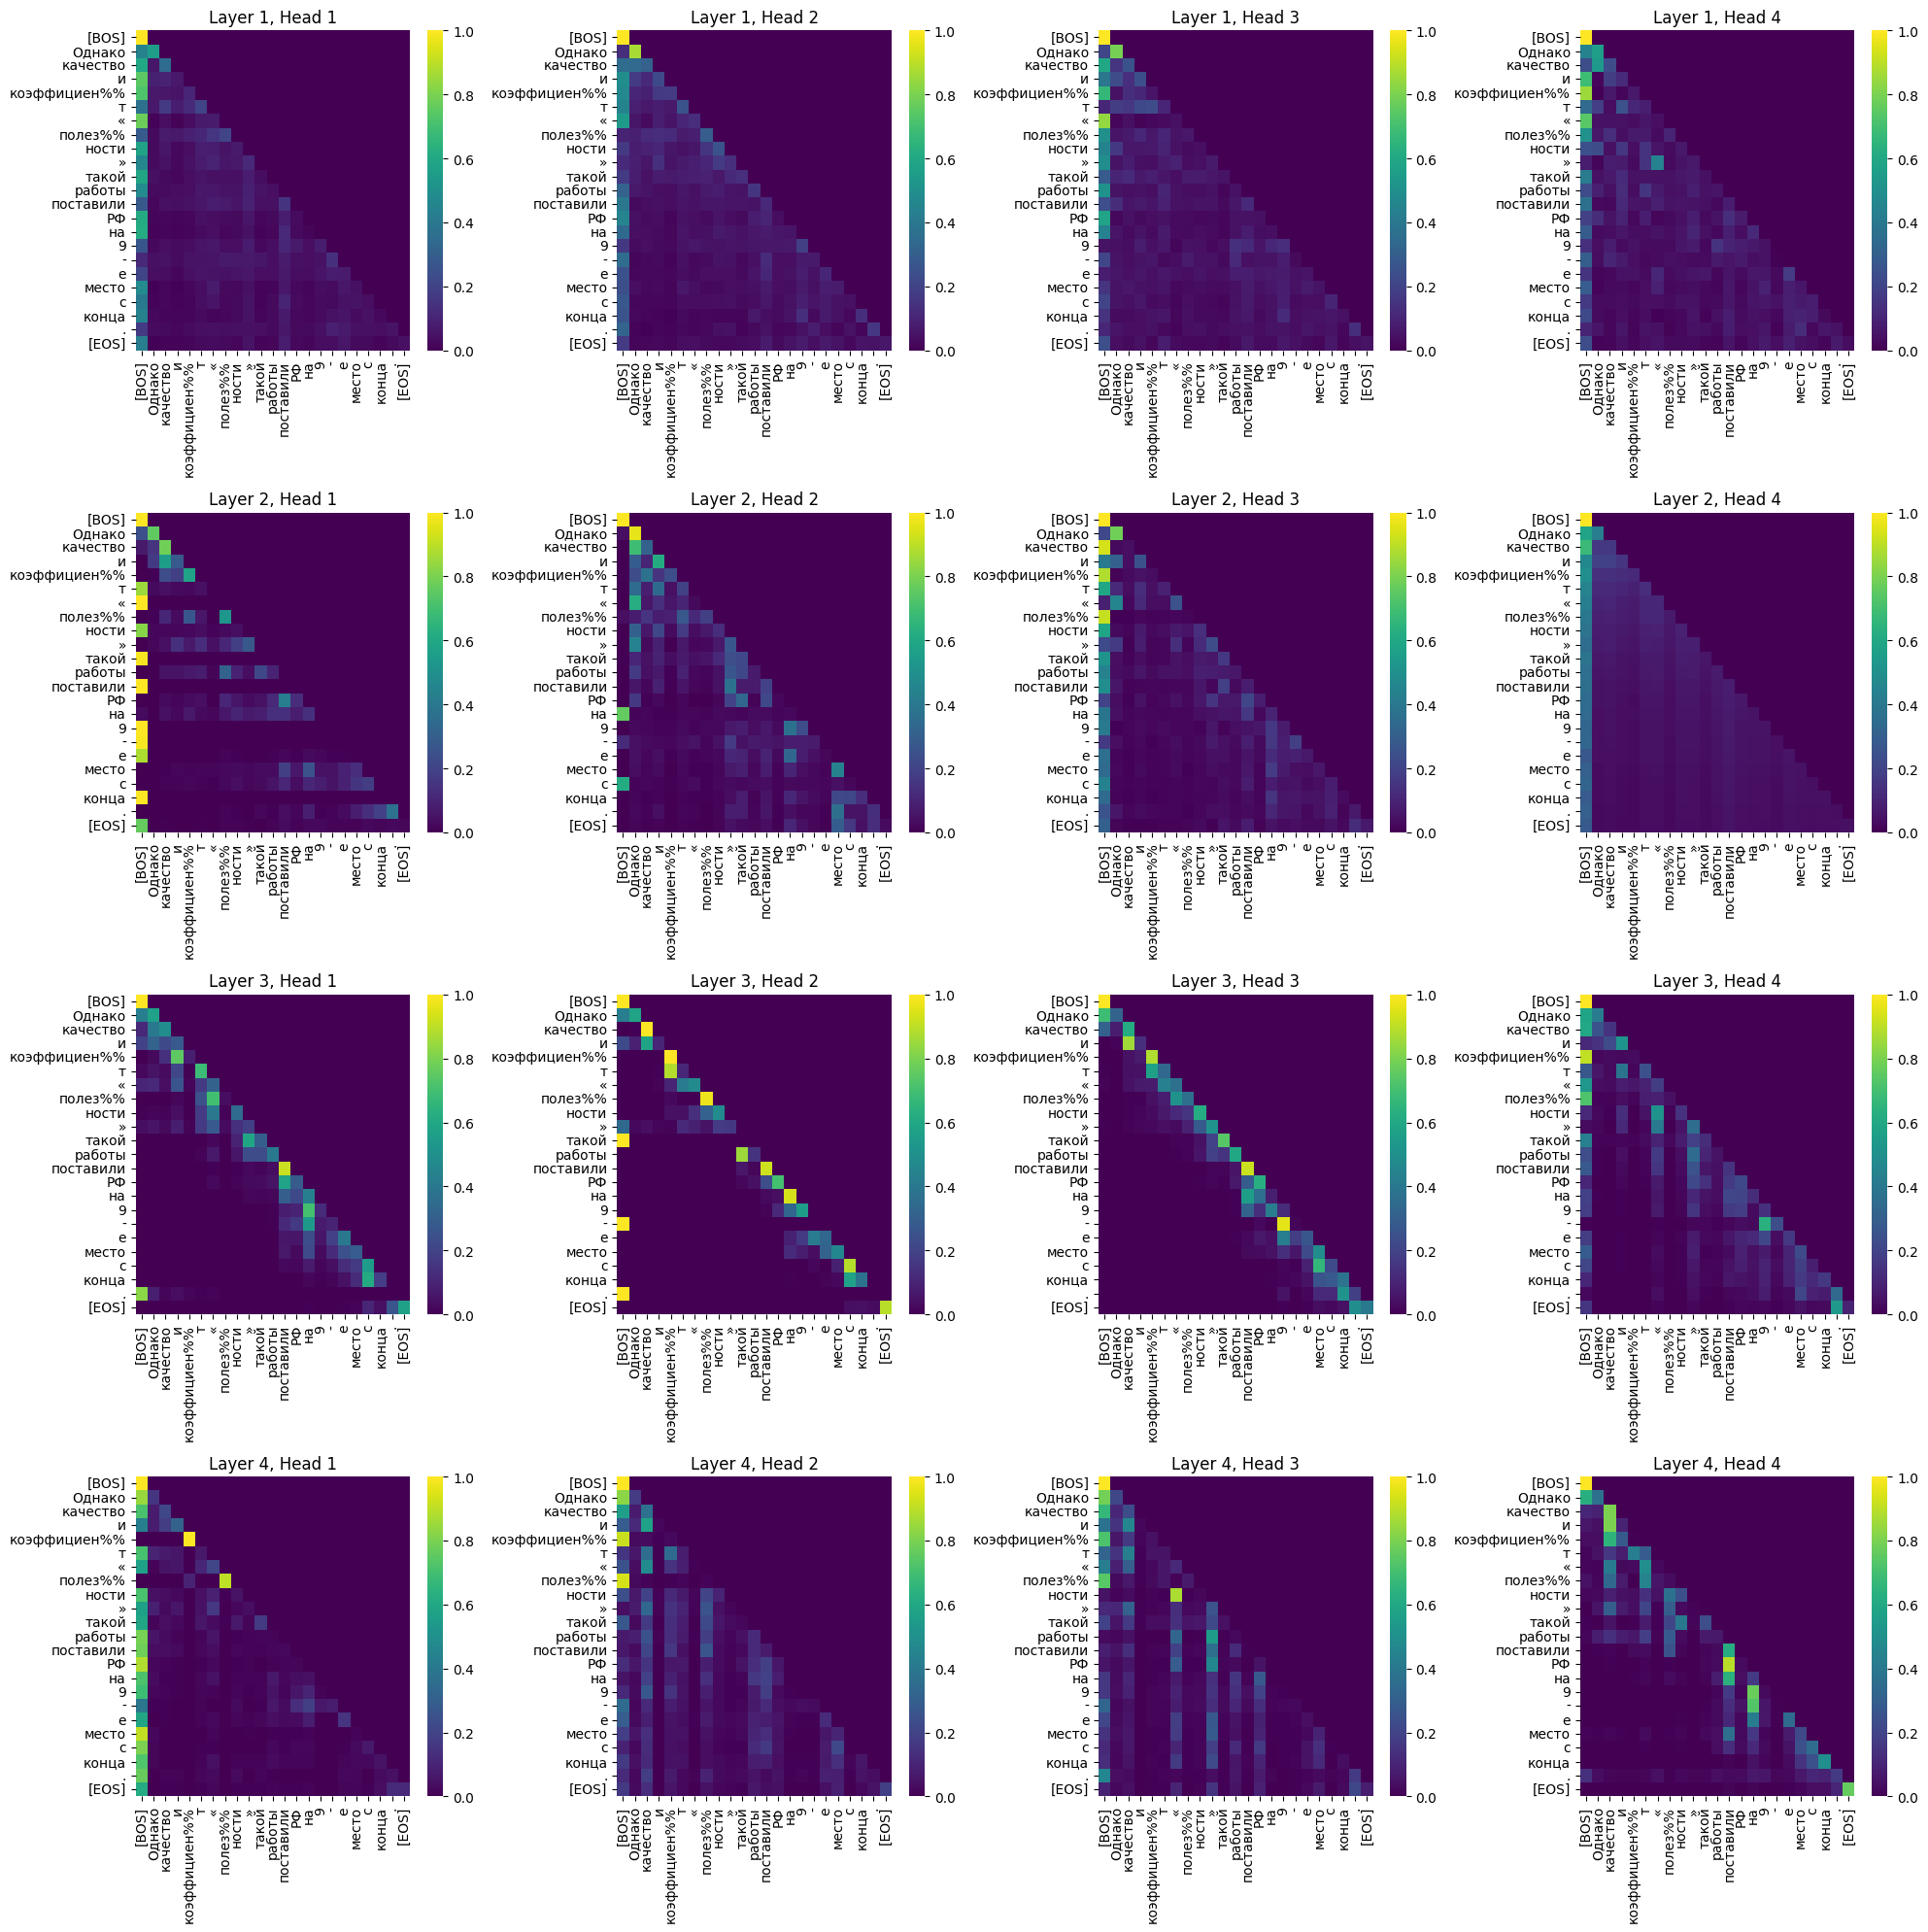

In [24]:
for epoch, attns in enumerate(all_attns):
    print(f"Epoch {epoch}:")
    visualize_attns(attns, tokens)